In [13]:
import xgboost as xgb
import json, logging
import numpy as np
import pandas as pd
import optuna
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from pathlib import Path
from datetime import datetime

In [ ]:
NOTEBOOK_NAME = "BIGMIX-XGBoost-Optimized"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path("../results") / f"{timestamp}_{NOTEBOOK_NAME}"
SUBDIRS = ["model", "optuna", "metrics", "logs"]

for sd in SUBDIRS:
    (RUN_DIR / sd).mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved under: {RUN_DIR.resolve()}")

def save_model(model, name="xgb_runtime_model"):
    model_path = RUN_DIR / "model" / f"{name}.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")


def save_optuna(study):
    joblib.dump(study, RUN_DIR / "optuna" / "study.pkl")
    trials_df = study.trials_dataframe()
    trials_df.to_csv(RUN_DIR / "optuna" / "trials.csv", index=False)
    with open(RUN_DIR / "optuna" / "best_params.json", "w") as f:
        json.dump(study.best_params, f, indent=2)
    print("Optuna study & best params stored")


def save_metrics(name: str, value):
    with open(RUN_DIR / "metrics" / f"{name}.json", "w") as f:
        json.dump(value, f, indent=2)

logfile = RUN_DIR / "logs" / "run.log"
logging.basicConfig(filename=logfile, filemode="w",
                    level=logging.INFO,
                    format="%(asctime)s %(levelname)s | %(message)s")
logging.info("Run directory initialised")

In [15]:
df_features = pd.read_csv('data/BIGMIX-train_test-features-withfilename.csv')
df_cplex_runtimes = pd.read_csv('data/BIGMIX-cplex.csv', header=None, names=["INSTANCE_ID","runtime"])
df_cplex_runtimes["runtime"] = pd.to_numeric(df_cplex_runtimes["runtime"])
df_features.head()

,INSTANCE_ID,probtype,n_vars,n_constr,n_nzcnt,nq_vars,nq_constr,nq_nzcnt,lp_avg,lp_l2_avg,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,23305.0,12498.0,169861.0,0.0,0.0,0.0,0.003246,0.032012,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.51667
1,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,1693.0,1628.0,12084.0,0.0,0.0,0.0,0.029611,0.096698,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.38333
2,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,3815.0,2676.0,15667.0,0.0,0.0,0.0,0.088451,1.245560,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.38333
3,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,15864.0,6844.0,53808.0,0.0,0.0,0.0,0.000003,0.000162,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.56667
4,/ubc/cs/project/arrow/projects/MIP_data/coral-...,1.0,838.0,1337.0,3418.0,0.0,0.0,0.0,0.398217,0.413461,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.36667


In [16]:
df_cplex_runtimes.head()

,INSTANCE_ID,runtime
0,/ubc/cs/project/arrow/projects/MIP_data/coral-...,35.56
1,/ubc/cs/project/arrow/projects/MIP_data/coral-...,3600.01
2,/ubc/cs/project/arrow/projects/MIP_data/coral-...,105.12
3,/ubc/cs/project/arrow/projects/MIP_data/coral-...,4.78
4,/ubc/cs/project/arrow/projects/MIP_data/coral-...,46.91


In [17]:
# Steps from Hutter et al.(compare preeliminaries):
# 1. Remove constant columns
# 2. Replace the sentinel –512 with NaN
# 3. Standardise every remaining column to mean 0 / std 1. The means/SDs are computed ignoring NaNs.
# 4. Fill the remaining NaNs with 0, so a “missing” value is interpreted as “the mean of that column” after scaling.


# instance id does nothing for performance prediction
df_features.drop(['INSTANCE_ID'], inplace=True, axis=1)
df_cplex_runtimes.drop(['INSTANCE_ID'], inplace=True, axis=1)
# Some rows have the same values - we won't be needing them as they only increase complexity.
single_value_cols = df_features.columns[df_features.nunique(dropna=False) == 1]
single_value_cols

Index([' probtype', ' nq_vars', ' nq_constr', ' nq_nzcnt', ' num_s_variables',
       ' num_n_variables', ' ratio_s_variables', ' ratio_n_variables',
       ' itcnt_max', ' numnewsolution_sum', ' newin_sum', ' nodeleft_avg',
       ' nodeleft_varcoef', ' diffObj_avg', ' diffObj_median',
       ' diffObj_varcoef', ' diffObj_q90mq10', ' numfeas', ' iinf_avg',
       ' iinf_median', ' iinf_varcoef', ' iinf_q90mq10', ' diffBestInt_avg',
       ' diffBestInt_median', ' diffBestInt_varcoef', ' diffBestInt_q90mq10',
       ' diffBestObjUp_avg', ' diffBestObjUp_median', ' diffBestObjUp_varcoef',
       ' diffBestObjUp_q90mq10', ' numcuts_sum', ' diffGap_avg',
       ' diffGap_median', ' diffGap_varcoef', ' diffGap_q90mq10'],
      dtype='object')

In [18]:
df_features.drop(single_value_cols, axis=1, inplace=True)
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [19]:
df_features.replace(-512, np.nan, inplace=True) # TODO: add these steps to pipeline
df_features

,n_vars,n_constr,n_nzcnt,lp_avg,lp_l2_avg,lp_linf,lp_objval,num_b_variables,num_i_variables,num_c_variables,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,23305.0,12498.0,169861.0,0.003246,0.032012,0.500000,-9.992000e+01,23305.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.416700,0.166667,0.016667,0.166667,8.516670
1,1693.0,1628.0,12084.0,0.029611,0.096698,0.478178,1.742000e+03,1648.0,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.283333,0.016667,0.000000,0.000000,8.383330
2,3815.0,2676.0,15667.0,0.088451,1.245560,48.419400,1.196310e+06,3800.0,15.0,0.0,...,334.0,0.0,0.0,0.0,96.0,0.150000,0.033333,0.000000,0.016667,8.383330
3,15864.0,6844.0,53808.0,0.000003,0.000162,0.016000,5.801100e+01,10350.0,0.0,5514.0,...,0.0,0.0,0.0,0.0,17.0,1.500000,0.050000,0.033333,0.066667,8.566670
4,838.0,1337.0,3418.0,0.398217,0.413461,0.495500,6.717460e+01,150.0,0.0,688.0,...,0.0,196.0,106.0,0.0,29.0,0.033333,0.000000,0.000000,0.016667,8.366670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,1620.0,2520.0,15327.0,0.063706,0.137548,0.500000,0.000000e+00,1620.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.700000,0.016667,0.016667,0.000000,8.383330
1506,33.0,16.0,98.0,0.045326,0.131020,0.500000,2.520570e+03,33.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.016667
1507,27.0,118.0,378.0,0.259259,0.293972,0.333333,1.300000e+01,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.516667
1508,520.0,296.0,1040.0,0.012557,0.066423,0.473684,3.857020e+03,260.0,0.0,260.0,...,0.0,0.0,30.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,8.400000


In [20]:
X = df_features
runtimes = df_cplex_runtimes['runtime'].clip(lower=0.005)
y = np.log10(runtimes)

In [21]:
N_FOLDS   = 10
RANDOM_STATE    = 1234

xgb_params = dict(
    n_estimators   = 100,
    objective      = "reg:squarederror",
    tree_method    = "hist",
    eval_metric    = "rmse",
    random_state   = RANDOM_STATE
)

In [22]:
rmse_scorer = make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        greater_is_better=False
    )

In [23]:
def corr_coeff(y_true, mu):
    """
    Pearson correlation between target and predicted mean.
    Equals Matlab’s ‘cc’.
    """
    return np.corrcoef(y_true, mu)[0, 1]

In [24]:
outer = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
rmse_outer = []
ccs_outer = []
best_overall_rmse = np.inf
best_study        = None          # will hold the Optuna study with the lowest fold RMSE
best_fold_idx     = None
best_params       = None

for fold, (train_idx, test_idx) in enumerate(outer.split(X), 1):
    print(f"Outer fold {fold}/10")
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    def objective(trial):
        num_round = trial.suggest_int("num_boost_round", 300, 1200, step=50)
        params = {
            "learning_rate":     trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
            "max_depth":         trial.suggest_int("max_depth", 5, 10),
            "min_child_weight":  trial.suggest_float("min_child_weight", 1e-3, 1, log=True),
            "subsample":         trial.suggest_float("subsample", .5, .9),
            "colsample_bytree":  trial.suggest_float("colsample_bytree", .7, .9),
            "reg_alpha":         trial.suggest_float("reg_alpha", 1e-8, 1, log=True),
            "reg_lambda":        trial.suggest_float("reg_lambda", 1e-8, 1, log=True),
            # fixed:
            "objective":         "reg:squarederror",
            "tree_method":       "hist",
            "random_state":      RANDOM_STATE,
            "gamma":             0,
        }

        dtrain = xgb.DMatrix(X_tr, label=y_tr)

        cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round       = num_round,
        nfold           = 2,
        metrics         = "rmse",
        seed            = RANDOM_STATE,
        stratified      = False,
        shuffle         = True,
        early_stopping_rounds = 50,
        verbose_eval    = False,
        )
        best_rmse = cv_results["test-rmse-mean"].iloc[-1]
        return -best_rmse


    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=40, show_progress_bar=True, n_jobs=-1)

    fold_params = study.best_params.copy()
    num_round   = fold_params.pop("num_boost_round")

    fold_params |= {
        "objective"   : "reg:squarederror",
        "tree_method" : "hist",
        "seed"        : RANDOM_STATE,
    }

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dtest  = xgb.DMatrix(X_te, label=y_te)

    booster = xgb.train(
        params            = fold_params,
        dtrain            = dtrain,
        num_boost_round   = num_round,
        evals             = [(dtrain, "train")],
        verbose_eval      = False,
    )

    preds = booster.predict(dtest)
    fold_rmse = np.sqrt(mean_squared_error(y_te, preds))
    rmse_outer.append(fold_rmse)
    ccs_outer.append(corr_coeff(y_te, preds))


    print(f"  RMSE = {fold_rmse:.4f}")

    if fold_rmse < best_overall_rmse:
        best_overall_rmse = fold_rmse
        best_study        = study
        best_fold_idx     = fold
        best_params       = fold_params | {"num_boost_round": num_round}



[I 2025-07-30 12:23:38,423] A new study created in memory with name: no-name-f28adfd0-888a-48cd-8b3a-317899b151d2


Outer fold 1/10


Best trial: 10. Best value: -0.667274:   2%|▎         | 1/40 [00:09<06:16,  9.65s/it]

[I 2025-07-30 12:23:48,071] Trial 10 finished with value: -0.6672744931296402 and parameters: {'num_boost_round': 450, 'learning_rate': 0.12420122754717312, 'max_depth': 9, 'min_child_weight': 0.02074418823838034, 'subsample': 0.6822528090411455, 'colsample_bytree': 0.8832167333016878, 'reg_alpha': 4.8101138524026514e-08, 'reg_lambda': 0.0002531646919566219}. Best is trial 10 with value: -0.6672744931296402.


Best trial: 10. Best value: -0.667274:   5%|▌         | 2/40 [00:13<03:50,  6.08s/it]

[I 2025-07-30 12:23:51,637] Trial 4 finished with value: -0.6680840173198304 and parameters: {'num_boost_round': 500, 'learning_rate': 0.1466044225314684, 'max_depth': 6, 'min_child_weight': 0.16327309509845808, 'subsample': 0.6696830089642486, 'colsample_bytree': 0.7917681011744608, 'reg_alpha': 8.028612125261014e-05, 'reg_lambda': 3.780317836571809e-07}. Best is trial 10 with value: -0.6672744931296402.


Best trial: 10. Best value: -0.667274:   8%|▊         | 3/40 [00:14<02:22,  3.84s/it]

[I 2025-07-30 12:23:52,828] Trial 1 finished with value: -0.6881931416908971 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.1522616030629453, 'max_depth': 5, 'min_child_weight': 0.002667067540542675, 'subsample': 0.6691698708186676, 'colsample_bytree': 0.8142816803554165, 'reg_alpha': 0.00045772969784861953, 'reg_lambda': 6.291415278931369e-08}. Best is trial 10 with value: -0.6672744931296402.


Best trial: 6. Best value: -0.664853:  10%|█         | 4/40 [00:20<02:49,  4.70s/it] 

[I 2025-07-30 12:23:58,852] Trial 6 finished with value: -0.6648527574369311 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.0816937828507307, 'max_depth': 9, 'min_child_weight': 0.0012127928522153025, 'subsample': 0.5256352942433291, 'colsample_bytree': 0.729834248210261, 'reg_alpha': 0.008615014560216093, 'reg_lambda': 3.8870666366783e-05}. Best is trial 6 with value: -0.6648527574369311.


Best trial: 6. Best value: -0.664853:  12%|█▎        | 5/40 [00:25<02:46,  4.75s/it]

[I 2025-07-30 12:24:03,648] Trial 5 finished with value: -0.6655826583686971 and parameters: {'num_boost_round': 400, 'learning_rate': 0.10523920985547416, 'max_depth': 8, 'min_child_weight': 0.6731145854354706, 'subsample': 0.5724197774569133, 'colsample_bytree': 0.8361509040987646, 'reg_alpha': 6.527025015087825e-05, 'reg_lambda': 6.316059218803846e-07}. Best is trial 6 with value: -0.6648527574369311.


Best trial: 6. Best value: -0.664853:  15%|█▌        | 6/40 [00:28<02:18,  4.07s/it]

[I 2025-07-30 12:24:06,438] Trial 8 finished with value: -0.6709592130317855 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.06903206035014083, 'max_depth': 9, 'min_child_weight': 0.03719292905233696, 'subsample': 0.6340285737393295, 'colsample_bytree': 0.7694392959712514, 'reg_alpha': 1.0976431312229378e-08, 'reg_lambda': 5.195753740407014e-06}. Best is trial 6 with value: -0.6648527574369311.


Best trial: 3. Best value: -0.649203:  18%|█▊        | 7/40 [00:29<01:50,  3.36s/it]

[I 2025-07-30 12:24:08,332] Trial 3 finished with value: -0.6492033402269619 and parameters: {'num_boost_round': 350, 'learning_rate': 0.022312304226488406, 'max_depth': 10, 'min_child_weight': 0.4520424792518005, 'subsample': 0.7566328436912021, 'colsample_bytree': 0.8760194419293875, 'reg_alpha': 0.02751871160936304, 'reg_lambda': 5.57679305310275e-07}. Best is trial 3 with value: -0.6492033402269619.


Best trial: 0. Best value: -0.64462:  20%|██        | 8/40 [00:33<01:50,  3.45s/it] 

[I 2025-07-30 12:24:11,965] Trial 0 finished with value: -0.6446198741770162 and parameters: {'num_boost_round': 450, 'learning_rate': 0.029537589152959755, 'max_depth': 9, 'min_child_weight': 0.001686393718649748, 'subsample': 0.6913915659163881, 'colsample_bytree': 0.7886037758196867, 'reg_alpha': 0.005252417198785142, 'reg_lambda': 0.024709711426010035}. Best is trial 0 with value: -0.6446198741770162.
[I 2025-07-30 12:24:11,985] Trial 9 finished with value: -0.6478282680201553 and parameters: {'num_boost_round': 500, 'learning_rate': 0.038319924546656586, 'max_depth': 8, 'min_child_weight': 0.9611117117859544, 'subsample': 0.629418600637417, 'colsample_bytree': 0.8388773277961769, 'reg_alpha': 0.0014522040791018177, 'reg_lambda': 0.5349940688200627}. Best is trial 0 with value: -0.6446198741770162.


Best trial: 0. Best value: -0.64462:  25%|██▌       | 10/40 [00:34<01:04,  2.14s/it]

[I 2025-07-30 12:24:13,379] Trial 17 finished with value: -0.677095252486957 and parameters: {'num_boost_round': 950, 'learning_rate': 0.17708823392391332, 'max_depth': 8, 'min_child_weight': 0.2801218940889704, 'subsample': 0.6454869214851504, 'colsample_bytree': 0.8419852148682372, 'reg_alpha': 0.1434343406821612, 'reg_lambda': 0.12861026733880293}. Best is trial 0 with value: -0.6446198741770162.


Best trial: 0. Best value: -0.64462:  28%|██▊       | 11/40 [00:35<00:48,  1.66s/it]

[I 2025-07-30 12:24:13,631] Trial 2 finished with value: -0.6496567214373231 and parameters: {'num_boost_round': 600, 'learning_rate': 0.03674434699848891, 'max_depth': 7, 'min_child_weight': 0.08927520722845493, 'subsample': 0.7250125404671307, 'colsample_bytree': 0.8720762382769113, 'reg_alpha': 2.4229264282698718e-06, 'reg_lambda': 4.1848586726550114e-08}. Best is trial 0 with value: -0.6446198741770162.


Best trial: 0. Best value: -0.64462:  30%|███       | 12/40 [00:40<01:13,  2.64s/it]

[I 2025-07-30 12:24:18,968] Trial 7 finished with value: -0.6488915903305024 and parameters: {'num_boost_round': 600, 'learning_rate': 0.02257996234927012, 'max_depth': 8, 'min_child_weight': 0.12443637010477177, 'subsample': 0.8646626512396185, 'colsample_bytree': 0.7379199876426333, 'reg_alpha': 0.0005854648127568102, 'reg_lambda': 5.80438494730464e-07}. Best is trial 0 with value: -0.6446198741770162.


Best trial: 11. Best value: -0.643506:  32%|███▎      | 13/40 [00:41<00:55,  2.05s/it]

[I 2025-07-30 12:24:19,466] Trial 11 finished with value: -0.6435063766679483 and parameters: {'num_boost_round': 950, 'learning_rate': 0.024553913752368765, 'max_depth': 6, 'min_child_weight': 0.4910892283313321, 'subsample': 0.5577113556705329, 'colsample_bytree': 0.8315817390905621, 'reg_alpha': 0.003973056606332023, 'reg_lambda': 5.868473615957337e-05}. Best is trial 11 with value: -0.6435063766679483.


Best trial: 11. Best value: -0.643506:  35%|███▌      | 14/40 [00:42<00:50,  1.96s/it]

[I 2025-07-30 12:24:21,158] Trial 12 finished with value: -0.6528023557569707 and parameters: {'num_boost_round': 500, 'learning_rate': 0.03773611443528205, 'max_depth': 8, 'min_child_weight': 0.0011844380211021898, 'subsample': 0.7877676534989132, 'colsample_bytree': 0.7265084748173688, 'reg_alpha': 0.05060123858774828, 'reg_lambda': 0.0001967934437164321}. Best is trial 11 with value: -0.6435063766679483.


Best trial: 11. Best value: -0.643506:  38%|███▊      | 15/40 [00:46<01:04,  2.57s/it]

[I 2025-07-30 12:24:25,292] Trial 15 finished with value: -0.6540655217012865 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.04744737019276748, 'max_depth': 5, 'min_child_weight': 0.021396196350434465, 'subsample': 0.5189447952252989, 'colsample_bytree': 0.8383428392877085, 'reg_alpha': 0.07135385080705728, 'reg_lambda': 0.025668334918530055}. Best is trial 11 with value: -0.6435063766679483.


Best trial: 11. Best value: -0.643506:  40%|████      | 16/40 [00:51<01:14,  3.12s/it]

[I 2025-07-30 12:24:29,750] Trial 16 finished with value: -0.6455830596161836 and parameters: {'num_boost_round': 450, 'learning_rate': 0.05638691636871415, 'max_depth': 7, 'min_child_weight': 0.002692763328151214, 'subsample': 0.8475850465957894, 'colsample_bytree': 0.7889087418515155, 'reg_alpha': 0.054911365248395634, 'reg_lambda': 0.12823136768620866}. Best is trial 11 with value: -0.6435063766679483.


Best trial: 14. Best value: -0.643261:  42%|████▎     | 17/40 [01:03<02:14,  5.83s/it]

[I 2025-07-30 12:24:42,102] Trial 14 finished with value: -0.6432605679491861 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04465645568707084, 'max_depth': 6, 'min_child_weight': 0.02597168430148251, 'subsample': 0.8421758371364414, 'colsample_bytree': 0.8990687158599275, 'reg_alpha': 1.520211428507204e-08, 'reg_lambda': 0.07452927591254237}. Best is trial 14 with value: -0.6432605679491861.


[I 2025-07-30 12:24:47,150] Trial 21 finished with value: -0.6426846042765795 and parameters: {'num_boost_round': 700, 'learning_rate': 0.03915125466844833, 'max_depth': 6, 'min_child_weight': 0.006822820165602773, 'subsample': 0.8794332523372609, 'colsample_bytree': 0.7004912446578295, 'reg_alpha': 0.9656875093814457, 'reg_lambda': 0.006913445649306915}. Best is trial 21 with value: -0.6426846042765795.


Best trial: 21. Best value: -0.642685:  48%|████▊     | 19/40 [01:08<01:24,  4.00s/it]

[I 2025-07-30 12:24:47,357] Trial 18 finished with value: -0.6488119645480042 and parameters: {'num_boost_round': 750, 'learning_rate': 0.03785808471193888, 'max_depth': 7, 'min_child_weight': 0.018428469033336108, 'subsample': 0.7959367025955838, 'colsample_bytree': 0.7879113250053863, 'reg_alpha': 0.002079455528078138, 'reg_lambda': 0.0002750605695689362}. Best is trial 21 with value: -0.6426846042765795.


Best trial: 26. Best value: -0.642216:  50%|█████     | 20/40 [01:10<01:03,  3.19s/it]

[I 2025-07-30 12:24:48,632] Trial 26 finished with value: -0.6422157835895226 and parameters: {'num_boost_round': 800, 'learning_rate': 0.027960866503133078, 'max_depth': 6, 'min_child_weight': 0.00630210596335702, 'subsample': 0.5854224730403631, 'colsample_bytree': 0.7693367718560579, 'reg_alpha': 6.749448593525074e-06, 'reg_lambda': 0.007879170901912418}. Best is trial 26 with value: -0.6422157835895226.


Best trial: 19. Best value: -0.64076:  52%|█████▎    | 21/40 [01:13<01:02,  3.27s/it] 

[I 2025-07-30 12:24:52,107] Trial 19 finished with value: -0.640759918254492 and parameters: {'num_boost_round': 800, 'learning_rate': 0.02994329533227531, 'max_depth': 6, 'min_child_weight': 0.044350778886983515, 'subsample': 0.5795936239341294, 'colsample_bytree': 0.8017243425416665, 'reg_alpha': 0.9302337947892663, 'reg_lambda': 0.00021869021117552063}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  55%|█████▌    | 22/40 [01:16<00:55,  3.08s/it]

[I 2025-07-30 12:24:54,725] Trial 22 finished with value: -0.6516245796337317 and parameters: {'num_boost_round': 700, 'learning_rate': 0.041371394315552895, 'max_depth': 7, 'min_child_weight': 0.007112703876437292, 'subsample': 0.8596361040469049, 'colsample_bytree': 0.7652377429992715, 'reg_alpha': 0.0013601927961778848, 'reg_lambda': 0.5060833817889545}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  57%|█████▊    | 23/40 [01:16<00:39,  2.31s/it]

[I 2025-07-30 12:24:55,159] Trial 13 finished with value: -0.6506442122726765 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02708255491049747, 'max_depth': 7, 'min_child_weight': 0.016126212191883114, 'subsample': 0.8401173037489865, 'colsample_bytree': 0.7097776290290667, 'reg_alpha': 2.730779994102677e-07, 'reg_lambda': 3.866683315383205e-06}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  60%|██████    | 24/40 [01:26<01:09,  4.36s/it]

[I 2025-07-30 12:25:04,381] Trial 25 finished with value: -0.6447200369908062 and parameters: {'num_boost_round': 850, 'learning_rate': 0.028680076768141254, 'max_depth': 6, 'min_child_weight': 0.007496648371398187, 'subsample': 0.5079047503479757, 'colsample_bytree': 0.7686787758021851, 'reg_alpha': 0.6333803272618203, 'reg_lambda': 0.0045101971535146}. Best is trial 19 with value: -0.640759918254492.
[I 2025-07-30 12:25:04,414] Trial 24 finished with value: -0.6487899618383026 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03838458250789018, 'max_depth': 6, 'min_child_weight': 0.006108745051164079, 'subsample': 0.800664246016886, 'colsample_bytree': 0.7724003929193585, 'reg_alpha': 0.5060875906228962, 'reg_lambda': 0.004113130128059208}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  65%|██████▌   | 26/40 [01:28<00:41,  2.94s/it]

[I 2025-07-30 12:25:06,949] Trial 23 finished with value: -0.6551067410606235 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04040139402397591, 'max_depth': 10, 'min_child_weight': 0.010928744748712114, 'subsample': 0.7919860098057809, 'colsample_bytree': 0.7785326986284808, 'reg_alpha': 0.0045318963090467835, 'reg_lambda': 0.40345907742969855}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  68%|██████▊   | 27/40 [01:29<00:32,  2.53s/it]

[I 2025-07-30 12:25:08,252] Trial 27 finished with value: -0.6465451368728126 and parameters: {'num_boost_round': 800, 'learning_rate': 0.03172138073718367, 'max_depth': 6, 'min_child_weight': 0.007964296077964715, 'subsample': 0.5980382394819086, 'colsample_bytree': 0.7657386447816859, 'reg_alpha': 8.162930758994496e-06, 'reg_lambda': 0.005565846537389875}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  70%|███████   | 28/40 [01:34<00:37,  3.16s/it]

[I 2025-07-30 12:25:13,177] Trial 30 finished with value: -0.6453085769155693 and parameters: {'num_boost_round': 800, 'learning_rate': 0.05567480728972689, 'max_depth': 6, 'min_child_weight': 0.007546893481363126, 'subsample': 0.828930767871346, 'colsample_bytree': 0.8995761661550594, 'reg_alpha': 0.793693821843825, 'reg_lambda': 0.0022650242789501946}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  72%|███████▎  | 29/40 [01:36<00:30,  2.80s/it]

[I 2025-07-30 12:25:14,978] Trial 20 finished with value: -0.6587152946972467 and parameters: {'num_boost_round': 950, 'learning_rate': 0.03858741325072935, 'max_depth': 9, 'min_child_weight': 0.0016214153142656215, 'subsample': 0.6640076329138019, 'colsample_bytree': 0.7046971586147293, 'reg_alpha': 0.03601234643779576, 'reg_lambda': 2.8900206841874592e-05}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  78%|███████▊  | 31/40 [01:44<00:26,  2.94s/it]

[I 2025-07-30 12:25:22,228] Trial 29 finished with value: -0.651349731504483 and parameters: {'num_boost_round': 800, 'learning_rate': 0.05244965975660297, 'max_depth': 6, 'min_child_weight': 0.009759119129176274, 'subsample': 0.8876350114686414, 'colsample_bytree': 0.7008476230930681, 'reg_alpha': 0.9462385392477863, 'reg_lambda': 0.002717467019885076}. Best is trial 19 with value: -0.640759918254492.
[I 2025-07-30 12:25:22,424] Trial 31 finished with value: -0.6480460040371527 and parameters: {'num_boost_round': 800, 'learning_rate': 0.02780862635994199, 'max_depth': 5, 'min_child_weight': 0.009111835251361973, 'subsample': 0.8998333601694262, 'colsample_bytree': 0.7049273318887829, 'reg_alpha': 7.384404547469238e-06, 'reg_lambda': 0.0012344234774305264}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  80%|████████  | 32/40 [01:45<00:20,  2.61s/it]

[I 2025-07-30 12:25:24,198] Trial 28 finished with value: -0.6458865259405734 and parameters: {'num_boost_round': 850, 'learning_rate': 0.030063736338066586, 'max_depth': 6, 'min_child_weight': 0.007780909432925516, 'subsample': 0.8006476526944126, 'colsample_bytree': 0.8920617620287252, 'reg_alpha': 6.1505982986210865e-06, 'reg_lambda': 0.0031985103458810876}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  82%|████████▎ | 33/40 [01:49<00:20,  2.86s/it]

[I 2025-07-30 12:25:27,695] Trial 37 finished with value: -0.646446757749195 and parameters: {'num_boost_round': 650, 'learning_rate': 0.03137184815211174, 'max_depth': 5, 'min_child_weight': 0.048933258671219074, 'subsample': 0.5948593223212625, 'colsample_bytree': 0.7491542810259018, 'reg_alpha': 5.645835347659536e-06, 'reg_lambda': 0.0014966470996542473}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  85%|████████▌ | 34/40 [01:49<00:12,  2.16s/it]

[I 2025-07-30 12:25:28,186] Trial 32 finished with value: -0.6449688490826622 and parameters: {'num_boost_round': 800, 'learning_rate': 0.028373489511747004, 'max_depth': 6, 'min_child_weight': 0.007952685858133447, 'subsample': 0.5898125686243569, 'colsample_bytree': 0.7013274880743043, 'reg_alpha': 0.9675865749561756, 'reg_lambda': 0.0023199726162228744}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  88%|████████▊ | 35/40 [01:50<00:08,  1.64s/it]

[I 2025-07-30 12:25:28,591] Trial 34 finished with value: -0.6450440092522445 and parameters: {'num_boost_round': 850, 'learning_rate': 0.030225510291124358, 'max_depth': 6, 'min_child_weight': 0.006802430403693676, 'subsample': 0.5915747135665359, 'colsample_bytree': 0.756081980284114, 'reg_alpha': 0.829975720762056, 'reg_lambda': 0.004928093654753065}. Best is trial 19 with value: -0.640759918254492.


Best trial: 19. Best value: -0.64076:  95%|█████████▌| 38/40 [01:51<00:01,  1.14it/s]

[I 2025-07-30 12:25:30,014] Trial 38 finished with value: -0.6483152872515631 and parameters: {'num_boost_round': 650, 'learning_rate': 0.020385787522770153, 'max_depth': 5, 'min_child_weight': 0.05266491028303073, 'subsample': 0.8953063775730302, 'colsample_bytree': 0.7472352693516402, 'reg_alpha': 6.022999965959804e-06, 'reg_lambda': 0.00046409036134791146}. Best is trial 19 with value: -0.640759918254492.
[I 2025-07-30 12:25:30,016] Trial 33 finished with value: -0.6426550272170429 and parameters: {'num_boost_round': 850, 'learning_rate': 0.029560005936574853, 'max_depth': 6, 'min_child_weight': 0.007877844507246904, 'subsample': 0.5933076378258062, 'colsample_bytree': 0.7072077189391558, 'reg_alpha': 0.4557806918451037, 'reg_lambda': 0.0024095718615030756}. Best is trial 19 with value: -0.640759918254492.
[I 2025-07-30 12:25:30,139] Trial 35 finished with value: -0.6480499826511126 and parameters: {'num_boost_round': 800, 'learning_rate': 0.031834918477554784, 'max_depth': 5, 'min_

Best trial: 19. Best value: -0.64076: 100%|██████████| 40/40 [01:52<00:00,  2.80s/it]


[I 2025-07-30 12:25:30,486] Trial 36 finished with value: -0.645098403508499 and parameters: {'num_boost_round': 800, 'learning_rate': 0.032079718853253524, 'max_depth': 5, 'min_child_weight': 0.052421884040294485, 'subsample': 0.5922206603819374, 'colsample_bytree': 0.7033903657509873, 'reg_alpha': 1.4582728987708449e-05, 'reg_lambda': 0.0019131241941859852}. Best is trial 19 with value: -0.640759918254492.
[I 2025-07-30 12:25:30,550] Trial 39 finished with value: -0.6472058762918883 and parameters: {'num_boost_round': 600, 'learning_rate': 0.050912648880788586, 'max_depth': 5, 'min_child_weight': 0.05108164008770903, 'subsample': 0.5916032960414921, 'colsample_bytree': 0.7007449158723692, 'reg_alpha': 1.0136466504906544e-05, 'reg_lambda': 0.0007188496861216518}. Best is trial 19 with value: -0.640759918254492.


[I 2025-07-30 12:25:32,873] A new study created in memory with name: no-name-9940e5a8-e000-4fdb-b395-fb916aa3499f


  RMSE = 0.5626
Outer fold 2/10


Best trial: 0. Best value: -0.698432:   2%|▎         | 1/40 [00:05<03:50,  5.91s/it]

[I 2025-07-30 12:25:38,658] Trial 0 finished with value: -0.6984320064421508 and parameters: {'num_boost_round': 800, 'learning_rate': 0.1528369727361257, 'max_depth': 6, 'min_child_weight': 0.5313426257418811, 'subsample': 0.5577173646918001, 'colsample_bytree': 0.7567704797227531, 'reg_alpha': 9.834139094622227e-05, 'reg_lambda': 0.011149597875621852}. Best is trial 0 with value: -0.6984320064421508.


Best trial: 6. Best value: -0.695646:   5%|▌         | 2/40 [00:06<01:52,  2.97s/it]

[I 2025-07-30 12:25:39,686] Trial 6 finished with value: -0.6956459852999386 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.1404088874973432, 'max_depth': 7, 'min_child_weight': 0.003039422343286714, 'subsample': 0.5688095280028754, 'colsample_bytree': 0.8318588493996018, 'reg_alpha': 2.921968677039132e-06, 'reg_lambda': 5.0181479799094025e-06}. Best is trial 6 with value: -0.6956459852999386.


Best trial: 6. Best value: -0.695646:   8%|▊         | 3/40 [00:07<01:06,  1.79s/it]

[I 2025-07-30 12:25:40,070] Trial 11 finished with value: -0.7025980325516452 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.18766339964523074, 'max_depth': 7, 'min_child_weight': 0.27156337091703986, 'subsample': 0.5222052785127198, 'colsample_bytree': 0.8019024790127477, 'reg_alpha': 1.8623527304506095e-07, 'reg_lambda': 0.00087751154275202}. Best is trial 6 with value: -0.6956459852999386.


Best trial: 5. Best value: -0.690742:  10%|█         | 4/40 [00:07<00:45,  1.27s/it]

[I 2025-07-30 12:25:40,537] Trial 5 finished with value: -0.6907419083372257 and parameters: {'num_boost_round': 300, 'learning_rate': 0.13586964660882633, 'max_depth': 6, 'min_child_weight': 0.14844336600883398, 'subsample': 0.6477865970921669, 'colsample_bytree': 0.8849180083492626, 'reg_alpha': 9.970106648153595e-06, 'reg_lambda': 0.560535432061973}. Best is trial 5 with value: -0.6907419083372257.


Best trial: 5. Best value: -0.690742:  12%|█▎        | 5/40 [00:07<00:32,  1.08it/s]

[I 2025-07-30 12:25:40,793] Trial 7 finished with value: -0.6913437043545709 and parameters: {'num_boost_round': 400, 'learning_rate': 0.15561659862699356, 'max_depth': 6, 'min_child_weight': 0.01822401536418588, 'subsample': 0.562471720023874, 'colsample_bytree': 0.8516928661602784, 'reg_alpha': 0.0007444029341292304, 'reg_lambda': 0.4506427824483977}. Best is trial 5 with value: -0.6907419083372257.


Best trial: 10. Best value: -0.680107:  15%|█▌        | 6/40 [00:10<00:46,  1.37s/it]

[I 2025-07-30 12:25:43,090] Trial 10 finished with value: -0.6801073512792675 and parameters: {'num_boost_round': 650, 'learning_rate': 0.10415943714161652, 'max_depth': 7, 'min_child_weight': 0.0016996634212421706, 'subsample': 0.7355788398788082, 'colsample_bytree': 0.8079542018109326, 'reg_alpha': 0.011323466061166756, 'reg_lambda': 7.255038663519648e-07}. Best is trial 10 with value: -0.6801073512792675.


Best trial: 10. Best value: -0.680107:  18%|█▊        | 7/40 [00:10<00:35,  1.06s/it]

[I 2025-07-30 12:25:43,409] Trial 4 finished with value: -0.70616933355595 and parameters: {'num_boost_round': 600, 'learning_rate': 0.16997344503986592, 'max_depth': 10, 'min_child_weight': 0.3018607941733625, 'subsample': 0.5018297856189639, 'colsample_bytree': 0.8402095369453514, 'reg_alpha': 0.05997512129599554, 'reg_lambda': 5.284828137425521e-06}. Best is trial 10 with value: -0.6801073512792675.


Best trial: 9. Best value: -0.661423:  20%|██        | 8/40 [00:12<00:42,  1.34s/it] 

[I 2025-07-30 12:25:45,446] Trial 9 finished with value: -0.6614225506906504 and parameters: {'num_boost_round': 850, 'learning_rate': 0.07250152306825536, 'max_depth': 6, 'min_child_weight': 0.003958718978838361, 'subsample': 0.5517718430191493, 'colsample_bytree': 0.7788939528977586, 'reg_alpha': 3.556344170680988e-05, 'reg_lambda': 1.0810054161339421e-05}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  22%|██▎       | 9/40 [00:13<00:38,  1.23s/it]

[I 2025-07-30 12:25:46,452] Trial 8 finished with value: -0.6641061877478394 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.0480774028590799, 'max_depth': 6, 'min_child_weight': 0.1351059635660888, 'subsample': 0.743615565365269, 'colsample_bytree': 0.7065748064906464, 'reg_alpha': 0.17318505813547577, 'reg_lambda': 4.5855808635743446e-08}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  25%|██▌       | 10/40 [00:14<00:34,  1.14s/it]

[I 2025-07-30 12:25:47,379] Trial 12 finished with value: -0.6959876697427814 and parameters: {'num_boost_round': 300, 'learning_rate': 0.1599763931308126, 'max_depth': 7, 'min_child_weight': 0.2946156021255592, 'subsample': 0.6059793583061922, 'colsample_bytree': 0.7279249024042325, 'reg_alpha': 0.0006402903190759606, 'reg_lambda': 0.0003352910853672272}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  28%|██▊       | 11/40 [00:16<00:44,  1.54s/it]

[I 2025-07-30 12:25:49,839] Trial 19 finished with value: -0.6823714885059688 and parameters: {'num_boost_round': 950, 'learning_rate': 0.1855928452484956, 'max_depth': 5, 'min_child_weight': 0.0011911392019726384, 'subsample': 0.7300540869826323, 'colsample_bytree': 0.7949480866925722, 'reg_alpha': 0.000834231815608778, 'reg_lambda': 9.33454874686786e-05}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  30%|███       | 12/40 [00:19<00:49,  1.77s/it]

[I 2025-07-30 12:25:52,137] Trial 16 finished with value: -0.6807655667479489 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.12647910601816117, 'max_depth': 9, 'min_child_weight': 0.0011084912285917725, 'subsample': 0.8366820651258147, 'colsample_bytree': 0.8749095151727821, 'reg_alpha': 1.5691572473035363e-07, 'reg_lambda': 1.0222236655078482e-05}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  32%|███▎      | 13/40 [00:20<00:42,  1.58s/it]

[I 2025-07-30 12:25:53,248] Trial 15 finished with value: -0.6855115346574754 and parameters: {'num_boost_round': 300, 'learning_rate': 0.07970267158392075, 'max_depth': 5, 'min_child_weight': 0.0029103564772915893, 'subsample': 0.8123225665483108, 'colsample_bytree': 0.8892017316745261, 'reg_alpha': 0.005951158680575982, 'reg_lambda': 0.0005138087399215522}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  35%|███▌      | 14/40 [00:20<00:30,  1.17s/it]

[I 2025-07-30 12:25:53,486] Trial 1 finished with value: -0.6753087295609033 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.07633637437330766, 'max_depth': 6, 'min_child_weight': 0.1372409352196367, 'subsample': 0.8810403830926227, 'colsample_bytree': 0.7764333734358781, 'reg_alpha': 5.298375578749248e-08, 'reg_lambda': 3.152113782475786e-06}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  38%|███▊      | 15/40 [00:22<00:33,  1.33s/it]

[I 2025-07-30 12:25:55,200] Trial 14 finished with value: -0.6663152381258832 and parameters: {'num_boost_round': 500, 'learning_rate': 0.035380281645244496, 'max_depth': 5, 'min_child_weight': 0.021072224538040085, 'subsample': 0.7530223326672708, 'colsample_bytree': 0.8423515852406187, 'reg_alpha': 0.0018296148087430329, 'reg_lambda': 0.0003940738995040632}. Best is trial 9 with value: -0.6614225506906504.
[I 2025-07-30 12:25:55,300] Trial 18 finished with value: -0.6824405893454486 and parameters: {'num_boost_round': 900, 'learning_rate': 0.0951403236369082, 'max_depth': 8, 'min_child_weight': 0.002240958970486765, 'subsample': 0.7931659136019175, 'colsample_bytree': 0.871551031006652, 'reg_alpha': 0.06393171511150343, 'reg_lambda': 0.00015547196148178787}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  42%|████▎     | 17/40 [00:25<00:34,  1.51s/it]

[I 2025-07-30 12:25:58,642] Trial 3 finished with value: -0.6763289191711812 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.08504553662336815, 'max_depth': 10, 'min_child_weight': 0.0033184892311114594, 'subsample': 0.5723917070129342, 'colsample_bytree': 0.7236668110945265, 'reg_alpha': 0.0024809286029042503, 'reg_lambda': 1.610674624524058e-05}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  45%|████▌     | 18/40 [00:30<00:50,  2.28s/it]

[I 2025-07-30 12:26:03,248] Trial 13 finished with value: -0.6844787008918458 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.12266273060440967, 'max_depth': 10, 'min_child_weight': 0.001312037395562, 'subsample': 0.643724578926167, 'colsample_bytree': 0.8955658812929086, 'reg_alpha': 0.16242760981855292, 'reg_lambda': 0.027110492344627587}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  48%|████▊     | 19/40 [00:30<00:37,  1.78s/it]

[I 2025-07-30 12:26:03,625] Trial 17 finished with value: -0.6728179328093375 and parameters: {'num_boost_round': 500, 'learning_rate': 0.05342503196230289, 'max_depth': 8, 'min_child_weight': 0.011456291730068313, 'subsample': 0.5544428905537289, 'colsample_bytree': 0.8339529048346264, 'reg_alpha': 1.3354153939197187e-06, 'reg_lambda': 0.08998039633920232}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  50%|█████     | 20/40 [00:47<01:56,  5.84s/it]

[I 2025-07-30 12:26:20,295] Trial 23 finished with value: -0.662166468969502 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03826002457521401, 'max_depth': 5, 'min_child_weight': 0.040359739134065695, 'subsample': 0.8099666549853008, 'colsample_bytree': 0.7190673470858043, 'reg_alpha': 0.46047124985758797, 'reg_lambda': 1.54350888277268e-08}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 9. Best value: -0.661423:  52%|█████▎    | 21/40 [00:48<01:26,  4.57s/it]

[I 2025-07-30 12:26:21,597] Trial 20 finished with value: -0.6698727464688077 and parameters: {'num_boost_round': 450, 'learning_rate': 0.02404642646280496, 'max_depth': 9, 'min_child_weight': 0.0016678803616537148, 'subsample': 0.7089554913874043, 'colsample_bytree': 0.8519505750318533, 'reg_alpha': 3.218450526303618e-05, 'reg_lambda': 0.0012652024636075263}. Best is trial 9 with value: -0.6614225506906504.


Best trial: 30. Best value: -0.658418:  55%|█████▌    | 22/40 [00:56<01:38,  5.47s/it]

[I 2025-07-30 12:26:29,317] Trial 30 finished with value: -0.6584178812978074 and parameters: {'num_boost_round': 800, 'learning_rate': 0.049008406789452674, 'max_depth': 6, 'min_child_weight': 0.05536010710982243, 'subsample': 0.6833334839023747, 'colsample_bytree': 0.7029346087019052, 'reg_alpha': 0.5393609311620474, 'reg_lambda': 1.0243138525452277e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  57%|█████▊    | 23/40 [00:57<01:09,  4.11s/it]

[I 2025-07-30 12:26:30,105] Trial 22 finished with value: -0.6691064390513701 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03849604188601644, 'max_depth': 9, 'min_child_weight': 0.031539496780907, 'subsample': 0.8553650325624885, 'colsample_bytree': 0.7002474303801182, 'reg_alpha': 0.16476260452473188, 'reg_lambda': 9.738642537564123e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  60%|██████    | 24/40 [00:59<00:55,  3.50s/it]

[I 2025-07-30 12:26:32,122] Trial 2 finished with value: -0.671020548821573 and parameters: {'num_boost_round': 900, 'learning_rate': 0.025984481840104393, 'max_depth': 9, 'min_child_weight': 0.019589574913800274, 'subsample': 0.7682867173247186, 'colsample_bytree': 0.8608378676252664, 'reg_alpha': 0.0003759793431819418, 'reg_lambda': 0.00024053924485454838}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  62%|██████▎   | 25/40 [01:02<00:52,  3.51s/it]

[I 2025-07-30 12:26:35,533] Trial 24 finished with value: -0.6618823882045739 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.039608214251143546, 'max_depth': 8, 'min_child_weight': 0.04119690343157379, 'subsample': 0.667092445389085, 'colsample_bytree': 0.7068309922666685, 'reg_alpha': 0.87902085611557, 'reg_lambda': 1.5529991032301503e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  65%|██████▌   | 26/40 [01:03<00:37,  2.66s/it]

[I 2025-07-30 12:26:36,160] Trial 21 finished with value: -0.6676857542646886 and parameters: {'num_boost_round': 900, 'learning_rate': 0.022787202895533848, 'max_depth': 9, 'min_child_weight': 0.00795001886289922, 'subsample': 0.8608635949747622, 'colsample_bytree': 0.7634460809834697, 'reg_alpha': 1.2813995867409067e-08, 'reg_lambda': 2.1454265355083557e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  68%|██████▊   | 27/40 [01:05<00:31,  2.39s/it]

[I 2025-07-30 12:26:38,063] Trial 27 finished with value: -0.6613918211451655 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04546619820784013, 'max_depth': 8, 'min_child_weight': 0.009513633295018134, 'subsample': 0.6605458855521827, 'colsample_bytree': 0.7130371377403987, 'reg_alpha': 0.6461438616341333, 'reg_lambda': 1.2702507535742535e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  70%|███████   | 28/40 [01:07<00:28,  2.35s/it]

[I 2025-07-30 12:26:40,321] Trial 28 finished with value: -0.6723406590653042 and parameters: {'num_boost_round': 800, 'learning_rate': 0.04773350424369326, 'max_depth': 8, 'min_child_weight': 0.008554286007239427, 'subsample': 0.6657304508113151, 'colsample_bytree': 0.7112427683225585, 'reg_alpha': 2.9721517389775644e-05, 'reg_lambda': 1.0263525725626348e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  72%|███████▎  | 29/40 [01:07<00:19,  1.74s/it]

[I 2025-07-30 12:26:40,610] Trial 32 finished with value: -0.6675016946593416 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.05099084303792745, 'max_depth': 5, 'min_child_weight': 0.0642308822357952, 'subsample': 0.6666730531565818, 'colsample_bytree': 0.706526339753297, 'reg_alpha': 0.4811506227409507, 'reg_lambda': 1.871867494264258e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  75%|███████▌  | 30/40 [01:09<00:17,  1.73s/it]

[I 2025-07-30 12:26:42,326] Trial 25 finished with value: -0.6669171847872656 and parameters: {'num_boost_round': 850, 'learning_rate': 0.037430838517537576, 'max_depth': 8, 'min_child_weight': 0.022213829489080746, 'subsample': 0.6493409423035088, 'colsample_bytree': 0.7047399324549707, 'reg_alpha': 0.33448650722292395, 'reg_lambda': 1.0743176070426667e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  78%|███████▊  | 31/40 [01:10<00:13,  1.52s/it]

[I 2025-07-30 12:26:43,364] Trial 26 finished with value: -0.658682056800277 and parameters: {'num_boost_round': 850, 'learning_rate': 0.04027692078268841, 'max_depth': 8, 'min_child_weight': 0.049888934752724774, 'subsample': 0.6628669043121053, 'colsample_bytree': 0.7154950880680708, 'reg_alpha': 0.9555548759961453, 'reg_lambda': 3.247720026585367e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  80%|████████  | 32/40 [01:12<00:12,  1.59s/it]

[I 2025-07-30 12:26:45,032] Trial 29 finished with value: -0.6621654095916714 and parameters: {'num_boost_round': 800, 'learning_rate': 0.04912197425938251, 'max_depth': 8, 'min_child_weight': 0.00939056357221585, 'subsample': 0.693976957871421, 'colsample_bytree': 0.7104884954973145, 'reg_alpha': 0.885371784385613, 'reg_lambda': 1.8463062021749908e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  82%|████████▎ | 33/40 [01:17<00:19,  2.76s/it]

[I 2025-07-30 12:26:50,613] Trial 34 finished with value: -0.6676160414885133 and parameters: {'num_boost_round': 800, 'learning_rate': 0.06369082137055493, 'max_depth': 5, 'min_child_weight': 0.0069935161427604, 'subsample': 0.7821016643934764, 'colsample_bytree': 0.7517671073523053, 'reg_alpha': 0.5210316970898329, 'reg_lambda': 1.0292864311403854e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  85%|████████▌ | 34/40 [01:19<00:14,  2.48s/it]

[I 2025-07-30 12:26:52,414] Trial 31 finished with value: -0.6622886900083689 and parameters: {'num_boost_round': 850, 'learning_rate': 0.022903121131067135, 'max_depth': 5, 'min_child_weight': 0.05459967640633635, 'subsample': 0.6896022233818921, 'colsample_bytree': 0.7525249338796234, 'reg_alpha': 6.216247305731028e-05, 'reg_lambda': 8.016692874686342e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  88%|████████▊ | 35/40 [01:20<00:09,  1.97s/it]

[I 2025-07-30 12:26:53,220] Trial 35 finished with value: -0.659613420658221 and parameters: {'num_boost_round': 750, 'learning_rate': 0.06274607086129266, 'max_depth': 5, 'min_child_weight': 0.06366964582625544, 'subsample': 0.656898865245025, 'colsample_bytree': 0.7458575748229034, 'reg_alpha': 0.8651492364604431, 'reg_lambda': 1.527075022369174e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  90%|█████████ | 36/40 [01:21<00:06,  1.67s/it]

[I 2025-07-30 12:26:54,186] Trial 33 finished with value: -0.6594312496587698 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03855262338906782, 'max_depth': 5, 'min_child_weight': 0.05367028011616228, 'subsample': 0.6699943328540556, 'colsample_bytree': 0.7496205912877786, 'reg_alpha': 0.5119360365403173, 'reg_lambda': 1.0169904862313607e-08}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  92%|█████████▎| 37/40 [01:21<00:04,  1.36s/it]

[I 2025-07-30 12:26:54,808] Trial 36 finished with value: -0.6650906667990015 and parameters: {'num_boost_round': 750, 'learning_rate': 0.05781237641948931, 'max_depth': 8, 'min_child_weight': 0.007884947648341927, 'subsample': 0.6720572563736598, 'colsample_bytree': 0.7485072138269552, 'reg_alpha': 0.651436713648439, 'reg_lambda': 1.472632999295819e-07}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  95%|█████████▌| 38/40 [01:22<00:02,  1.02s/it]

[I 2025-07-30 12:26:55,029] Trial 38 finished with value: -0.6706115312910443 and parameters: {'num_boost_round': 750, 'learning_rate': 0.06288766388135211, 'max_depth': 8, 'min_child_weight': 0.007630728090339745, 'subsample': 0.6072931608454076, 'colsample_bytree': 0.7419245271022225, 'reg_alpha': 0.014806537489675312, 'reg_lambda': 2.1948126998338805e-07}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418:  98%|█████████▊| 39/40 [01:22<00:00,  1.11it/s]

[I 2025-07-30 12:26:55,671] Trial 37 finished with value: -0.665642947307457 and parameters: {'num_boost_round': 750, 'learning_rate': 0.06430453919823369, 'max_depth': 8, 'min_child_weight': 0.06975785375983577, 'subsample': 0.6705611462040615, 'colsample_bytree': 0.7484773006315131, 'reg_alpha': 0.6840432380806243, 'reg_lambda': 2.7320059362180473e-07}. Best is trial 30 with value: -0.6584178812978074.


Best trial: 30. Best value: -0.658418: 100%|██████████| 40/40 [01:23<00:00,  2.08s/it]


[I 2025-07-30 12:26:56,199] Trial 39 finished with value: -0.6737437345989903 and parameters: {'num_boost_round': 700, 'learning_rate': 0.06460378533196813, 'max_depth': 7, 'min_child_weight': 0.006055005726351776, 'subsample': 0.6143242922749467, 'colsample_bytree': 0.7447846392114306, 'reg_alpha': 0.01641758279489365, 'reg_lambda': 2.634896231243598e-07}. Best is trial 30 with value: -0.6584178812978074.


[I 2025-07-30 12:26:58,499] A new study created in memory with name: no-name-3d45cc86-5c34-4691-800a-b2630cac4536


  RMSE = 0.6410
Outer fold 3/10


Best trial: 7. Best value: -0.723359:   2%|▎         | 1/40 [00:04<03:04,  4.72s/it]

[I 2025-07-30 12:27:03,217] Trial 7 finished with value: -0.7233591999946355 and parameters: {'num_boost_round': 600, 'learning_rate': 0.18957815787904386, 'max_depth': 5, 'min_child_weight': 0.022794263439618594, 'subsample': 0.830921447548645, 'colsample_bytree': 0.8307057379854643, 'reg_alpha': 0.004572261888450323, 'reg_lambda': 0.9661918771635257}. Best is trial 7 with value: -0.7233591999946355.


Best trial: 1. Best value: -0.702062:   5%|▌         | 2/40 [00:08<02:32,  4.02s/it]

[I 2025-07-30 12:27:06,740] Trial 9 finished with value: -0.7203087637295593 and parameters: {'num_boost_round': 300, 'learning_rate': 0.18797134007721703, 'max_depth': 5, 'min_child_weight': 0.15516251059349714, 'subsample': 0.7537996424606953, 'colsample_bytree': 0.7332233273741399, 'reg_alpha': 3.5977061468153834e-08, 'reg_lambda': 2.8912773353108864e-05}. Best is trial 9 with value: -0.7203087637295593.
[I 2025-07-30 12:27:06,797] Trial 1 finished with value: -0.7020617162799363 and parameters: {'num_boost_round': 300, 'learning_rate': 0.1652686703021645, 'max_depth': 8, 'min_child_weight': 0.11615041478649367, 'subsample': 0.8118136971052515, 'colsample_bytree': 0.8565250702614761, 'reg_alpha': 1.0345548796732254e-05, 'reg_lambda': 4.2620947109133956e-08}. Best is trial 1 with value: -0.7020617162799363.


Best trial: 1. Best value: -0.702062:  10%|█         | 4/40 [00:10<01:23,  2.33s/it]

[I 2025-07-30 12:27:09,392] Trial 5 finished with value: -0.710791810164452 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.19014062920503394, 'max_depth': 10, 'min_child_weight': 0.0010094121784537573, 'subsample': 0.7039119573634363, 'colsample_bytree': 0.7690703726077283, 'reg_alpha': 0.0002529119319118239, 'reg_lambda': 0.6792309073057661}. Best is trial 1 with value: -0.7020617162799363.


Best trial: 11. Best value: -0.681089:  12%|█▎        | 5/40 [00:12<01:15,  2.16s/it]

[I 2025-07-30 12:27:11,132] Trial 11 finished with value: -0.6810893556009789 and parameters: {'num_boost_round': 950, 'learning_rate': 0.07787723908458305, 'max_depth': 8, 'min_child_weight': 0.011572822016489312, 'subsample': 0.5735667846846624, 'colsample_bytree': 0.8528261756000272, 'reg_alpha': 0.0005836777689797034, 'reg_lambda': 0.0006491280110288127}. Best is trial 11 with value: -0.6810893556009789.


Best trial: 11. Best value: -0.681089:  15%|█▌        | 6/40 [00:12<00:53,  1.58s/it]

[I 2025-07-30 12:27:11,424] Trial 0 finished with value: -0.6947091690681975 and parameters: {'num_boost_round': 750, 'learning_rate': 0.08450301703132122, 'max_depth': 9, 'min_child_weight': 0.22584017219381844, 'subsample': 0.5975552085524206, 'colsample_bytree': 0.8250136557061656, 'reg_alpha': 2.2550921153719466e-07, 'reg_lambda': 0.00021423152091134116}. Best is trial 11 with value: -0.6810893556009789.


Best trial: 11. Best value: -0.681089:  18%|█▊        | 7/40 [00:17<01:18,  2.36s/it]

[I 2025-07-30 12:27:15,587] Trial 4 finished with value: -0.6882820785622725 and parameters: {'num_boost_round': 750, 'learning_rate': 0.1044646938619329, 'max_depth': 7, 'min_child_weight': 0.10132147566400682, 'subsample': 0.8778829212872625, 'colsample_bytree': 0.8068435900796989, 'reg_alpha': 0.03907502333118, 'reg_lambda': 0.0068696823009907326}. Best is trial 11 with value: -0.6810893556009789.


Best trial: 11. Best value: -0.681089:  20%|██        | 8/40 [00:17<00:59,  1.86s/it]

[I 2025-07-30 12:27:16,291] Trial 13 finished with value: -0.7251981103301954 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.15303795016950864, 'max_depth': 9, 'min_child_weight': 0.002521149114449382, 'subsample': 0.7698633811044951, 'colsample_bytree': 0.7135431495917978, 'reg_alpha': 1.63011682495496e-07, 'reg_lambda': 7.505478335516506e-07}. Best is trial 11 with value: -0.6810893556009789.


Best trial: 11. Best value: -0.681089:  22%|██▎       | 9/40 [00:23<01:33,  3.03s/it]

[I 2025-07-30 12:27:22,029] Trial 16 finished with value: -0.7214102447126263 and parameters: {'num_boost_round': 850, 'learning_rate': 0.1679616565836701, 'max_depth': 8, 'min_child_weight': 0.46193808516758933, 'subsample': 0.6691682784586841, 'colsample_bytree': 0.7086888335085972, 'reg_alpha': 0.00020032171378436117, 'reg_lambda': 0.24870409632453996}. Best is trial 11 with value: -0.6810893556009789.


Best trial: 3. Best value: -0.676617:  25%|██▌       | 10/40 [00:25<01:21,  2.73s/it]

[I 2025-07-30 12:27:24,041] Trial 3 finished with value: -0.6766167533980072 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.05949484823016721, 'max_depth': 8, 'min_child_weight': 0.01586715799592883, 'subsample': 0.6101755081645516, 'colsample_bytree': 0.7624260997058178, 'reg_alpha': 0.5855394791571858, 'reg_lambda': 0.08712588941388345}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  28%|██▊       | 11/40 [00:26<01:06,  2.28s/it]

[I 2025-07-30 12:27:25,292] Trial 14 finished with value: -0.7036156871398409 and parameters: {'num_boost_round': 400, 'learning_rate': 0.10226554872844285, 'max_depth': 7, 'min_child_weight': 0.022931737541689562, 'subsample': 0.8976050332825456, 'colsample_bytree': 0.8831119806686056, 'reg_alpha': 0.003626533196831581, 'reg_lambda': 3.2147589723571353e-06}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  30%|███       | 12/40 [00:28<00:59,  2.11s/it]

[I 2025-07-30 12:27:27,002] Trial 2 finished with value: -0.6854632988504444 and parameters: {'num_boost_round': 950, 'learning_rate': 0.06655731696573713, 'max_depth': 9, 'min_child_weight': 0.005678368196367515, 'subsample': 0.6347109000070296, 'colsample_bytree': 0.8451119445231053, 'reg_alpha': 1.0713910851881794e-05, 'reg_lambda': 0.034517021090042975}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  35%|███▌      | 14/40 [00:34<00:59,  2.27s/it]

[I 2025-07-30 12:27:32,630] Trial 17 finished with value: -0.6889288390613537 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.029982146226337738, 'max_depth': 5, 'min_child_weight': 0.04319446380871238, 'subsample': 0.8981039771305092, 'colsample_bytree': 0.8728855437977572, 'reg_alpha': 1.4725134583448424e-07, 'reg_lambda': 4.4137736732287614e-08}. Best is trial 3 with value: -0.6766167533980072.
[I 2025-07-30 12:27:32,821] Trial 19 finished with value: -0.7001152104213676 and parameters: {'num_boost_round': 950, 'learning_rate': 0.09486346361339403, 'max_depth': 8, 'min_child_weight': 0.02357951982479495, 'subsample': 0.7375547221752122, 'colsample_bytree': 0.7781875819421566, 'reg_alpha': 2.1427359200592827e-06, 'reg_lambda': 1.485917821952442e-07}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  38%|███▊      | 15/40 [00:41<01:36,  3.84s/it]

[I 2025-07-30 12:27:40,326] Trial 6 finished with value: -0.682364957177356 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.04769110883089541, 'max_depth': 8, 'min_child_weight': 0.23759425219437902, 'subsample': 0.8405014026500378, 'colsample_bytree': 0.8088114138744261, 'reg_alpha': 0.004664257603014283, 'reg_lambda': 0.07369779862813204}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  40%|████      | 16/40 [00:46<01:39,  4.15s/it]

[I 2025-07-30 12:27:45,180] Trial 8 finished with value: -0.6926969261105659 and parameters: {'num_boost_round': 950, 'learning_rate': 0.05514947089266955, 'max_depth': 10, 'min_child_weight': 0.43932988766619485, 'subsample': 0.7453385367339417, 'colsample_bytree': 0.8271925601222172, 'reg_alpha': 0.012814600957696827, 'reg_lambda': 0.021057802234859646}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  42%|████▎     | 17/40 [00:47<01:14,  3.23s/it]

[I 2025-07-30 12:27:46,157] Trial 15 finished with value: -0.6897075416252296 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03528393501629688, 'max_depth': 10, 'min_child_weight': 0.4945196648110189, 'subsample': 0.811394955582418, 'colsample_bytree': 0.7499328269002979, 'reg_alpha': 3.806471439743644e-06, 'reg_lambda': 0.4297433857856941}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  45%|████▌     | 18/40 [00:48<00:57,  2.62s/it]

[I 2025-07-30 12:27:47,473] Trial 21 finished with value: -0.6855789195855484 and parameters: {'num_boost_round': 550, 'learning_rate': 0.03554360031047146, 'max_depth': 6, 'min_child_weight': 0.006463136093035519, 'subsample': 0.5454785733971298, 'colsample_bytree': 0.8975710676617606, 'reg_alpha': 0.7249965040734897, 'reg_lambda': 0.015264712186748087}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  48%|████▊     | 19/40 [00:49<00:42,  2.03s/it]

[I 2025-07-30 12:27:48,134] Trial 22 finished with value: -0.6885206450839612 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03772069893062311, 'max_depth': 6, 'min_child_weight': 0.006957949420184526, 'subsample': 0.5252802114487827, 'colsample_bytree': 0.7700171399369755, 'reg_alpha': 0.46352954023775217, 'reg_lambda': 0.004756541166713824}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  50%|█████     | 20/40 [00:53<00:48,  2.44s/it]

[I 2025-07-30 12:27:51,515] Trial 20 finished with value: -0.6925439160608137 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.05235924712323473, 'max_depth': 9, 'min_child_weight': 0.008038876376451782, 'subsample': 0.8448995936420028, 'colsample_bytree': 0.8362288349183402, 'reg_alpha': 1.68072258575966e-05, 'reg_lambda': 1.102346396186087e-05}. Best is trial 3 with value: -0.6766167533980072.
[I 2025-07-30 12:27:51,584] Trial 10 finished with value: -0.6780192811935457 and parameters: {'num_boost_round': 700, 'learning_rate': 0.027610097459903477, 'max_depth': 9, 'min_child_weight': 0.19237303666315916, 'subsample': 0.6039944426472967, 'colsample_bytree': 0.8576941476959383, 'reg_alpha': 5.41926235608439e-07, 'reg_lambda': 2.3582728245428705e-05}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  55%|█████▌    | 22/40 [00:54<00:30,  1.69s/it]

[I 2025-07-30 12:27:53,092] Trial 18 finished with value: -0.6807187030128725 and parameters: {'num_boost_round': 550, 'learning_rate': 0.03530975491876983, 'max_depth': 9, 'min_child_weight': 0.07050306469910374, 'subsample': 0.5904649620534291, 'colsample_bytree': 0.7697459502927254, 'reg_alpha': 0.004975499365734006, 'reg_lambda': 1.2365282751627138e-07}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  57%|█████▊    | 23/40 [00:56<00:28,  1.67s/it]

[I 2025-07-30 12:27:54,747] Trial 23 finished with value: -0.6795003896346814 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03557563291168756, 'max_depth': 7, 'min_child_weight': 0.009733341759097791, 'subsample': 0.5085800778482314, 'colsample_bytree': 0.7733079702122378, 'reg_alpha': 0.5789253915727703, 'reg_lambda': 0.001740739938307101}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  60%|██████    | 24/40 [00:57<00:26,  1.64s/it]

[I 2025-07-30 12:27:56,298] Trial 25 finished with value: -0.6819779552640375 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03652056204147599, 'max_depth': 6, 'min_child_weight': 0.007526070793603046, 'subsample': 0.5145958415319123, 'colsample_bytree': 0.7712864133931588, 'reg_alpha': 0.7330094394361534, 'reg_lambda': 0.001080522235665874}. Best is trial 3 with value: -0.6766167533980072.
[I 2025-07-30 12:27:56,340] Trial 12 finished with value: -0.6866195741825476 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.025988179878676503, 'max_depth': 8, 'min_child_weight': 0.33891404676391773, 'subsample': 0.7272597869226661, 'colsample_bytree': 0.8998631206340637, 'reg_alpha': 0.8415484131399833, 'reg_lambda': 0.0004412540209839894}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  65%|██████▌   | 26/40 [01:04<00:34,  2.46s/it]

[I 2025-07-30 12:28:03,422] Trial 29 finished with value: -0.6844939319833214 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.07391468480113168, 'max_depth': 7, 'min_child_weight': 0.012182876883118855, 'subsample': 0.514276756080069, 'colsample_bytree': 0.7802166830121656, 'reg_alpha': 0.2377866617820705, 'reg_lambda': 0.0013096082251027631}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  68%|██████▊   | 27/40 [01:05<00:26,  2.07s/it]

[I 2025-07-30 12:28:04,238] Trial 26 finished with value: -0.6772862226196914 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.04445183466220638, 'max_depth': 6, 'min_child_weight': 0.005809164992979979, 'subsample': 0.5036848360024525, 'colsample_bytree': 0.7654006195077367, 'reg_alpha': 0.8539441868220929, 'reg_lambda': 0.00135969257024631}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  70%|███████   | 28/40 [01:12<00:38,  3.22s/it]

[I 2025-07-30 12:28:10,883] Trial 24 finished with value: -0.6803388310786386 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.04028694353219265, 'max_depth': 7, 'min_child_weight': 0.006478927557248394, 'subsample': 0.5084108604549483, 'colsample_bytree': 0.7769895112388594, 'reg_alpha': 0.8320063440116172, 'reg_lambda': 0.001107088706496051}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  72%|███████▎  | 29/40 [01:15<00:35,  3.21s/it]

[I 2025-07-30 12:28:14,068] Trial 27 finished with value: -0.680301036212788 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03951958969935299, 'max_depth': 6, 'min_child_weight': 0.006573901404768534, 'subsample': 0.5129896976399879, 'colsample_bytree': 0.8991020474542109, 'reg_alpha': 0.9579509451662044, 'reg_lambda': 0.0012878080033907207}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  75%|███████▌  | 30/40 [01:20<00:36,  3.69s/it]

[I 2025-07-30 12:28:19,040] Trial 38 finished with value: -0.6804224457815712 and parameters: {'num_boost_round': 850, 'learning_rate': 0.04517298026974712, 'max_depth': 6, 'min_child_weight': 0.9413390580510163, 'subsample': 0.6339307933212176, 'colsample_bytree': 0.7445355326011827, 'reg_alpha': 0.07689434484652556, 'reg_lambda': 7.315293527749073e-05}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  80%|████████  | 32/40 [01:21<00:17,  2.16s/it]

[I 2025-07-30 12:28:20,139] Trial 28 finished with value: -0.6802623540820877 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.04540144789478459, 'max_depth': 6, 'min_child_weight': 0.008246924431370217, 'subsample': 0.5006699793040239, 'colsample_bytree': 0.782601727606853, 'reg_alpha': 0.7671777086021332, 'reg_lambda': 0.0022295719236184054}. Best is trial 3 with value: -0.6766167533980072.
[I 2025-07-30 12:28:20,300] Trial 30 finished with value: -0.6788784475316536 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.02168669727069097, 'max_depth': 7, 'min_child_weight': 0.048993464492211876, 'subsample': 0.5847120854029588, 'colsample_bytree': 0.7908543394848639, 'reg_alpha': 0.12021119109663633, 'reg_lambda': 0.0008449044969614587}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 3. Best value: -0.676617:  82%|████████▎ | 33/40 [01:26<00:19,  2.76s/it]

[I 2025-07-30 12:28:24,512] Trial 35 finished with value: -0.6771420271221269 and parameters: {'num_boost_round': 750, 'learning_rate': 0.020371491004526142, 'max_depth': 7, 'min_child_weight': 0.904215767798151, 'subsample': 0.6484074180763881, 'colsample_bytree': 0.7907621318261789, 'reg_alpha': 0.06665057630613384, 'reg_lambda': 6.386789695282593e-05}. Best is trial 3 with value: -0.6766167533980072.


Best trial: 36. Best value: -0.676113:  85%|████████▌ | 34/40 [01:27<00:14,  2.41s/it]

[I 2025-07-30 12:28:26,097] Trial 36 finished with value: -0.6761130456295459 and parameters: {'num_boost_round': 750, 'learning_rate': 0.020031119921474196, 'max_depth': 7, 'min_child_weight': 0.05136238795298289, 'subsample': 0.6366076098950957, 'colsample_bytree': 0.7913223157105383, 'reg_alpha': 0.044517660109675304, 'reg_lambda': 6.844830773329422e-05}. Best is trial 36 with value: -0.6761130456295459.


Best trial: 36. Best value: -0.676113:  88%|████████▊ | 35/40 [01:29<00:10,  2.18s/it]

[I 2025-07-30 12:28:27,715] Trial 37 finished with value: -0.680127582138647 and parameters: {'num_boost_round': 800, 'learning_rate': 0.024565166913630414, 'max_depth': 7, 'min_child_weight': 0.8447259520148056, 'subsample': 0.6419816597270714, 'colsample_bytree': 0.791672004170901, 'reg_alpha': 0.0809566899247443, 'reg_lambda': 3.706848801279323e-05}. Best is trial 36 with value: -0.6761130456295459.


Best trial: 31. Best value: -0.675828:  90%|█████████ | 36/40 [01:29<00:06,  1.74s/it]

[I 2025-07-30 12:28:28,415] Trial 31 finished with value: -0.6758284142336443 and parameters: {'num_boost_round': 800, 'learning_rate': 0.020114571034948354, 'max_depth': 7, 'min_child_weight': 0.04863902123132754, 'subsample': 0.5749642712855895, 'colsample_bytree': 0.7943128923204372, 'reg_alpha': 0.18601197170536798, 'reg_lambda': 0.0005364170826192322}. Best is trial 31 with value: -0.6758284142336443.


Best trial: 31. Best value: -0.675828:  92%|█████████▎| 37/40 [01:31<00:05,  1.82s/it]

[I 2025-07-30 12:28:30,431] Trial 32 finished with value: -0.6816551828511065 and parameters: {'num_boost_round': 800, 'learning_rate': 0.02200516901779089, 'max_depth': 7, 'min_child_weight': 0.059618648873402603, 'subsample': 0.5801399877658929, 'colsample_bytree': 0.8584622996511408, 'reg_alpha': 0.09369533760875058, 'reg_lambda': 0.0005736487226167886}. Best is trial 31 with value: -0.6758284142336443.


Best trial: 31. Best value: -0.675828:  95%|█████████▌| 38/40 [01:32<00:02,  1.40s/it]

[I 2025-07-30 12:28:30,831] Trial 33 finished with value: -0.6824407578636338 and parameters: {'num_boost_round': 650, 'learning_rate': 0.02038766814450623, 'max_depth': 9, 'min_child_weight': 0.061320304862713476, 'subsample': 0.6161087659917488, 'colsample_bytree': 0.7866029464480256, 'reg_alpha': 0.1890068769937709, 'reg_lambda': 9.628031691659747e-07}. Best is trial 31 with value: -0.6758284142336443.
[I 2025-07-30 12:28:30,845] Trial 34 finished with value: -0.683735432293977 and parameters: {'num_boost_round': 800, 'learning_rate': 0.020046777659218914, 'max_depth': 7, 'min_child_weight': 0.04947198330941773, 'subsample': 0.5010748738078215, 'colsample_bytree': 0.7893853015294712, 'reg_alpha': 0.11371841854480964, 'reg_lambda': 0.0013181845509086774}. Best is trial 31 with value: -0.6758284142336443.


Best trial: 31. Best value: -0.675828: 100%|██████████| 40/40 [01:33<00:00,  2.35s/it]


[I 2025-07-30 12:28:32,342] Trial 39 finished with value: -0.6804905342569846 and parameters: {'num_boost_round': 850, 'learning_rate': 0.02065061293097381, 'max_depth': 6, 'min_child_weight': 0.7956688711340382, 'subsample': 0.6354158492004606, 'colsample_bytree': 0.7462442527071201, 'reg_alpha': 0.07446255542667116, 'reg_lambda': 5.272378692497885e-05}. Best is trial 31 with value: -0.6758284142336443.


[I 2025-07-30 12:28:35,216] A new study created in memory with name: no-name-d083959e-3c31-47f2-896f-2a8577dc9342


  RMSE = 0.6277
Outer fold 4/10


Best trial: 5. Best value: -0.712853:   2%|▎         | 1/40 [00:10<06:41, 10.31s/it]

[I 2025-07-30 12:28:45,484] Trial 5 finished with value: -0.7128533126092138 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.11409257758786968, 'max_depth': 9, 'min_child_weight': 0.0025481992972079997, 'subsample': 0.8577842573489282, 'colsample_bytree': 0.7299385637076914, 'reg_alpha': 7.534040173820252e-06, 'reg_lambda': 0.47700267233778837}. Best is trial 5 with value: -0.7128533126092138.


Best trial: 5. Best value: -0.712853:   5%|▌         | 2/40 [00:10<02:49,  4.45s/it]

[I 2025-07-30 12:28:45,850] Trial 3 finished with value: -0.7320460984106939 and parameters: {'num_boost_round': 650, 'learning_rate': 0.1551339429170208, 'max_depth': 9, 'min_child_weight': 0.013512795191663152, 'subsample': 0.6452524168920772, 'colsample_bytree': 0.8016381418590236, 'reg_alpha': 0.0755273170263591, 'reg_lambda': 0.03690495470916814}. Best is trial 5 with value: -0.7128533126092138.


Best trial: 6. Best value: -0.711139:   8%|▊         | 3/40 [00:12<01:53,  3.06s/it]

[I 2025-07-30 12:28:47,265] Trial 6 finished with value: -0.7111389181716435 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.11608637023491634, 'max_depth': 8, 'min_child_weight': 0.0025529255687214225, 'subsample': 0.6921043041423178, 'colsample_bytree': 0.7157245145137858, 'reg_alpha': 0.00022505741627055201, 'reg_lambda': 0.0023448742738295027}. Best is trial 6 with value: -0.7111389181716435.


Best trial: 10. Best value: -0.702644:  10%|█         | 4/40 [00:13<01:25,  2.39s/it]

[I 2025-07-30 12:28:48,613] Trial 10 finished with value: -0.7026438674408282 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.1431476257540088, 'max_depth': 9, 'min_child_weight': 0.523903161543991, 'subsample': 0.7637790917909139, 'colsample_bytree': 0.727999808404568, 'reg_alpha': 1.0094241903990835e-05, 'reg_lambda': 5.372773271491657e-07}. Best is trial 10 with value: -0.7026438674408282.


Best trial: 10. Best value: -0.702644:  12%|█▎        | 5/40 [00:15<01:15,  2.15s/it]

[I 2025-07-30 12:28:50,353] Trial 7 finished with value: -0.7186191464418377 and parameters: {'num_boost_round': 650, 'learning_rate': 0.11423882567588871, 'max_depth': 10, 'min_child_weight': 0.12162397539396214, 'subsample': 0.7364229208932916, 'colsample_bytree': 0.7495523459343009, 'reg_alpha': 0.0005053015276298845, 'reg_lambda': 3.218597843636263e-05}. Best is trial 10 with value: -0.7026438674408282.


Best trial: 10. Best value: -0.702644:  15%|█▌        | 6/40 [00:16<01:01,  1.82s/it]

[I 2025-07-30 12:28:51,529] Trial 1 finished with value: -0.7027648991067508 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.09430549200450794, 'max_depth': 5, 'min_child_weight': 0.03665676758820439, 'subsample': 0.6620773197302204, 'colsample_bytree': 0.7154824090886898, 'reg_alpha': 6.687817170022867e-06, 'reg_lambda': 0.00033362960478842594}. Best is trial 10 with value: -0.7026438674408282.


Best trial: 4. Best value: -0.674109:  18%|█▊        | 7/40 [00:17<00:49,  1.49s/it] 

[I 2025-07-30 12:28:52,291] Trial 4 finished with value: -0.674108760685655 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.046763447390256604, 'max_depth': 5, 'min_child_weight': 0.15957235261841646, 'subsample': 0.6423515858132633, 'colsample_bytree': 0.7030882977859266, 'reg_alpha': 3.6044808868638363e-08, 'reg_lambda': 0.00033618108451519146}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  20%|██        | 8/40 [00:23<01:36,  3.01s/it]

[I 2025-07-30 12:28:58,594] Trial 9 finished with value: -0.6861234341456784 and parameters: {'num_boost_round': 650, 'learning_rate': 0.14572772250892663, 'max_depth': 6, 'min_child_weight': 0.04517563334691291, 'subsample': 0.7220010583668839, 'colsample_bytree': 0.8092750048086974, 'reg_alpha': 2.9707260462540167e-06, 'reg_lambda': 0.7073278788087235}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  22%|██▎       | 9/40 [00:24<01:16,  2.45s/it]

[I 2025-07-30 12:28:59,829] Trial 16 finished with value: -0.702577394352557 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.1142339328645189, 'max_depth': 5, 'min_child_weight': 0.039257442646564694, 'subsample': 0.5233803201100233, 'colsample_bytree': 0.7608890337272274, 'reg_alpha': 0.09294757109085122, 'reg_lambda': 0.0005468556041400465}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  25%|██▌       | 10/40 [00:25<00:57,  1.90s/it]

[I 2025-07-30 12:29:00,502] Trial 8 finished with value: -0.6957915514783479 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.05493572012443607, 'max_depth': 5, 'min_child_weight': 0.9256400976404194, 'subsample': 0.6887167239987622, 'colsample_bytree': 0.8262044248351165, 'reg_alpha': 9.460925165534763e-07, 'reg_lambda': 0.2493422570607961}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  28%|██▊       | 11/40 [00:26<00:47,  1.65s/it]

[I 2025-07-30 12:29:01,578] Trial 11 finished with value: -0.6980369703237874 and parameters: {'num_boost_round': 800, 'learning_rate': 0.062086926052279376, 'max_depth': 9, 'min_child_weight': 0.002790501679716211, 'subsample': 0.842185023174053, 'colsample_bytree': 0.8904629797039991, 'reg_alpha': 1.3507148437778753e-07, 'reg_lambda': 7.181285602229224e-08}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  30%|███       | 12/40 [00:27<00:43,  1.55s/it]

[I 2025-07-30 12:29:02,891] Trial 12 finished with value: -0.697895545866932 and parameters: {'num_boost_round': 400, 'learning_rate': 0.023380607069483847, 'max_depth': 5, 'min_child_weight': 0.08985606308630134, 'subsample': 0.5083140321299502, 'colsample_bytree': 0.874767060067687, 'reg_alpha': 0.0003086046923524038, 'reg_lambda': 9.158360551861918e-08}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  32%|███▎      | 13/40 [00:29<00:41,  1.52s/it]

[I 2025-07-30 12:29:04,328] Trial 17 finished with value: -0.696093503163694 and parameters: {'num_boost_round': 300, 'learning_rate': 0.028514865632962835, 'max_depth': 5, 'min_child_weight': 0.0017181109979639004, 'subsample': 0.752356836472273, 'colsample_bytree': 0.7780215136056255, 'reg_alpha': 1.2537821771538417e-06, 'reg_lambda': 0.0001260021081602749}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  38%|███▊      | 15/40 [00:29<00:23,  1.07it/s]

[I 2025-07-30 12:29:05,015] Trial 18 finished with value: -0.7002808927346871 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.11244414687656384, 'max_depth': 7, 'min_child_weight': 0.3594748419771675, 'subsample': 0.7876741697161521, 'colsample_bytree': 0.8572455876275218, 'reg_alpha': 2.070959607558663e-07, 'reg_lambda': 0.1829110931315964}. Best is trial 4 with value: -0.674108760685655.
[I 2025-07-30 12:29:05,193] Trial 19 finished with value: -0.7218942998538042 and parameters: {'num_boost_round': 350, 'learning_rate': 0.14350353126364596, 'max_depth': 8, 'min_child_weight': 0.44240059793383274, 'subsample': 0.6246860958291484, 'colsample_bytree': 0.8932391287169481, 'reg_alpha': 0.0022070562317017127, 'reg_lambda': 0.0031200096724983695}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  40%|████      | 16/40 [00:38<01:19,  3.30s/it]

[I 2025-07-30 12:29:13,976] Trial 14 finished with value: -0.700160558813253 and parameters: {'num_boost_round': 550, 'learning_rate': 0.11443658806650171, 'max_depth': 9, 'min_child_weight': 0.11783368639143182, 'subsample': 0.835391818903404, 'colsample_bytree': 0.7413975795295995, 'reg_alpha': 0.28058064954287976, 'reg_lambda': 1.1064899530528983e-08}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  42%|████▎     | 17/40 [00:40<01:06,  2.90s/it]

[I 2025-07-30 12:29:15,944] Trial 13 finished with value: -0.7043377031626791 and parameters: {'num_boost_round': 700, 'learning_rate': 0.0693558786490237, 'max_depth': 5, 'min_child_weight': 0.0012005082243910367, 'subsample': 0.827075387514635, 'colsample_bytree': 0.851206404697458, 'reg_alpha': 1.0020443183170413e-07, 'reg_lambda': 0.022036844546025565}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  45%|████▌     | 18/40 [00:41<00:52,  2.38s/it]

[I 2025-07-30 12:29:17,121] Trial 22 finished with value: -0.6892530972773614 and parameters: {'num_boost_round': 300, 'learning_rate': 0.027676353480859592, 'max_depth': 6, 'min_child_weight': 0.16196638936839833, 'subsample': 0.5778763521953887, 'colsample_bytree': 0.8431680621147556, 'reg_alpha': 1.6297843136258638e-08, 'reg_lambda': 8.837323671346524e-06}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  48%|████▊     | 19/40 [00:44<00:50,  2.42s/it]

[I 2025-07-30 12:29:19,644] Trial 0 finished with value: -0.6846952785377629 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02567011853212067, 'max_depth': 5, 'min_child_weight': 0.6087211020756982, 'subsample': 0.6480894048667358, 'colsample_bytree': 0.7088754245286268, 'reg_alpha': 0.07593071935651857, 'reg_lambda': 1.0883041788397488e-07}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  50%|█████     | 20/40 [00:46<00:46,  2.30s/it]

[I 2025-07-30 12:29:21,541] Trial 21 finished with value: -0.6799063739667168 and parameters: {'num_boost_round': 350, 'learning_rate': 0.02498474873981238, 'max_depth': 7, 'min_child_weight': 0.2199937188527845, 'subsample': 0.5383449753460975, 'colsample_bytree': 0.8883682385821008, 'reg_alpha': 1.013520838667032e-08, 'reg_lambda': 1.0595419449573905e-08}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  52%|█████▎    | 21/40 [00:51<00:58,  3.10s/it]

[I 2025-07-30 12:29:26,611] Trial 15 finished with value: -0.7138711733793184 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03371848950598871, 'max_depth': 9, 'min_child_weight': 0.344409016028337, 'subsample': 0.8970513040384754, 'colsample_bytree': 0.8035218791444618, 'reg_alpha': 0.8123788411267716, 'reg_lambda': 0.00028133045339804}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  55%|█████▌    | 22/40 [00:52<00:42,  2.36s/it]

[I 2025-07-30 12:29:27,247] Trial 23 finished with value: -0.6978454623382735 and parameters: {'num_boost_round': 400, 'learning_rate': 0.03578647132286361, 'max_depth': 7, 'min_child_weight': 0.2371356713669483, 'subsample': 0.5994255605883304, 'colsample_bytree': 0.8370298887731276, 'reg_alpha': 1.0345986990318196e-08, 'reg_lambda': 9.058460599925464e-06}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  57%|█████▊    | 23/40 [00:57<00:53,  3.15s/it]

[I 2025-07-30 12:29:32,231] Trial 24 finished with value: -0.6904828393709146 and parameters: {'num_boost_round': 850, 'learning_rate': 0.040188760417572744, 'max_depth': 7, 'min_child_weight': 0.22530752472244744, 'subsample': 0.5934592468169884, 'colsample_bytree': 0.8379278099343994, 'reg_alpha': 1.585414572242454e-08, 'reg_lambda': 6.524226734971155e-06}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  60%|██████    | 24/40 [01:02<01:03,  3.99s/it]

[I 2025-07-30 12:29:38,205] Trial 25 finished with value: -0.6931248450926613 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03922574227557841, 'max_depth': 6, 'min_child_weight': 0.010581425171992856, 'subsample': 0.6152014478402099, 'colsample_bytree': 0.8217577582584256, 'reg_alpha': 1.925658342649335e-08, 'reg_lambda': 1.3883002278137662e-05}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  65%|██████▌   | 26/40 [01:07<00:40,  2.89s/it]

[I 2025-07-30 12:29:42,401] Trial 26 finished with value: -0.6903851176727802 and parameters: {'num_boost_round': 850, 'learning_rate': 0.0401063032854637, 'max_depth': 6, 'min_child_weight': 0.014342993547090073, 'subsample': 0.5747121486367632, 'colsample_bytree': 0.8251674122252236, 'reg_alpha': 1.2307368912787976e-08, 'reg_lambda': 2.262064616477066e-06}. Best is trial 4 with value: -0.674108760685655.
[I 2025-07-30 12:29:42,567] Trial 27 finished with value: -0.6889087699220628 and parameters: {'num_boost_round': 900, 'learning_rate': 0.035436856730470694, 'max_depth': 6, 'min_child_weight': 0.010419486213046447, 'subsample': 0.5803844002372639, 'colsample_bytree': 0.8079978895471757, 'reg_alpha': 1.5381204844350655e-08, 'reg_lambda': 1.0752734727067455e-05}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  68%|██████▊   | 27/40 [01:10<00:39,  3.05s/it]

[I 2025-07-30 12:29:46,007] Trial 2 finished with value: -0.699023596281702 and parameters: {'num_boost_round': 950, 'learning_rate': 0.026638785164756366, 'max_depth': 9, 'min_child_weight': 0.5710808823965566, 'subsample': 0.6390043370655974, 'colsample_bytree': 0.7690166826880601, 'reg_alpha': 0.0005949537451329812, 'reg_lambda': 0.005742260129646457}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  70%|███████   | 28/40 [01:13<00:34,  2.85s/it]

[I 2025-07-30 12:29:48,379] Trial 29 finished with value: -0.6943948060690324 and parameters: {'num_boost_round': 850, 'learning_rate': 0.042578827662544616, 'max_depth': 6, 'min_child_weight': 0.011796086239115386, 'subsample': 0.5945560449627427, 'colsample_bytree': 0.8118792191400415, 'reg_alpha': 1.4636492353227614e-08, 'reg_lambda': 1.100191086758757e-05}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  72%|███████▎  | 29/40 [01:13<00:24,  2.24s/it]

[I 2025-07-30 12:29:49,193] Trial 20 finished with value: -0.6961398241995224 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.033304856049376524, 'max_depth': 9, 'min_child_weight': 0.015001149871385447, 'subsample': 0.818924334677317, 'colsample_bytree': 0.7734784501092616, 'reg_alpha': 2.427968124204297e-07, 'reg_lambda': 0.19737195926810722}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  75%|███████▌  | 30/40 [01:19<00:33,  3.33s/it]

[I 2025-07-30 12:29:55,080] Trial 32 finished with value: -0.6944080658596319 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03979509762760708, 'max_depth': 6, 'min_child_weight': 0.9819898355015267, 'subsample': 0.5866980952974302, 'colsample_bytree': 0.7001989571989558, 'reg_alpha': 0.00728767040168933, 'reg_lambda': 2.3839278796830747e-06}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  78%|███████▊  | 31/40 [01:24<00:33,  3.77s/it]

[I 2025-07-30 12:29:59,873] Trial 30 finished with value: -0.6846623564661601 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03976210472290879, 'max_depth': 6, 'min_child_weight': 0.015395909849234711, 'subsample': 0.5931478316073104, 'colsample_bytree': 0.7022621466045246, 'reg_alpha': 0.0016395792922202287, 'reg_lambda': 3.729174254267771e-06}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  80%|████████  | 32/40 [01:25<00:22,  2.77s/it]

[I 2025-07-30 12:30:00,312] Trial 28 finished with value: -0.6965878247278355 and parameters: {'num_boost_round': 900, 'learning_rate': 0.039328097234567115, 'max_depth': 6, 'min_child_weight': 0.010753962719916674, 'subsample': 0.6039476394887149, 'colsample_bytree': 0.7983036687574422, 'reg_alpha': 1.5239843574895743e-08, 'reg_lambda': 4.338459974307854e-05}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  82%|████████▎ | 33/40 [01:25<00:14,  2.02s/it]

[I 2025-07-30 12:30:00,572] Trial 31 finished with value: -0.693063409204942 and parameters: {'num_boost_round': 950, 'learning_rate': 0.03597160578139462, 'max_depth': 7, 'min_child_weight': 0.009780756560521919, 'subsample': 0.5748882503347476, 'colsample_bytree': 0.7809131806582337, 'reg_alpha': 1.618090803113725e-08, 'reg_lambda': 3.867725196933114e-06}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  85%|████████▌ | 34/40 [01:27<00:11,  1.97s/it]

[I 2025-07-30 12:30:02,452] Trial 33 finished with value: -0.688802613594175 and parameters: {'num_boost_round': 850, 'learning_rate': 0.020045336070243572, 'max_depth': 6, 'min_child_weight': 0.9928000958805362, 'subsample': 0.5809359299059283, 'colsample_bytree': 0.7010068913750435, 'reg_alpha': 0.004091546191564439, 'reg_lambda': 9.605299913547105e-07}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  88%|████████▊ | 35/40 [01:31<00:14,  2.80s/it]

[I 2025-07-30 12:30:07,186] Trial 38 finished with value: -0.6861375788715252 and parameters: {'num_boost_round': 500, 'learning_rate': 0.020161173291654594, 'max_depth': 7, 'min_child_weight': 0.07612543524158565, 'subsample': 0.5357148603972489, 'colsample_bytree': 0.7033271969536106, 'reg_alpha': 0.02178139801124391, 'reg_lambda': 1.1422015785741712e-08}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  90%|█████████ | 36/40 [01:32<00:08,  2.14s/it]

[I 2025-07-30 12:30:07,782] Trial 35 finished with value: -0.689544145938593 and parameters: {'num_boost_round': 950, 'learning_rate': 0.023153958977756687, 'max_depth': 6, 'min_child_weight': 0.9490600586177983, 'subsample': 0.5687173864596546, 'colsample_bytree': 0.7015352675070756, 'reg_alpha': 0.004893317972671957, 'reg_lambda': 7.666633686456568e-07}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  92%|█████████▎| 37/40 [01:32<00:04,  1.60s/it]

[I 2025-07-30 12:30:08,113] Trial 39 finished with value: -0.6826773967807133 and parameters: {'num_boost_round': 500, 'learning_rate': 0.02078492024733436, 'max_depth': 7, 'min_child_weight': 0.9280783452934901, 'subsample': 0.5396542403110486, 'colsample_bytree': 0.7041979717035576, 'reg_alpha': 0.004042031565855548, 'reg_lambda': 1.6131694103361902e-08}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109:  98%|█████████▊| 39/40 [01:33<00:00,  1.05it/s]

[I 2025-07-30 12:30:08,713] Trial 34 finished with value: -0.6903435266188886 and parameters: {'num_boost_round': 950, 'learning_rate': 0.02197197039210062, 'max_depth': 6, 'min_child_weight': 0.8384747896900993, 'subsample': 0.5474415178991334, 'colsample_bytree': 0.7059497815253462, 'reg_alpha': 0.011683401978713304, 'reg_lambda': 1.3616856796196822e-06}. Best is trial 4 with value: -0.674108760685655.
[I 2025-07-30 12:30:08,869] Trial 36 finished with value: -0.683393201072095 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.02333070826008118, 'max_depth': 6, 'min_child_weight': 0.9436229631701648, 'subsample': 0.5602692894451577, 'colsample_bytree': 0.7039558605481018, 'reg_alpha': 0.0020560256633111434, 'reg_lambda': 1.87429326689113e-08}. Best is trial 4 with value: -0.674108760685655.


Best trial: 4. Best value: -0.674109: 100%|██████████| 40/40 [01:34<00:00,  2.36s/it]


[I 2025-07-30 12:30:09,567] Trial 37 finished with value: -0.6818139135648298 and parameters: {'num_boost_round': 950, 'learning_rate': 0.020477302291413018, 'max_depth': 7, 'min_child_weight': 0.9527294519590659, 'subsample': 0.5528168647373695, 'colsample_bytree': 0.7033128609431867, 'reg_alpha': 0.004875600146361643, 'reg_lambda': 4.630426400067689e-08}. Best is trial 4 with value: -0.674108760685655.


[I 2025-07-30 12:30:12,237] A new study created in memory with name: no-name-710f3764-49ac-43b0-bd2f-e46c2d13c1f0


  RMSE = 0.5435
Outer fold 5/10


Best trial: 6. Best value: -0.667743:   2%|▎         | 1/40 [00:07<05:09,  7.93s/it]

[I 2025-07-30 12:30:20,147] Trial 6 finished with value: -0.6677427025933445 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.15587174799700435, 'max_depth': 9, 'min_child_weight': 0.691296020708037, 'subsample': 0.6924029288357403, 'colsample_bytree': 0.7942912310799798, 'reg_alpha': 0.0032772096473249585, 'reg_lambda': 4.490555797333965e-05}. Best is trial 6 with value: -0.6677427025933445.


Best trial: 6. Best value: -0.667743:   5%|▌         | 2/40 [00:09<02:44,  4.32s/it]

[I 2025-07-30 12:30:21,946] Trial 3 finished with value: -0.6831770995294717 and parameters: {'num_boost_round': 300, 'learning_rate': 0.1380089785328657, 'max_depth': 5, 'min_child_weight': 0.22538772265143, 'subsample': 0.7167241916985917, 'colsample_bytree': 0.7947883009417069, 'reg_alpha': 0.012331110692032497, 'reg_lambda': 1.1799541077248984e-08}. Best is trial 6 with value: -0.6677427025933445.
[I 2025-07-30 12:30:22,025] Trial 1 finished with value: -0.7146056444192366 and parameters: {'num_boost_round': 350, 'learning_rate': 0.12837636266645344, 'max_depth': 9, 'min_child_weight': 0.16072222484803841, 'subsample': 0.6481592773686051, 'colsample_bytree': 0.7309417752334662, 'reg_alpha': 1.4653750098257014e-08, 'reg_lambda': 0.01666735569158529}. Best is trial 6 with value: -0.6677427025933445.


Best trial: 6. Best value: -0.667743:  10%|█         | 4/40 [00:11<01:18,  2.18s/it]

[I 2025-07-30 12:30:23,764] Trial 9 finished with value: -0.6869992512128335 and parameters: {'num_boost_round': 350, 'learning_rate': 0.18751976730168834, 'max_depth': 8, 'min_child_weight': 0.07323810161535085, 'subsample': 0.7364789829270983, 'colsample_bytree': 0.85618293741749, 'reg_alpha': 3.478195967485878e-05, 'reg_lambda': 2.2238757564776535e-05}. Best is trial 6 with value: -0.6677427025933445.
[I 2025-07-30 12:30:23,789] Trial 2 finished with value: -0.6801512082954253 and parameters: {'num_boost_round': 400, 'learning_rate': 0.14779118929701823, 'max_depth': 6, 'min_child_weight': 0.06727104978566871, 'subsample': 0.8559144226091747, 'colsample_bytree': 0.8583846048598417, 'reg_alpha': 0.0005160444405833119, 'reg_lambda': 3.2334673874009825e-08}. Best is trial 6 with value: -0.6677427025933445.


Best trial: 6. Best value: -0.667743:  15%|█▌        | 6/40 [00:12<00:47,  1.39s/it]

[I 2025-07-30 12:30:24,769] Trial 10 finished with value: -0.6737003309318099 and parameters: {'num_boost_round': 450, 'learning_rate': 0.11896488205075849, 'max_depth': 7, 'min_child_weight': 0.15276939685844854, 'subsample': 0.6179369764378158, 'colsample_bytree': 0.7316514960135485, 'reg_alpha': 1.1995016146838139e-05, 'reg_lambda': 0.000851967666486966}. Best is trial 6 with value: -0.6677427025933445.


Best trial: 8. Best value: -0.657681:  18%|█▊        | 7/40 [00:15<01:01,  1.87s/it]

[I 2025-07-30 12:30:28,082] Trial 8 finished with value: -0.657680887882312 and parameters: {'num_boost_round': 350, 'learning_rate': 0.057420588239437007, 'max_depth': 7, 'min_child_weight': 0.010359786753143495, 'subsample': 0.8435136555861471, 'colsample_bytree': 0.8617124396336684, 'reg_alpha': 0.0003289000040924526, 'reg_lambda': 0.008693705436860733}. Best is trial 8 with value: -0.657680887882312.


Best trial: 8. Best value: -0.657681:  20%|██        | 8/40 [00:17<00:56,  1.77s/it]

[I 2025-07-30 12:30:29,567] Trial 0 finished with value: -0.6670646755442107 and parameters: {'num_boost_round': 400, 'learning_rate': 0.02663639061765406, 'max_depth': 5, 'min_child_weight': 0.002448273715454309, 'subsample': 0.5412805179790331, 'colsample_bytree': 0.7991026104613016, 'reg_alpha': 4.379393461864923e-07, 'reg_lambda': 2.265293745934094e-08}. Best is trial 8 with value: -0.657680887882312.
[I 2025-07-30 12:30:29,571] Trial 14 finished with value: -0.6829093861775959 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.1411085646121309, 'max_depth': 6, 'min_child_weight': 0.0017483814216294172, 'subsample': 0.8511349265045262, 'colsample_bytree': 0.7945459218152696, 'reg_alpha': 1.999544273839999e-06, 'reg_lambda': 0.0034778355454495157}. Best is trial 8 with value: -0.657680887882312.


Best trial: 8. Best value: -0.657681:  25%|██▌       | 10/40 [00:24<01:13,  2.45s/it]

[I 2025-07-30 12:30:36,259] Trial 11 finished with value: -0.6741152344321147 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.04703214727245719, 'max_depth': 5, 'min_child_weight': 0.005734104804056442, 'subsample': 0.5348044547968418, 'colsample_bytree': 0.8384974132779414, 'reg_alpha': 6.229981559006827e-07, 'reg_lambda': 0.014433941031800217}. Best is trial 8 with value: -0.657680887882312.


Best trial: 8. Best value: -0.657681:  28%|██▊       | 11/40 [00:24<00:57,  1.99s/it]

[I 2025-07-30 12:30:36,776] Trial 17 finished with value: -0.6762057341696116 and parameters: {'num_boost_round': 800, 'learning_rate': 0.17286130187290585, 'max_depth': 7, 'min_child_weight': 0.38644546294485577, 'subsample': 0.8545128235268602, 'colsample_bytree': 0.7670830992782003, 'reg_alpha': 0.00159126683535262, 'reg_lambda': 3.140783381216279e-06}. Best is trial 8 with value: -0.657680887882312.
[I 2025-07-30 12:30:36,861] Trial 16 finished with value: -0.6790279639308803 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.14007320806537, 'max_depth': 7, 'min_child_weight': 0.00275293709760233, 'subsample': 0.7845101554299786, 'colsample_bytree': 0.766048030906341, 'reg_alpha': 1.411837831056178e-05, 'reg_lambda': 0.0025157592746172606}. Best is trial 8 with value: -0.657680887882312.


Best trial: 8. Best value: -0.657681:  32%|███▎      | 13/40 [00:26<00:45,  1.68s/it]

[I 2025-07-30 12:30:39,188] Trial 20 finished with value: -0.6708131935390306 and parameters: {'num_boost_round': 300, 'learning_rate': 0.08272843539092872, 'max_depth': 5, 'min_child_weight': 0.022980270912031617, 'subsample': 0.8961514767069451, 'colsample_bytree': 0.7098843448671557, 'reg_alpha': 0.0030967253320605226, 'reg_lambda': 0.002454284065267792}. Best is trial 8 with value: -0.657680887882312.


Best trial: 8. Best value: -0.657681:  35%|███▌      | 14/40 [00:27<00:37,  1.44s/it]

[I 2025-07-30 12:30:39,793] Trial 4 finished with value: -0.6615425832407201 and parameters: {'num_boost_round': 650, 'learning_rate': 0.03845770354106095, 'max_depth': 6, 'min_child_weight': 0.0030287337998129438, 'subsample': 0.5239382116421256, 'colsample_bytree': 0.8975333020255687, 'reg_alpha': 0.5202643189287744, 'reg_lambda': 3.0080195467869654e-06}. Best is trial 8 with value: -0.657680887882312.


Best trial: 8. Best value: -0.657681:  38%|███▊      | 15/40 [00:31<00:53,  2.14s/it]

[I 2025-07-30 12:30:44,141] Trial 12 finished with value: -0.6760945639316532 and parameters: {'num_boost_round': 300, 'learning_rate': 0.08848904853745355, 'max_depth': 10, 'min_child_weight': 0.016874736746200655, 'subsample': 0.654326668015637, 'colsample_bytree': 0.8727177385170785, 'reg_alpha': 0.09797773454552494, 'reg_lambda': 7.025219232328665e-05}. Best is trial 8 with value: -0.657680887882312.


Best trial: 13. Best value: -0.653308:  40%|████      | 16/40 [00:38<01:19,  3.30s/it]

[I 2025-07-30 12:30:50,779] Trial 13 finished with value: -0.653308037156989 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03585233098330102, 'max_depth': 8, 'min_child_weight': 0.12389549805399998, 'subsample': 0.7100794697066496, 'colsample_bytree': 0.8841396062336557, 'reg_alpha': 3.423046451254535e-07, 'reg_lambda': 3.7438942240885836e-05}. Best is trial 13 with value: -0.653308037156989.
[I 2025-07-30 12:30:50,848] Trial 19 finished with value: -0.675341039635431 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.0957455020806387, 'max_depth': 9, 'min_child_weight': 0.7143875183472458, 'subsample': 0.6014365025307462, 'colsample_bytree': 0.8059529280780869, 'reg_alpha': 0.0009033952946847418, 'reg_lambda': 0.5316696861775959}. Best is trial 13 with value: -0.653308037156989.


Best trial: 13. Best value: -0.653308:  45%|████▌     | 18/40 [00:38<00:43,  1.98s/it]

[I 2025-07-30 12:30:51,039] Trial 18 finished with value: -0.6583177311527288 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.07786690663047115, 'max_depth': 10, 'min_child_weight': 0.9536538838658077, 'subsample': 0.5900110394224505, 'colsample_bytree': 0.8273610453863303, 'reg_alpha': 1.7747446668279406e-06, 'reg_lambda': 3.074410970322506e-06}. Best is trial 13 with value: -0.653308037156989.


Best trial: 13. Best value: -0.653308:  48%|████▊     | 19/40 [00:41<00:44,  2.12s/it]

[I 2025-07-30 12:30:53,738] Trial 15 finished with value: -0.6627536269692302 and parameters: {'num_boost_round': 450, 'learning_rate': 0.020376757981327025, 'max_depth': 8, 'min_child_weight': 0.06954613570024727, 'subsample': 0.5892482160518654, 'colsample_bytree': 0.7142175725908836, 'reg_alpha': 0.022289717504329773, 'reg_lambda': 0.2217028615760106}. Best is trial 13 with value: -0.653308037156989.


Best trial: 5. Best value: -0.65125:  50%|█████     | 20/40 [00:44<00:46,  2.33s/it]  

[I 2025-07-30 12:30:56,715] Trial 5 finished with value: -0.6512497596511407 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03195073250385748, 'max_depth': 9, 'min_child_weight': 0.10193143883933689, 'subsample': 0.6068479941759788, 'colsample_bytree': 0.8723190256654155, 'reg_alpha': 7.31026849588405e-08, 'reg_lambda': 0.0018052341647166643}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  52%|█████▎    | 21/40 [00:47<00:47,  2.50s/it]

[I 2025-07-30 12:30:59,677] Trial 21 finished with value: -0.6776326325049187 and parameters: {'num_boost_round': 700, 'learning_rate': 0.0673161250438716, 'max_depth': 10, 'min_child_weight': 0.014936363706536103, 'subsample': 0.8998882878147431, 'colsample_bytree': 0.8989466672910472, 'reg_alpha': 0.0005048442700404096, 'reg_lambda': 0.5280924747359251}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  55%|█████▌    | 22/40 [00:49<00:42,  2.38s/it]

[I 2025-07-30 12:31:01,736] Trial 7 finished with value: -0.6608287323953905 and parameters: {'num_boost_round': 700, 'learning_rate': 0.04691460713318153, 'max_depth': 9, 'min_child_weight': 0.033383446278811096, 'subsample': 0.6107011774917009, 'colsample_bytree': 0.749237499320344, 'reg_alpha': 0.18767956830182755, 'reg_lambda': 2.4282196843071617e-05}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  57%|█████▊    | 23/40 [00:56<01:01,  3.60s/it]

[I 2025-07-30 12:31:08,485] Trial 23 finished with value: -0.6615933763687274 and parameters: {'num_boost_round': 600, 'learning_rate': 0.02116102250929929, 'max_depth': 6, 'min_child_weight': 0.01200584141935197, 'subsample': 0.5315632424763381, 'colsample_bytree': 0.8861446833245777, 'reg_alpha': 0.18093205970863366, 'reg_lambda': 0.4399425260776802}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  60%|██████    | 24/40 [01:02<01:11,  4.44s/it]

[I 2025-07-30 12:31:15,026] Trial 30 finished with value: -0.6614293270426731 and parameters: {'num_boost_round': 600, 'learning_rate': 0.05226543881107332, 'max_depth': 8, 'min_child_weight': 0.012994808624639568, 'subsample': 0.7817347523502293, 'colsample_bytree': 0.8973655910625642, 'reg_alpha': 8.863407031829623e-08, 'reg_lambda': 0.00029532062496747963}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  62%|██████▎   | 25/40 [01:03<00:49,  3.33s/it]

[I 2025-07-30 12:31:15,638] Trial 26 finished with value: -0.6662671794077215 and parameters: {'num_boost_round': 600, 'learning_rate': 0.041692474646080904, 'max_depth': 6, 'min_child_weight': 0.009162421937705986, 'subsample': 0.5036436633559874, 'colsample_bytree': 0.8974518975750473, 'reg_alpha': 0.3526343576132801, 'reg_lambda': 0.2672425290654094}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  65%|██████▌   | 26/40 [01:06<00:47,  3.37s/it]

[I 2025-07-30 12:31:19,101] Trial 25 finished with value: -0.6655803229327149 and parameters: {'num_boost_round': 600, 'learning_rate': 0.04216239527311112, 'max_depth': 8, 'min_child_weight': 0.011322317637066382, 'subsample': 0.5027421148485813, 'colsample_bytree': 0.899663693509624, 'reg_alpha': 0.329281967629767, 'reg_lambda': 7.881727465211367e-07}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  68%|██████▊   | 27/40 [01:07<00:31,  2.46s/it]

[I 2025-07-30 12:31:19,386] Trial 32 finished with value: -0.6588643930433067 and parameters: {'num_boost_round': 850, 'learning_rate': 0.04452392082065805, 'max_depth': 8, 'min_child_weight': 0.006974487406582095, 'subsample': 0.7811024211709364, 'colsample_bytree': 0.8752612549117673, 'reg_alpha': 3.134443951175719e-08, 'reg_lambda': 0.0003233058080175524}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  70%|███████   | 28/40 [01:11<00:36,  3.07s/it]

[I 2025-07-30 12:31:23,902] Trial 24 finished with value: -0.6608238452361781 and parameters: {'num_boost_round': 550, 'learning_rate': 0.021664698083408596, 'max_depth': 10, 'min_child_weight': 0.01333937727752664, 'subsample': 0.5143417502333263, 'colsample_bytree': 0.8907971951549365, 'reg_alpha': 0.25576062378647524, 'reg_lambda': 0.9657922063485681}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  72%|███████▎  | 29/40 [01:13<00:28,  2.57s/it]

[I 2025-07-30 12:31:25,256] Trial 22 finished with value: -0.6654958179350947 and parameters: {'num_boost_round': 600, 'learning_rate': 0.020482180472471207, 'max_depth': 10, 'min_child_weight': 0.009595259648258001, 'subsample': 0.5023983486383632, 'colsample_bytree': 0.8976919263471389, 'reg_alpha': 0.47507223537452503, 'reg_lambda': 2.950117919410913e-07}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  75%|███████▌  | 30/40 [01:15<00:26,  2.63s/it]

[I 2025-07-30 12:31:28,066] Trial 31 finished with value: -0.6570106763735295 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03375996988540221, 'max_depth': 8, 'min_child_weight': 0.037379460834799906, 'subsample': 0.7508629462735149, 'colsample_bytree': 0.8997788959560408, 'reg_alpha': 1.0481848571985845e-08, 'reg_lambda': 0.0003707989092792349}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  78%|███████▊  | 31/40 [01:18<00:23,  2.61s/it]

[I 2025-07-30 12:31:30,639] Trial 28 finished with value: -0.6557032665856696 and parameters: {'num_boost_round': 900, 'learning_rate': 0.020341630620317866, 'max_depth': 8, 'min_child_weight': 0.009479073997384863, 'subsample': 0.7827683868220685, 'colsample_bytree': 0.8942195434072036, 'reg_alpha': 2.1065902479610486e-08, 'reg_lambda': 0.23199029226598886}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  80%|████████  | 32/40 [01:19<00:16,  2.02s/it]

[I 2025-07-30 12:31:31,252] Trial 29 finished with value: -0.6558800234141099 and parameters: {'num_boost_round': 600, 'learning_rate': 0.02105627583060359, 'max_depth': 8, 'min_child_weight': 0.009235942753208416, 'subsample': 0.779345497607794, 'colsample_bytree': 0.8995514453278082, 'reg_alpha': 6.987812014365251e-08, 'reg_lambda': 0.4847554270127533}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  82%|████████▎ | 33/40 [01:21<00:15,  2.19s/it]

[I 2025-07-30 12:31:33,863] Trial 33 finished with value: -0.6593427197172465 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03403087526025458, 'max_depth': 8, 'min_child_weight': 0.008104804366337419, 'subsample': 0.771008827226078, 'colsample_bytree': 0.8773472128861607, 'reg_alpha': 1.5973134644350146e-08, 'reg_lambda': 0.000500195822085755}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  85%|████████▌ | 34/40 [01:24<00:13,  2.32s/it]

[I 2025-07-30 12:31:36,487] Trial 37 finished with value: -0.6564213814409002 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03326796483407285, 'max_depth': 7, 'min_child_weight': 0.04084625611837417, 'subsample': 0.7798588828586521, 'colsample_bytree': 0.8715300257711441, 'reg_alpha': 2.8284605679147134e-08, 'reg_lambda': 0.048234823762926336}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  88%|████████▊ | 35/40 [01:24<00:09,  1.83s/it]

[I 2025-07-30 12:31:37,178] Trial 34 finished with value: -0.6564321687050823 and parameters: {'num_boost_round': 850, 'learning_rate': 0.032316505343669866, 'max_depth': 8, 'min_child_weight': 0.03958737479670392, 'subsample': 0.7733567215965028, 'colsample_bytree': 0.8710815978200888, 'reg_alpha': 1.826500690188568e-08, 'reg_lambda': 0.000353114563388959}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  90%|█████████ | 36/40 [01:26<00:06,  1.61s/it]

[I 2025-07-30 12:31:38,261] Trial 27 finished with value: -0.6560851225054322 and parameters: {'num_boost_round': 900, 'learning_rate': 0.02156518077928351, 'max_depth': 8, 'min_child_weight': 0.009591773058489702, 'subsample': 0.7791650548405717, 'colsample_bytree': 0.8275889011117912, 'reg_alpha': 2.9701527715224547e-08, 'reg_lambda': 0.3149396967247247}. Best is trial 5 with value: -0.6512497596511407.
[I 2025-07-30 12:31:38,350] Trial 35 finished with value: -0.6594989843764836 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03341687137272845, 'max_depth': 8, 'min_child_weight': 0.04045183305562018, 'subsample': 0.7749302336693602, 'colsample_bytree': 0.8698984043542141, 'reg_alpha': 1.4372225817075955e-08, 'reg_lambda': 0.03453137325482499}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 5. Best value: -0.65125:  95%|█████████▌| 38/40 [01:27<00:02,  1.16s/it]

[I 2025-07-30 12:31:39,517] Trial 36 finished with value: -0.6517084634321757 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03152234446856469, 'max_depth': 8, 'min_child_weight': 0.04116680111479684, 'subsample': 0.7710649770329392, 'colsample_bytree': 0.8689224345997809, 'reg_alpha': 1.2069798702592847e-08, 'reg_lambda': 0.025605134439887996}. Best is trial 5 with value: -0.6512497596511407.


Best trial: 39. Best value: -0.650243: 100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


[I 2025-07-30 12:31:39,721] Trial 39 finished with value: -0.6502426312574219 and parameters: {'num_boost_round': 900, 'learning_rate': 0.032860015337978075, 'max_depth': 7, 'min_child_weight': 0.03857994481864626, 'subsample': 0.7430415063706355, 'colsample_bytree': 0.8370980583257788, 'reg_alpha': 8.30271448190912e-05, 'reg_lambda': 0.024592169233402968}. Best is trial 39 with value: -0.6502426312574219.
[I 2025-07-30 12:31:39,860] Trial 38 finished with value: -0.6512935955794527 and parameters: {'num_boost_round': 900, 'learning_rate': 0.03268999497294559, 'max_depth': 7, 'min_child_weight': 0.038912377748677146, 'subsample': 0.7462284456760406, 'colsample_bytree': 0.8475047498711813, 'reg_alpha': 0.0001218091038154795, 'reg_lambda': 0.026611325448948356}. Best is trial 39 with value: -0.6502426312574219.


[I 2025-07-30 12:31:43,017] A new study created in memory with name: no-name-a716eed6-a66c-4e19-bafa-4bbf37ceadf6


  RMSE = 0.5267
Outer fold 6/10


Best trial: 8. Best value: -0.703433:   2%|▎         | 1/40 [00:05<03:38,  5.60s/it]

[I 2025-07-30 12:31:48,617] Trial 8 finished with value: -0.7034330112500872 and parameters: {'num_boost_round': 450, 'learning_rate': 0.19375429297372565, 'max_depth': 5, 'min_child_weight': 0.0011140909385146673, 'subsample': 0.7156790550466089, 'colsample_bytree': 0.8352021104160849, 'reg_alpha': 1.720547801623339e-08, 'reg_lambda': 0.03768820377745173}. Best is trial 8 with value: -0.7034330112500872.
[I 2025-07-30 12:31:48,786] Trial 5 finished with value: -0.7201027543708769 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.17786427470393928, 'max_depth': 10, 'min_child_weight': 0.4388749296095029, 'subsample': 0.6241415685232505, 'colsample_bytree': 0.7307282294951417, 'reg_alpha': 0.006142708624906363, 'reg_lambda': 0.00023228587667043814}. Best is trial 8 with value: -0.7034330112500872.


Best trial: 4. Best value: -0.700406:   8%|▊         | 3/40 [00:08<01:39,  2.68s/it]

[I 2025-07-30 12:31:51,810] Trial 4 finished with value: -0.7004058239892006 and parameters: {'num_boost_round': 650, 'learning_rate': 0.12846530452036412, 'max_depth': 8, 'min_child_weight': 0.004755728364478515, 'subsample': 0.5305373594219364, 'colsample_bytree': 0.7635970577973232, 'reg_alpha': 1.1606191547754905e-08, 'reg_lambda': 4.126633159443033e-08}. Best is trial 4 with value: -0.7004058239892006.


Best trial: 4. Best value: -0.700406:  10%|█         | 4/40 [00:12<01:47,  2.98s/it]

[I 2025-07-30 12:31:55,253] Trial 12 finished with value: -0.7062626887621336 and parameters: {'num_boost_round': 600, 'learning_rate': 0.12016907716655319, 'max_depth': 6, 'min_child_weight': 0.00203389998834309, 'subsample': 0.6060290628206382, 'colsample_bytree': 0.854589687834473, 'reg_alpha': 0.0004273706303881449, 'reg_lambda': 2.5407531171520746e-06}. Best is trial 4 with value: -0.7004058239892006.


Best trial: 7. Best value: -0.690288:  12%|█▎        | 5/40 [00:14<01:35,  2.71s/it]

[I 2025-07-30 12:31:57,489] Trial 7 finished with value: -0.6902876112227284 and parameters: {'num_boost_round': 950, 'learning_rate': 0.1427935783450845, 'max_depth': 8, 'min_child_weight': 0.2555484733234314, 'subsample': 0.6817247929703326, 'colsample_bytree': 0.823596381464033, 'reg_alpha': 8.642844415235985e-07, 'reg_lambda': 3.944846995831999e-05}. Best is trial 7 with value: -0.6902876112227284.


Best trial: 11. Best value: -0.684728:  15%|█▌        | 6/40 [00:14<01:03,  1.88s/it]

[I 2025-07-30 12:31:57,743] Trial 11 finished with value: -0.684727882201086 and parameters: {'num_boost_round': 350, 'learning_rate': 0.0703877486110741, 'max_depth': 6, 'min_child_weight': 0.09886688455992164, 'subsample': 0.8528909129994079, 'colsample_bytree': 0.7827281328820614, 'reg_alpha': 0.36668174587578134, 'reg_lambda': 1.958632308595582e-07}. Best is trial 11 with value: -0.684727882201086.


Best trial: 11. Best value: -0.684728:  20%|██        | 8/40 [00:18<00:52,  1.63s/it]

[I 2025-07-30 12:32:00,980] Trial 14 finished with value: -0.7277540811012728 and parameters: {'num_boost_round': 650, 'learning_rate': 0.16597020588378894, 'max_depth': 5, 'min_child_weight': 0.12218059976132042, 'subsample': 0.5863646787623737, 'colsample_bytree': 0.8847046177692554, 'reg_alpha': 0.00014087298776935243, 'reg_lambda': 0.0896669137169806}. Best is trial 11 with value: -0.684727882201086.
[I 2025-07-30 12:32:01,125] Trial 9 finished with value: -0.6940926566417933 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08315345098662634, 'max_depth': 10, 'min_child_weight': 0.005107119539352849, 'subsample': 0.8409463974811658, 'colsample_bytree': 0.7414662889471427, 'reg_alpha': 5.219549835229725e-07, 'reg_lambda': 0.32668013973882215}. Best is trial 11 with value: -0.684727882201086.


Best trial: 13. Best value: -0.680503:  22%|██▎       | 9/40 [00:22<01:14,  2.39s/it]

[I 2025-07-30 12:32:05,195] Trial 13 finished with value: -0.6805032850145425 and parameters: {'num_boost_round': 550, 'learning_rate': 0.10205394325796027, 'max_depth': 6, 'min_child_weight': 0.033810979748644165, 'subsample': 0.6152726319329314, 'colsample_bytree': 0.7517226488289226, 'reg_alpha': 0.2827828416929091, 'reg_lambda': 0.00797484937022625}. Best is trial 13 with value: -0.6805032850145425.


Best trial: 2. Best value: -0.668833:  25%|██▌       | 10/40 [00:23<00:58,  1.96s/it]

[I 2025-07-30 12:32:06,189] Trial 2 finished with value: -0.6688332995316337 and parameters: {'num_boost_round': 400, 'learning_rate': 0.03587618474324919, 'max_depth': 7, 'min_child_weight': 0.7566075252807912, 'subsample': 0.8315425446355924, 'colsample_bytree': 0.8104457593016858, 'reg_alpha': 6.332883835725828e-05, 'reg_lambda': 0.0016988030020391642}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  30%|███       | 12/40 [00:25<00:38,  1.36s/it]

[I 2025-07-30 12:32:07,976] Trial 3 finished with value: -0.6864323555365736 and parameters: {'num_boost_round': 600, 'learning_rate': 0.07403690769049565, 'max_depth': 9, 'min_child_weight': 0.0030927096552508465, 'subsample': 0.7335891868341108, 'colsample_bytree': 0.8038581476347317, 'reg_alpha': 0.11998476591834933, 'reg_lambda': 3.185474716457605e-08}. Best is trial 2 with value: -0.6688332995316337.
[I 2025-07-30 12:32:08,097] Trial 0 finished with value: -0.6859721790479434 and parameters: {'num_boost_round': 650, 'learning_rate': 0.13111650050423115, 'max_depth': 7, 'min_child_weight': 0.4706520924745186, 'subsample': 0.7557087161274924, 'colsample_bytree': 0.7283048286945863, 'reg_alpha': 0.872295117993915, 'reg_lambda': 0.0002829375109779555}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  32%|███▎      | 13/40 [00:27<00:43,  1.62s/it]

[I 2025-07-30 12:32:10,314] Trial 16 finished with value: -0.70185645624738 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.09928083478816783, 'max_depth': 10, 'min_child_weight': 0.002605793344214073, 'subsample': 0.6623395385861867, 'colsample_bytree': 0.796476965762775, 'reg_alpha': 9.157385419790801e-06, 'reg_lambda': 4.288962975643857e-05}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  35%|███▌      | 14/40 [00:28<00:41,  1.61s/it]

[I 2025-07-30 12:32:11,901] Trial 10 finished with value: -0.6704585677447807 and parameters: {'num_boost_round': 500, 'learning_rate': 0.03404650463014452, 'max_depth': 7, 'min_child_weight': 0.003234783440833684, 'subsample': 0.7229757615678818, 'colsample_bytree': 0.7009046332541575, 'reg_alpha': 0.07096497384282989, 'reg_lambda': 1.2285195153384093e-06}. Best is trial 2 with value: -0.6688332995316337.
[I 2025-07-30 12:32:11,927] Trial 18 finished with value: -0.6850649302314304 and parameters: {'num_boost_round': 850, 'learning_rate': 0.0742880985119323, 'max_depth': 6, 'min_child_weight': 0.06524694554155824, 'subsample': 0.6794872416180558, 'colsample_bytree': 0.7935622766439583, 'reg_alpha': 7.964440542172389e-07, 'reg_lambda': 0.07971429814873604}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  40%|████      | 16/40 [00:34<00:52,  2.20s/it]

[I 2025-07-30 12:32:17,663] Trial 17 finished with value: -0.6771751438445384 and parameters: {'num_boost_round': 400, 'learning_rate': 0.0251748887668642, 'max_depth': 6, 'min_child_weight': 0.06590192188683454, 'subsample': 0.7168912403621988, 'colsample_bytree': 0.7596812185240801, 'reg_alpha': 1.883563548552585e-06, 'reg_lambda': 0.00846642137017838}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  42%|████▎     | 17/40 [00:34<00:39,  1.72s/it]

[I 2025-07-30 12:32:17,932] Trial 1 finished with value: -0.6751899419288037 and parameters: {'num_boost_round': 700, 'learning_rate': 0.02056388863126111, 'max_depth': 6, 'min_child_weight': 0.010665241175352376, 'subsample': 0.8559204476734197, 'colsample_bytree': 0.7944069063277044, 'reg_alpha': 0.0001502615042140411, 'reg_lambda': 6.552509870106368e-08}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  45%|████▌     | 18/40 [00:37<00:43,  2.00s/it]

[I 2025-07-30 12:32:20,708] Trial 19 finished with value: -0.7054213895801089 and parameters: {'num_boost_round': 700, 'learning_rate': 0.10232950384990039, 'max_depth': 6, 'min_child_weight': 0.05220145512539309, 'subsample': 0.7505758971681132, 'colsample_bytree': 0.7997264401494419, 'reg_alpha': 1.807055363555568e-08, 'reg_lambda': 1.4915561827166476e-08}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  48%|████▊     | 19/40 [00:40<00:44,  2.11s/it]

[I 2025-07-30 12:32:23,119] Trial 6 finished with value: -0.6808152150158093 and parameters: {'num_boost_round': 800, 'learning_rate': 0.033229137553558476, 'max_depth': 6, 'min_child_weight': 0.0011483200374493322, 'subsample': 0.7595890489452866, 'colsample_bytree': 0.8897215212873346, 'reg_alpha': 0.5671175115525474, 'reg_lambda': 0.0037796275051871116}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  50%|█████     | 20/40 [00:42<00:44,  2.21s/it]

[I 2025-07-30 12:32:25,593] Trial 22 finished with value: -0.6769250768046728 and parameters: {'num_boost_round': 300, 'learning_rate': 0.029859832214008328, 'max_depth': 7, 'min_child_weight': 0.02226350568566589, 'subsample': 0.7846076600858064, 'colsample_bytree': 0.7083981948197193, 'reg_alpha': 6.6583904142468676e-06, 'reg_lambda': 0.0019168874087205218}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  52%|█████▎    | 21/40 [00:42<00:31,  1.66s/it]

[I 2025-07-30 12:32:25,885] Trial 23 finished with value: -0.6803584170886219 and parameters: {'num_boost_round': 300, 'learning_rate': 0.03180454661077501, 'max_depth': 7, 'min_child_weight': 0.024332158828085617, 'subsample': 0.7990330287951142, 'colsample_bytree': 0.7750166607015602, 'reg_alpha': 6.215957953224103e-06, 'reg_lambda': 0.00474172272286209}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  55%|█████▌    | 22/40 [00:43<00:26,  1.44s/it]

[I 2025-07-30 12:32:26,709] Trial 21 finished with value: -0.6773617071915446 and parameters: {'num_boost_round': 350, 'learning_rate': 0.02929622852249679, 'max_depth': 7, 'min_child_weight': 0.9038475325417306, 'subsample': 0.7874941653572485, 'colsample_bytree': 0.7035257443494096, 'reg_alpha': 4.427260782817303e-06, 'reg_lambda': 0.0006658537242590652}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  57%|█████▊    | 23/40 [00:45<00:24,  1.42s/it]

[I 2025-07-30 12:32:28,157] Trial 24 finished with value: -0.6836922762532123 and parameters: {'num_boost_round': 300, 'learning_rate': 0.03636664742597233, 'max_depth': 7, 'min_child_weight': 0.020674907860711366, 'subsample': 0.8974289477135247, 'colsample_bytree': 0.7585298292335336, 'reg_alpha': 0.008022398045213657, 'reg_lambda': 0.004382167745134021}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  60%|██████    | 24/40 [00:46<00:23,  1.45s/it]

[I 2025-07-30 12:32:29,680] Trial 25 finished with value: -0.6796336419878897 and parameters: {'num_boost_round': 300, 'learning_rate': 0.0318162622457584, 'max_depth': 7, 'min_child_weight': 0.012936442455254736, 'subsample': 0.8093512405713168, 'colsample_bytree': 0.7037692009427554, 'reg_alpha': 0.0031068175853942548, 'reg_lambda': 0.002662976381460016}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  62%|██████▎   | 25/40 [00:49<00:28,  1.87s/it]

[I 2025-07-30 12:32:32,538] Trial 26 finished with value: -0.676208652249747 and parameters: {'num_boost_round': 350, 'learning_rate': 0.03325912765434638, 'max_depth': 7, 'min_child_weight': 0.011206766484597959, 'subsample': 0.7954814316717733, 'colsample_bytree': 0.7010730104428124, 'reg_alpha': 0.003299656796512542, 'reg_lambda': 1.534398360056599e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  65%|██████▌   | 26/40 [00:50<00:20,  1.49s/it]

[I 2025-07-30 12:32:33,128] Trial 20 finished with value: -0.6822955988559865 and parameters: {'num_boost_round': 550, 'learning_rate': 0.021001500714865517, 'max_depth': 6, 'min_child_weight': 0.03716076994375359, 'subsample': 0.8668953941810987, 'colsample_bytree': 0.8850983337937535, 'reg_alpha': 8.44244170821134e-07, 'reg_lambda': 3.1884074313909743e-07}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  68%|██████▊   | 27/40 [00:51<00:19,  1.48s/it]

[I 2025-07-30 12:32:34,580] Trial 15 finished with value: -0.6796114527240096 and parameters: {'num_boost_round': 650, 'learning_rate': 0.028921599702610296, 'max_depth': 9, 'min_child_weight': 0.019111128787469983, 'subsample': 0.8410611200909666, 'colsample_bytree': 0.711615615308348, 'reg_alpha': 8.475062682929025e-06, 'reg_lambda': 1.3714488556761542e-05}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  70%|███████   | 28/40 [00:52<00:16,  1.35s/it]

[I 2025-07-30 12:32:35,607] Trial 28 finished with value: -0.6716069285048882 and parameters: {'num_boost_round': 300, 'learning_rate': 0.039750570786157666, 'max_depth': 7, 'min_child_weight': 0.9529138702287098, 'subsample': 0.7838792614189897, 'colsample_bytree': 0.7000288894244739, 'reg_alpha': 0.005853729546238866, 'reg_lambda': 2.2647219191358472e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  72%|███████▎  | 29/40 [00:55<00:19,  1.78s/it]

[I 2025-07-30 12:32:38,409] Trial 29 finished with value: -0.6821557195053822 and parameters: {'num_boost_round': 300, 'learning_rate': 0.04302320883040785, 'max_depth': 7, 'min_child_weight': 0.014315574555794467, 'subsample': 0.7904023681723192, 'colsample_bytree': 0.8660122628333385, 'reg_alpha': 0.003559981338113231, 'reg_lambda': 1.6825385205840402e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  75%|███████▌  | 30/40 [00:57<00:19,  1.95s/it]

[I 2025-07-30 12:32:40,761] Trial 30 finished with value: -0.685753632168203 and parameters: {'num_boost_round': 300, 'learning_rate': 0.04956661232969636, 'max_depth': 7, 'min_child_weight': 0.9394788338353671, 'subsample': 0.8954024246284515, 'colsample_bytree': 0.8572692848935962, 'reg_alpha': 0.0022353112309633338, 'reg_lambda': 3.5316776213943366e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  78%|███████▊  | 31/40 [01:00<00:19,  2.18s/it]

[I 2025-07-30 12:32:43,469] Trial 27 finished with value: -0.6772631602233443 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03865246002359514, 'max_depth': 7, 'min_child_weight': 0.009179076292728747, 'subsample': 0.7925434846067458, 'colsample_bytree': 0.7165600032355907, 'reg_alpha': 0.005501049389888674, 'reg_lambda': 6.442991253726571e-07}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  80%|████████  | 32/40 [01:04<00:21,  2.69s/it]

[I 2025-07-30 12:32:47,349] Trial 31 finished with value: -0.6815266595250847 and parameters: {'num_boost_round': 500, 'learning_rate': 0.041685466009308274, 'max_depth': 8, 'min_child_weight': 0.9900809471042384, 'subsample': 0.8073330779135153, 'colsample_bytree': 0.8545619237155656, 'reg_alpha': 0.009436678267938543, 'reg_lambda': 2.9040714558017825e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  82%|████████▎ | 33/40 [01:06<00:16,  2.38s/it]

[I 2025-07-30 12:32:49,026] Trial 32 finished with value: -0.6888012335043934 and parameters: {'num_boost_round': 500, 'learning_rate': 0.04847051155234239, 'max_depth': 8, 'min_child_weight': 0.010988062362461736, 'subsample': 0.893951368441057, 'colsample_bytree': 0.7046537069682199, 'reg_alpha': 0.0026546292060506877, 'reg_lambda': 9.118111186618803e-07}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  85%|████████▌ | 34/40 [01:07<00:12,  2.14s/it]

[I 2025-07-30 12:32:50,593] Trial 34 finished with value: -0.6933044019816594 and parameters: {'num_boost_round': 500, 'learning_rate': 0.047662040385397335, 'max_depth': 8, 'min_child_weight': 0.00736845483206258, 'subsample': 0.8968508803268415, 'colsample_bytree': 0.8612559970118578, 'reg_alpha': 0.0030049120759383235, 'reg_lambda': 9.074965901713269e-07}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  88%|████████▊ | 35/40 [01:08<00:08,  1.73s/it]

[I 2025-07-30 12:32:51,364] Trial 38 finished with value: -0.6993748021062498 and parameters: {'num_boost_round': 500, 'learning_rate': 0.05456153633906255, 'max_depth': 8, 'min_child_weight': 0.008367856978646747, 'subsample': 0.8999109012088546, 'colsample_bytree': 0.8495850224429584, 'reg_alpha': 0.028791121513056878, 'reg_lambda': 4.31844621081069e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  90%|█████████ | 36/40 [01:08<00:05,  1.33s/it]

[I 2025-07-30 12:32:51,748] Trial 39 finished with value: -0.685277573013307 and parameters: {'num_boost_round': 450, 'learning_rate': 0.045444335980711875, 'max_depth': 8, 'min_child_weight': 0.9098525491800643, 'subsample': 0.816800238002377, 'colsample_bytree': 0.8186801354920317, 'reg_alpha': 0.038765391911665004, 'reg_lambda': 7.166481868831042e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  92%|█████████▎| 37/40 [01:09<00:03,  1.24s/it]

[I 2025-07-30 12:32:52,780] Trial 33 finished with value: -0.6925223712753137 and parameters: {'num_boost_round': 500, 'learning_rate': 0.04206069805196503, 'max_depth': 8, 'min_child_weight': 0.011061146031368676, 'subsample': 0.882327476332496, 'colsample_bytree': 0.8568971404585995, 'reg_alpha': 0.0026684443926840795, 'reg_lambda': 2.0922925932921637e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833:  95%|█████████▌| 38/40 [01:10<00:02,  1.04s/it]

[I 2025-07-30 12:32:53,363] Trial 36 finished with value: -0.6954918409410262 and parameters: {'num_boost_round': 500, 'learning_rate': 0.047273103968279585, 'max_depth': 8, 'min_child_weight': 0.00807618369493682, 'subsample': 0.8967200123293858, 'colsample_bytree': 0.8668277791433548, 'reg_alpha': 3.4939748166462775e-05, 'reg_lambda': 3.406381344211924e-06}. Best is trial 2 with value: -0.6688332995316337.
[I 2025-07-30 12:32:53,420] Trial 35 finished with value: -0.6959393208198421 and parameters: {'num_boost_round': 500, 'learning_rate': 0.04799156725898734, 'max_depth': 8, 'min_child_weight': 0.00970018343532791, 'subsample': 0.8910961596142646, 'colsample_bytree': 0.8224474293291166, 'reg_alpha': 4.36575617671852e-05, 'reg_lambda': 3.414305782897958e-06}. Best is trial 2 with value: -0.6688332995316337.


Best trial: 2. Best value: -0.668833: 100%|██████████| 40/40 [01:10<00:00,  1.77s/it]


[I 2025-07-30 12:32:53,856] Trial 37 finished with value: -0.6821736414505204 and parameters: {'num_boost_round': 500, 'learning_rate': 0.0451226160810018, 'max_depth': 8, 'min_child_weight': 0.00660639684582913, 'subsample': 0.8288452168820959, 'colsample_bytree': 0.8221092176417237, 'reg_alpha': 0.03751899036510778, 'reg_lambda': 5.906302351261426e-06}. Best is trial 2 with value: -0.6688332995316337.


[I 2025-07-30 12:32:55,283] A new study created in memory with name: no-name-fe030320-64f5-4667-bc04-2fdc0c0fe32f


  RMSE = 0.5718
Outer fold 7/10


Best trial: 3. Best value: -0.689646:   2%|▎         | 1/40 [00:06<04:19,  6.65s/it]

[I 2025-07-30 12:33:01,924] Trial 3 finished with value: -0.689645734713046 and parameters: {'num_boost_round': 550, 'learning_rate': 0.11085052405990843, 'max_depth': 7, 'min_child_weight': 0.19607416901508498, 'subsample': 0.5267663636220454, 'colsample_bytree': 0.7819910598961272, 'reg_alpha': 0.0008167986515490825, 'reg_lambda': 0.057597406778648004}. Best is trial 3 with value: -0.689645734713046.


Best trial: 3. Best value: -0.689646:   5%|▌         | 2/40 [00:10<03:03,  4.82s/it]

[I 2025-07-30 12:33:05,474] Trial 6 finished with value: -0.7099758587953423 and parameters: {'num_boost_round': 600, 'learning_rate': 0.18484681111513232, 'max_depth': 10, 'min_child_weight': 0.33736839178594896, 'subsample': 0.7598689716872569, 'colsample_bytree': 0.7752830040563428, 'reg_alpha': 5.319016217223342e-06, 'reg_lambda': 0.007534958897773109}. Best is trial 3 with value: -0.689645734713046.


Best trial: 3. Best value: -0.689646:   8%|▊         | 3/40 [00:11<01:58,  3.20s/it]

[I 2025-07-30 12:33:06,750] Trial 4 finished with value: -0.6952630422452726 and parameters: {'num_boost_round': 650, 'learning_rate': 0.12020265003547496, 'max_depth': 8, 'min_child_weight': 0.003513405288243059, 'subsample': 0.7006751109794295, 'colsample_bytree': 0.7084902776810981, 'reg_alpha': 0.04203717495271005, 'reg_lambda': 5.481626050159331e-06}. Best is trial 3 with value: -0.689645734713046.


Best trial: 8. Best value: -0.678295:  10%|█         | 4/40 [00:12<01:23,  2.32s/it]

[I 2025-07-30 12:33:07,712] Trial 8 finished with value: -0.6782946243998687 and parameters: {'num_boost_round': 950, 'learning_rate': 0.08225525735208375, 'max_depth': 7, 'min_child_weight': 0.0011113831715931694, 'subsample': 0.8777666624649479, 'colsample_bytree': 0.868668834641088, 'reg_alpha': 0.001887691802182129, 'reg_lambda': 0.0020290188391166716}. Best is trial 8 with value: -0.6782946243998687.


Best trial: 8. Best value: -0.678295:  12%|█▎        | 5/40 [00:12<00:55,  1.58s/it]

[I 2025-07-30 12:33:07,982] Trial 7 finished with value: -0.6815611682597035 and parameters: {'num_boost_round': 750, 'learning_rate': 0.09150685124722907, 'max_depth': 7, 'min_child_weight': 0.05966857115352357, 'subsample': 0.6011734600606855, 'colsample_bytree': 0.7805051299606307, 'reg_alpha': 0.000973276940576531, 'reg_lambda': 4.281448354797697e-08}. Best is trial 8 with value: -0.6782946243998687.


Best trial: 2. Best value: -0.675404:  15%|█▌        | 6/40 [00:13<00:41,  1.23s/it]

[I 2025-07-30 12:33:08,421] Trial 2 finished with value: -0.6754042486809397 and parameters: {'num_boost_round': 600, 'learning_rate': 0.08280664548434938, 'max_depth': 7, 'min_child_weight': 0.008319027505763792, 'subsample': 0.7056468667641795, 'colsample_bytree': 0.8904117061094613, 'reg_alpha': 1.6167751393076063e-07, 'reg_lambda': 0.00017988818639637352}. Best is trial 2 with value: -0.6754042486809397.


Best trial: 2. Best value: -0.675404:  18%|█▊        | 7/40 [00:15<00:46,  1.40s/it]

[I 2025-07-30 12:33:10,287] Trial 1 finished with value: -0.6807890959679603 and parameters: {'num_boost_round': 350, 'learning_rate': 0.0214494600087479, 'max_depth': 5, 'min_child_weight': 0.7943071287566053, 'subsample': 0.7912737972240027, 'colsample_bytree': 0.8956232606306878, 'reg_alpha': 2.5831240941659145e-06, 'reg_lambda': 0.00585344871281228}. Best is trial 2 with value: -0.6754042486809397.


Best trial: 2. Best value: -0.675404:  20%|██        | 8/40 [00:16<00:48,  1.53s/it]

[I 2025-07-30 12:33:12,085] Trial 9 finished with value: -0.6904479009502065 and parameters: {'num_boost_round': 400, 'learning_rate': 0.12191159977931254, 'max_depth': 10, 'min_child_weight': 0.0066275711092026865, 'subsample': 0.702528822694607, 'colsample_bytree': 0.8486965438229807, 'reg_alpha': 9.585288143234307e-08, 'reg_lambda': 0.4624189397633885}. Best is trial 2 with value: -0.6754042486809397.


Best trial: 2. Best value: -0.675404:  22%|██▎       | 9/40 [00:20<01:07,  2.17s/it]

[I 2025-07-30 12:33:15,661] Trial 18 finished with value: -0.7112470468215957 and parameters: {'num_boost_round': 800, 'learning_rate': 0.19733242268410142, 'max_depth': 6, 'min_child_weight': 0.17716230098811336, 'subsample': 0.7602089499986701, 'colsample_bytree': 0.8340899793027485, 'reg_alpha': 0.0036185892348909584, 'reg_lambda': 4.636750584527671e-05}. Best is trial 2 with value: -0.6754042486809397.


Best trial: 10. Best value: -0.666365:  25%|██▌       | 10/40 [00:22<01:00,  2.01s/it]

[I 2025-07-30 12:33:17,314] Trial 10 finished with value: -0.6663645838044399 and parameters: {'num_boost_round': 550, 'learning_rate': 0.05096126341998391, 'max_depth': 7, 'min_child_weight': 0.5936093968989744, 'subsample': 0.7079871751614373, 'colsample_bytree': 0.74166067221741, 'reg_alpha': 5.350749210591456e-05, 'reg_lambda': 2.495426845625312e-07}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 10. Best value: -0.666365:  28%|██▊       | 11/40 [00:22<00:48,  1.68s/it]

[I 2025-07-30 12:33:18,232] Trial 16 finished with value: -0.6939458275578091 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.08682567231729343, 'max_depth': 5, 'min_child_weight': 0.0027527528872349286, 'subsample': 0.7168688146349642, 'colsample_bytree': 0.826584661808014, 'reg_alpha': 0.0006416790606768797, 'reg_lambda': 0.004127403456821996}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 10. Best value: -0.666365:  30%|███       | 12/40 [00:23<00:37,  1.35s/it]

[I 2025-07-30 12:33:18,829] Trial 19 finished with value: -0.7125349860307151 and parameters: {'num_boost_round': 350, 'learning_rate': 0.118416343920592, 'max_depth': 9, 'min_child_weight': 0.004040319277533794, 'subsample': 0.5337763525575789, 'colsample_bytree': 0.8508516252415491, 'reg_alpha': 2.562482631931855e-08, 'reg_lambda': 0.00012114680318997762}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 10. Best value: -0.666365:  32%|███▎      | 13/40 [00:25<00:44,  1.65s/it]

[I 2025-07-30 12:33:21,186] Trial 5 finished with value: -0.6672706204315413 and parameters: {'num_boost_round': 300, 'learning_rate': 0.024509406289772377, 'max_depth': 10, 'min_child_weight': 0.017209134241702638, 'subsample': 0.5873892875884688, 'colsample_bytree': 0.71447034792622, 'reg_alpha': 2.201627915611596e-06, 'reg_lambda': 6.824949374009303e-08}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 10. Best value: -0.666365:  35%|███▌      | 14/40 [00:30<01:06,  2.56s/it]

[I 2025-07-30 12:33:25,844] Trial 14 finished with value: -0.695466341102552 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.10071082687827612, 'max_depth': 8, 'min_child_weight': 0.0018052635746296647, 'subsample': 0.7559712036600267, 'colsample_bytree': 0.7757488763523354, 'reg_alpha': 0.0008925688032000153, 'reg_lambda': 0.013347694780323507}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 10. Best value: -0.666365:  38%|███▊      | 15/40 [00:32<00:59,  2.37s/it]

[I 2025-07-30 12:33:27,760] Trial 20 finished with value: -0.682605567686182 and parameters: {'num_boost_round': 350, 'learning_rate': 0.05525754075265444, 'max_depth': 7, 'min_child_weight': 0.026929945927355554, 'subsample': 0.5472072777035408, 'colsample_bytree': 0.8909863875852401, 'reg_alpha': 3.211864649718266e-05, 'reg_lambda': 0.0018418885663684943}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 10. Best value: -0.666365:  40%|████      | 16/40 [00:33<00:47,  1.98s/it]

[I 2025-07-30 12:33:28,829] Trial 0 finished with value: -0.6745825688011862 and parameters: {'num_boost_round': 850, 'learning_rate': 0.040154473796512595, 'max_depth': 8, 'min_child_weight': 0.17754856622819423, 'subsample': 0.6792933619260321, 'colsample_bytree': 0.7206372471691279, 'reg_alpha': 2.5816277578851275e-07, 'reg_lambda': 3.504255058747817e-05}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 10. Best value: -0.666365:  42%|████▎     | 17/40 [00:36<00:51,  2.25s/it]

[I 2025-07-30 12:33:31,701] Trial 11 finished with value: -0.6669999058174303 and parameters: {'num_boost_round': 900, 'learning_rate': 0.02420566337808271, 'max_depth': 8, 'min_child_weight': 0.021803800658968777, 'subsample': 0.5154808323560638, 'colsample_bytree': 0.7090015789513224, 'reg_alpha': 9.72406421062648e-08, 'reg_lambda': 0.0027618589139497634}. Best is trial 10 with value: -0.6663645838044399.


Best trial: 13. Best value: -0.664079:  45%|████▌     | 18/40 [00:38<00:45,  2.06s/it]

[I 2025-07-30 12:33:33,307] Trial 13 finished with value: -0.6640789433759872 and parameters: {'num_boost_round': 350, 'learning_rate': 0.02141084668948119, 'max_depth': 10, 'min_child_weight': 0.909155598175231, 'subsample': 0.5865095588159259, 'colsample_bytree': 0.7312820250940661, 'reg_alpha': 2.8989822727249615e-05, 'reg_lambda': 0.8603449828791462}. Best is trial 13 with value: -0.6640789433759872.


Best trial: 22. Best value: -0.66235:  50%|█████     | 20/40 [00:41<00:35,  1.77s/it] 

[I 2025-07-30 12:33:36,797] Trial 22 finished with value: -0.6623499922049411 and parameters: {'num_boost_round': 500, 'learning_rate': 0.046092993093621276, 'max_depth': 8, 'min_child_weight': 0.01686577540003933, 'subsample': 0.6186781698181262, 'colsample_bytree': 0.7047467704642502, 'reg_alpha': 2.7138771675077578e-08, 'reg_lambda': 3.2730795359551977e-07}. Best is trial 22 with value: -0.6623499922049411.
[I 2025-07-30 12:33:36,911] Trial 17 finished with value: -0.6687978636866851 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02259270866006582, 'max_depth': 7, 'min_child_weight': 0.007302329201528361, 'subsample': 0.5124553607404337, 'colsample_bytree': 0.7286630791860736, 'reg_alpha': 1.1155757461342382e-08, 'reg_lambda': 0.006360502360640493}. Best is trial 22 with value: -0.6623499922049411.


Best trial: 22. Best value: -0.66235:  55%|█████▌    | 22/40 [00:42<00:18,  1.02s/it]

[I 2025-07-30 12:33:37,377] Trial 23 finished with value: -0.664466011608676 and parameters: {'num_boost_round': 500, 'learning_rate': 0.04245799131814906, 'max_depth': 8, 'min_child_weight': 0.015052912700017242, 'subsample': 0.620582158698128, 'colsample_bytree': 0.7282967411656744, 'reg_alpha': 1.0236675201984872e-05, 'reg_lambda': 1.31185107812688e-07}. Best is trial 22 with value: -0.6623499922049411.
[I 2025-07-30 12:33:37,571] Trial 12 finished with value: -0.6653501393643811 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02392995421297027, 'max_depth': 8, 'min_child_weight': 0.0662369545335042, 'subsample': 0.5646949648331199, 'colsample_bytree': 0.8229537204470453, 'reg_alpha': 0.14264234080234686, 'reg_lambda': 4.199117018901412e-08}. Best is trial 22 with value: -0.6623499922049411.


Best trial: 22. Best value: -0.66235:  57%|█████▊    | 23/40 [00:45<00:26,  1.56s/it]

[I 2025-07-30 12:33:40,377] Trial 24 finished with value: -0.6676139677844484 and parameters: {'num_boost_round': 450, 'learning_rate': 0.033449719888048034, 'max_depth': 9, 'min_child_weight': 0.026885359698477898, 'subsample': 0.6193351636245824, 'colsample_bytree': 0.7108200288994726, 'reg_alpha': 1.9662482316137817e-05, 'reg_lambda': 3.172592384839375e-08}. Best is trial 22 with value: -0.6623499922049411.


Best trial: 22. Best value: -0.66235:  60%|██████    | 24/40 [00:51<00:50,  3.14s/it]

[I 2025-07-30 12:33:47,217] Trial 15 finished with value: -0.674986989286089 and parameters: {'num_boost_round': 650, 'learning_rate': 0.023433455440474055, 'max_depth': 8, 'min_child_weight': 0.34347831924717637, 'subsample': 0.772250023541864, 'colsample_bytree': 0.7114764125383161, 'reg_alpha': 0.028291029682351306, 'reg_lambda': 3.1323631293430253e-08}. Best is trial 22 with value: -0.6623499922049411.


Best trial: 22. Best value: -0.66235:  62%|██████▎   | 25/40 [00:58<01:03,  4.22s/it]

[I 2025-07-30 12:33:53,938] Trial 25 finished with value: -0.6662621008877985 and parameters: {'num_boost_round': 450, 'learning_rate': 0.033849677145708086, 'max_depth': 9, 'min_child_weight': 0.026823228821332645, 'subsample': 0.625441896193931, 'colsample_bytree': 0.7134633653012088, 'reg_alpha': 1.4936193369883068e-05, 'reg_lambda': 1.4920924107314357e-08}. Best is trial 22 with value: -0.6623499922049411.


Best trial: 22. Best value: -0.66235:  65%|██████▌   | 26/40 [01:00<00:50,  3.58s/it]

[I 2025-07-30 12:33:56,038] Trial 21 finished with value: -0.6694748010778543 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.039807311755107794, 'max_depth': 9, 'min_child_weight': 0.03115402243588226, 'subsample': 0.6296819530016249, 'colsample_bytree': 0.7205312974422601, 'reg_alpha': 0.720518693777556, 'reg_lambda': 1.224572440081881e-07}. Best is trial 22 with value: -0.6623499922049411.


Best trial: 22. Best value: -0.66235:  68%|██████▊   | 27/40 [01:02<00:40,  3.14s/it]

[I 2025-07-30 12:33:58,160] Trial 26 finished with value: -0.6656368060147497 and parameters: {'num_boost_round': 500, 'learning_rate': 0.031136167185026795, 'max_depth': 9, 'min_child_weight': 0.02723295221704511, 'subsample': 0.6228291700685974, 'colsample_bytree': 0.7102773696717157, 'reg_alpha': 3.5498814717430316e-06, 'reg_lambda': 1.094382332946479e-08}. Best is trial 22 with value: -0.6623499922049411.


Best trial: 31. Best value: -0.660337:  70%|███████   | 28/40 [01:04<00:32,  2.71s/it]

[I 2025-07-30 12:33:59,795] Trial 31 finished with value: -0.6603370453719151 and parameters: {'num_boost_round': 450, 'learning_rate': 0.033514278024577064, 'max_depth': 9, 'min_child_weight': 0.06237652691769995, 'subsample': 0.6368374509855032, 'colsample_bytree': 0.7499602324685264, 'reg_alpha': 0.019278425203232055, 'reg_lambda': 7.308035112203477e-07}. Best is trial 31 with value: -0.6603370453719151.


Best trial: 27. Best value: -0.658312:  72%|███████▎  | 29/40 [01:05<00:23,  2.16s/it]

[I 2025-07-30 12:34:00,736] Trial 27 finished with value: -0.6583121209810583 and parameters: {'num_boost_round': 450, 'learning_rate': 0.024009074614244248, 'max_depth': 9, 'min_child_weight': 0.028124510581488755, 'subsample': 0.614411133430129, 'colsample_bytree': 0.7379147441490307, 'reg_alpha': 2.158525825152574e-05, 'reg_lambda': 1.1087395361033515e-08}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  75%|███████▌  | 30/40 [01:09<00:25,  2.58s/it]

[I 2025-07-30 12:34:04,282] Trial 29 finished with value: -0.6728240996796753 and parameters: {'num_boost_round': 500, 'learning_rate': 0.03929790179202934, 'max_depth': 9, 'min_child_weight': 0.9883219754119199, 'subsample': 0.6399051396178018, 'colsample_bytree': 0.7520048252338043, 'reg_alpha': 0.8725836926753301, 'reg_lambda': 4.7274186131486847e-07}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  78%|███████▊  | 31/40 [01:09<00:17,  1.90s/it]

[I 2025-07-30 12:34:04,614] Trial 34 finished with value: -0.6713323786537326 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03394748637613913, 'max_depth': 9, 'min_child_weight': 0.060919757383402454, 'subsample': 0.6324510662277101, 'colsample_bytree': 0.7455214738278537, 'reg_alpha': 1.772916192790273e-06, 'reg_lambda': 2.8639647577269685e-06}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  80%|████████  | 32/40 [01:12<00:17,  2.17s/it]

[I 2025-07-30 12:34:07,414] Trial 30 finished with value: -0.6671065802457428 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03522235166626585, 'max_depth': 9, 'min_child_weight': 0.0701992129748176, 'subsample': 0.6284789265057349, 'colsample_bytree': 0.741696024757752, 'reg_alpha': 0.6851626668090899, 'reg_lambda': 1.2739552801274077e-06}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  82%|████████▎ | 33/40 [01:12<00:12,  1.77s/it]

[I 2025-07-30 12:34:08,251] Trial 32 finished with value: -0.6655104562053544 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03232046021598842, 'max_depth': 9, 'min_child_weight': 0.04607956800867526, 'subsample': 0.634556974381648, 'colsample_bytree': 0.7442996736015246, 'reg_alpha': 0.3949852470726251, 'reg_lambda': 9.584398304099663e-07}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  85%|████████▌ | 34/40 [01:13<00:08,  1.44s/it]

[I 2025-07-30 12:34:08,898] Trial 37 finished with value: -0.6836818821844098 and parameters: {'num_boost_round': 500, 'learning_rate': 0.06420496066903174, 'max_depth': 6, 'min_child_weight': 0.012654198265558313, 'subsample': 0.6522188504014421, 'colsample_bytree': 0.7488041875375534, 'reg_alpha': 0.00017932473110385844, 'reg_lambda': 7.313388426802355e-07}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  88%|████████▊ | 35/40 [01:13<00:05,  1.09s/it]

[I 2025-07-30 12:34:09,171] Trial 33 finished with value: -0.6697760550597965 and parameters: {'num_boost_round': 450, 'learning_rate': 0.03373493573071863, 'max_depth': 9, 'min_child_weight': 0.04807273693488021, 'subsample': 0.6355358956376628, 'colsample_bytree': 0.7471497163309662, 'reg_alpha': 1.0333092268817993e-06, 'reg_lambda': 1.2848474150840944e-06}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  90%|█████████ | 36/40 [01:15<00:04,  1.16s/it]

[I 2025-07-30 12:34:10,500] Trial 38 finished with value: -0.6733325128993093 and parameters: {'num_boost_round': 450, 'learning_rate': 0.05901782196511033, 'max_depth': 6, 'min_child_weight': 0.06363390531871098, 'subsample': 0.6549242880812957, 'colsample_bytree': 0.7413365458270605, 'reg_alpha': 5.924484469682963e-07, 'reg_lambda': 7.127401300725134e-07}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312:  95%|█████████▌| 38/40 [01:17<00:02,  1.06s/it]

[I 2025-07-30 12:34:12,696] Trial 39 finished with value: -0.6887824732170389 and parameters: {'num_boost_round': 300, 'learning_rate': 0.06864723637948107, 'max_depth': 10, 'min_child_weight': 0.07342058997608866, 'subsample': 0.6607281197378451, 'colsample_bytree': 0.7516804660981621, 'reg_alpha': 0.00026184160022229446, 'reg_lambda': 9.802610785061047e-07}. Best is trial 27 with value: -0.6583121209810583.
[I 2025-07-30 12:34:12,800] Trial 35 finished with value: -0.6668976101657274 and parameters: {'num_boost_round': 450, 'learning_rate': 0.033948249280129524, 'max_depth': 9, 'min_child_weight': 0.06118237298148539, 'subsample': 0.6361014171776633, 'colsample_bytree': 0.748827609591165, 'reg_alpha': 6.448324979563306e-07, 'reg_lambda': 8.81063001447788e-07}. Best is trial 27 with value: -0.6583121209810583.


Best trial: 27. Best value: -0.658312: 100%|██████████| 40/40 [01:17<00:00,  1.95s/it]


[I 2025-07-30 12:34:13,024] Trial 36 finished with value: -0.6704964566556828 and parameters: {'num_boost_round': 500, 'learning_rate': 0.04065191626959589, 'max_depth': 9, 'min_child_weight': 0.06073296077909641, 'subsample': 0.6582142762053632, 'colsample_bytree': 0.7514187198242733, 'reg_alpha': 0.00014449520715618347, 'reg_lambda': 1.0450331973652181e-06}. Best is trial 27 with value: -0.6583121209810583.
[I 2025-07-30 12:34:13,199] Trial 28 finished with value: -0.6662308691410377 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03180219576033854, 'max_depth': 9, 'min_child_weight': 0.05476603759137464, 'subsample': 0.6369879267347708, 'colsample_bytree': 0.7427928400480155, 'reg_alpha': 0.2991947683997366, 'reg_lambda': 2.553979975506428e-07}. Best is trial 27 with value: -0.6583121209810583.


[I 2025-07-30 12:34:15,607] A new study created in memory with name: no-name-cf651ad1-b7d7-4229-9ebe-ee3000ce0adb


  RMSE = 0.6016
Outer fold 8/10


Best trial: 9. Best value: -0.67799:   2%|▎         | 1/40 [00:05<03:27,  5.33s/it] 

[I 2025-07-30 12:34:20,934] Trial 6 finished with value: -0.6816369194597613 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.11496383142824183, 'max_depth': 5, 'min_child_weight': 0.022144940603939622, 'subsample': 0.57210366129787, 'colsample_bytree': 0.880831745673143, 'reg_alpha': 0.0013256097468934498, 'reg_lambda': 0.26902790629490847}. Best is trial 6 with value: -0.6816369194597613.
[I 2025-07-30 12:34:20,975] Trial 9 finished with value: -0.6779898848297301 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.13966231288422445, 'max_depth': 5, 'min_child_weight': 0.03505750374776899, 'subsample': 0.7955597066788521, 'colsample_bytree': 0.857920194308866, 'reg_alpha': 0.46338574140457817, 'reg_lambda': 0.04937198398827416}. Best is trial 9 with value: -0.6779898848297301.


Best trial: 0. Best value: -0.674641:   8%|▊         | 3/40 [00:10<02:00,  3.27s/it]

[I 2025-07-30 12:34:26,021] Trial 0 finished with value: -0.6746407699387327 and parameters: {'num_boost_round': 800, 'learning_rate': 0.13109714282587692, 'max_depth': 5, 'min_child_weight': 0.12688613762357737, 'subsample': 0.7985968486427076, 'colsample_bytree': 0.8364828017350213, 'reg_alpha': 0.9473402532579731, 'reg_lambda': 0.2172185186851393}. Best is trial 0 with value: -0.6746407699387327.


Best trial: 0. Best value: -0.674641:  10%|█         | 4/40 [00:11<01:33,  2.61s/it]

[I 2025-07-30 12:34:27,393] Trial 12 finished with value: -0.689049462970295 and parameters: {'num_boost_round': 900, 'learning_rate': 0.16241800641616325, 'max_depth': 8, 'min_child_weight': 0.001881984275416041, 'subsample': 0.8171854821137269, 'colsample_bytree': 0.7271636314536837, 'reg_alpha': 0.0002192147876193546, 'reg_lambda': 4.7364978009947006e-08}. Best is trial 0 with value: -0.6746407699387327.


Best trial: 5. Best value: -0.668724:  12%|█▎        | 5/40 [00:13<01:18,  2.25s/it]

[I 2025-07-30 12:34:28,901] Trial 5 finished with value: -0.6687239355205398 and parameters: {'num_boost_round': 700, 'learning_rate': 0.042703774615161484, 'max_depth': 6, 'min_child_weight': 0.003958569161790883, 'subsample': 0.667639883157401, 'colsample_bytree': 0.8489954616883986, 'reg_alpha': 0.018361250770206446, 'reg_lambda': 0.8747520042595185}. Best is trial 5 with value: -0.6687239355205398.
[I 2025-07-30 12:34:28,987] Trial 8 finished with value: -0.6745811880774348 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.11584618636113862, 'max_depth': 7, 'min_child_weight': 0.003752972246792125, 'subsample': 0.7062316364657607, 'colsample_bytree': 0.7424079335610027, 'reg_alpha': 4.147335627692149e-05, 'reg_lambda': 0.10703057593891178}. Best is trial 5 with value: -0.6687239355205398.


Best trial: 3. Best value: -0.667367:  18%|█▊        | 7/40 [00:15<00:52,  1.59s/it]

[I 2025-07-30 12:34:30,693] Trial 3 finished with value: -0.6673668933809447 and parameters: {'num_boost_round': 350, 'learning_rate': 0.032102209570181235, 'max_depth': 5, 'min_child_weight': 0.2699971290184973, 'subsample': 0.6485746409987333, 'colsample_bytree': 0.8835987915992983, 'reg_alpha': 1.0064346384759673e-08, 'reg_lambda': 1.9305867722638657e-06}. Best is trial 3 with value: -0.6673668933809447.


Best trial: 13. Best value: -0.658942:  22%|██▎       | 9/40 [00:16<00:37,  1.22s/it]

[I 2025-07-30 12:34:32,427] Trial 13 finished with value: -0.6589424913419432 and parameters: {'num_boost_round': 850, 'learning_rate': 0.05308544415172233, 'max_depth': 5, 'min_child_weight': 0.002064816770051309, 'subsample': 0.734994523048308, 'colsample_bytree': 0.8412453016773207, 'reg_alpha': 0.06041311066094352, 'reg_lambda': 0.03772168642136154}. Best is trial 13 with value: -0.6589424913419432.
[I 2025-07-30 12:34:32,552] Trial 4 finished with value: -0.6814129776778767 and parameters: {'num_boost_round': 400, 'learning_rate': 0.035234665727191035, 'max_depth': 5, 'min_child_weight': 0.1608857560132317, 'subsample': 0.7641139313921442, 'colsample_bytree': 0.7226179389879294, 'reg_alpha': 0.006200678835761424, 'reg_lambda': 2.8649907138207552e-08}. Best is trial 13 with value: -0.6589424913419432.


Best trial: 13. Best value: -0.658942:  25%|██▌       | 10/40 [00:17<00:34,  1.15s/it]

[I 2025-07-30 12:34:33,517] Trial 11 finished with value: -0.6745874942408564 and parameters: {'num_boost_round': 900, 'learning_rate': 0.09068780509713811, 'max_depth': 9, 'min_child_weight': 0.06192893460266862, 'subsample': 0.7995900389206336, 'colsample_bytree': 0.820030841649962, 'reg_alpha': 6.648559665598147e-07, 'reg_lambda': 9.301778605314156e-08}. Best is trial 13 with value: -0.6589424913419432.


Best trial: 13. Best value: -0.658942:  28%|██▊       | 11/40 [00:20<00:44,  1.53s/it]

[I 2025-07-30 12:34:35,997] Trial 10 finished with value: -0.7148281510366652 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.19882383345817214, 'max_depth': 6, 'min_child_weight': 0.027309097265740205, 'subsample': 0.8408258755342354, 'colsample_bytree': 0.894864195349757, 'reg_alpha': 0.01893237281520495, 'reg_lambda': 1.0364486830588763e-08}. Best is trial 13 with value: -0.6589424913419432.


Best trial: 13. Best value: -0.658942:  30%|███       | 12/40 [00:20<00:34,  1.22s/it]

[I 2025-07-30 12:34:36,444] Trial 1 finished with value: -0.6613019237378218 and parameters: {'num_boost_round': 500, 'learning_rate': 0.022874861777515423, 'max_depth': 5, 'min_child_weight': 0.02513606189669941, 'subsample': 0.8369499703821238, 'colsample_bytree': 0.730052260229719, 'reg_alpha': 0.9409149766601589, 'reg_lambda': 0.0055645144370937445}. Best is trial 13 with value: -0.6589424913419432.


Best trial: 13. Best value: -0.658942:  32%|███▎      | 13/40 [00:22<00:38,  1.44s/it]

[I 2025-07-30 12:34:38,419] Trial 2 finished with value: -0.6718378166524772 and parameters: {'num_boost_round': 550, 'learning_rate': 0.04100394416425989, 'max_depth': 6, 'min_child_weight': 0.0029349344925824997, 'subsample': 0.5089116251098516, 'colsample_bytree': 0.8774360761447259, 'reg_alpha': 0.0012850919029872487, 'reg_lambda': 0.0035916622638401956}. Best is trial 13 with value: -0.6589424913419432.


Best trial: 13. Best value: -0.658942:  35%|███▌      | 14/40 [00:23<00:29,  1.14s/it]

[I 2025-07-30 12:34:38,828] Trial 19 finished with value: -0.6886850857351283 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.15175217908812966, 'max_depth': 7, 'min_child_weight': 0.21543249768799336, 'subsample': 0.8512544966622131, 'colsample_bytree': 0.878923595361549, 'reg_alpha': 4.487980644493233e-07, 'reg_lambda': 1.4075824700647044e-08}. Best is trial 13 with value: -0.6589424913419432.
[I 2025-07-30 12:34:38,885] Trial 20 finished with value: -0.6936302374388847 and parameters: {'num_boost_round': 600, 'learning_rate': 0.12395402822134137, 'max_depth': 5, 'min_child_weight': 0.037855344239345695, 'subsample': 0.6663570340994018, 'colsample_bytree': 0.8144265063094371, 'reg_alpha': 4.6199647746929576e-07, 'reg_lambda': 4.2834417947676795e-07}. Best is trial 13 with value: -0.6589424913419432.


Best trial: 7. Best value: -0.656176:  40%|████      | 16/40 [00:27<00:39,  1.64s/it] 

[I 2025-07-30 12:34:43,304] Trial 7 finished with value: -0.6561761118800634 and parameters: {'num_boost_round': 550, 'learning_rate': 0.020446265802128178, 'max_depth': 6, 'min_child_weight': 0.2643645879992354, 'subsample': 0.7062434291696579, 'colsample_bytree': 0.7864275199408204, 'reg_alpha': 0.12105856310886272, 'reg_lambda': 8.354686325536654e-07}. Best is trial 7 with value: -0.6561761118800634.


Best trial: 7. Best value: -0.656176:  42%|████▎     | 17/40 [00:30<00:45,  1.97s/it]

[I 2025-07-30 12:34:46,285] Trial 15 finished with value: -0.6806715682576897 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.11949528940781269, 'max_depth': 8, 'min_child_weight': 0.0012408535923662495, 'subsample': 0.6105801474670742, 'colsample_bytree': 0.8349241146792696, 'reg_alpha': 0.35018134994964095, 'reg_lambda': 0.01128499633436556}. Best is trial 7 with value: -0.6561761118800634.


Best trial: 7. Best value: -0.656176:  45%|████▌     | 18/40 [00:36<01:05,  2.99s/it]

[I 2025-07-30 12:34:52,188] Trial 16 finished with value: -0.6709676132289707 and parameters: {'num_boost_round': 500, 'learning_rate': 0.05030223691483413, 'max_depth': 6, 'min_child_weight': 0.0014284407392094135, 'subsample': 0.7486708347494662, 'colsample_bytree': 0.7714817868265144, 'reg_alpha': 4.891899033271017e-07, 'reg_lambda': 8.743770356855999e-08}. Best is trial 7 with value: -0.6561761118800634.


Best trial: 7. Best value: -0.656176:  48%|████▊     | 19/40 [00:41<01:12,  3.46s/it]

[I 2025-07-30 12:34:56,871] Trial 17 finished with value: -0.6621089181352843 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.020192366171544338, 'max_depth': 5, 'min_child_weight': 0.0025302224254746624, 'subsample': 0.7917076283480504, 'colsample_bytree': 0.8066057021976979, 'reg_alpha': 4.751195804786059e-06, 'reg_lambda': 0.0994824559519554}. Best is trial 7 with value: -0.6561761118800634.


Best trial: 22. Best value: -0.65365:  50%|█████     | 20/40 [00:51<01:47,  5.35s/it]

[I 2025-07-30 12:35:07,153] Trial 22 finished with value: -0.6536498029706461 and parameters: {'num_boost_round': 350, 'learning_rate': 0.020204500448121863, 'max_depth': 10, 'min_child_weight': 0.7024397411592022, 'subsample': 0.593947603890658, 'colsample_bytree': 0.7811974149545746, 'reg_alpha': 6.84980262371634e-08, 'reg_lambda': 2.732224940210277e-05}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  52%|█████▎    | 21/40 [00:59<01:57,  6.16s/it]

[I 2025-07-30 12:35:15,342] Trial 27 finished with value: -0.6716689465230142 and parameters: {'num_boost_round': 700, 'learning_rate': 0.06396915597370474, 'max_depth': 10, 'min_child_weight': 0.63445532694911, 'subsample': 0.7329312186960854, 'colsample_bytree': 0.7762104790641702, 'reg_alpha': 0.08384426305988005, 'reg_lambda': 2.947879076052534e-05}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  55%|█████▌    | 22/40 [01:01<01:26,  4.83s/it]

[I 2025-07-30 12:35:16,911] Trial 28 finished with value: -0.6635820672117241 and parameters: {'num_boost_round': 700, 'learning_rate': 0.0633863473052985, 'max_depth': 10, 'min_child_weight': 0.8317080234556351, 'subsample': 0.7427836764975089, 'colsample_bytree': 0.7817369445447686, 'reg_alpha': 0.06883586592896458, 'reg_lambda': 3.222067332023506e-05}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  57%|█████▊    | 23/40 [01:01<01:01,  3.62s/it]

[I 2025-07-30 12:35:17,588] Trial 30 finished with value: -0.6753637598277085 and parameters: {'num_boost_round': 700, 'learning_rate': 0.07084685347721474, 'max_depth': 10, 'min_child_weight': 0.8850354566501244, 'subsample': 0.7225595238355247, 'colsample_bytree': 0.7804910387387138, 'reg_alpha': 0.0720583700645339, 'reg_lambda': 3.403140887956281e-05}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  60%|██████    | 24/40 [01:04<00:53,  3.37s/it]

[I 2025-07-30 12:35:20,348] Trial 26 finished with value: -0.6599207177878954 and parameters: {'num_boost_round': 500, 'learning_rate': 0.02129121701593903, 'max_depth': 10, 'min_child_weight': 0.6856673584010194, 'subsample': 0.8838628613541163, 'colsample_bytree': 0.7737594699014458, 'reg_alpha': 0.18327893101999684, 'reg_lambda': 0.0005446259406457301}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  62%|██████▎   | 25/40 [01:04<00:36,  2.44s/it]

[I 2025-07-30 12:35:20,573] Trial 25 finished with value: -0.6595042654978392 and parameters: {'num_boost_round': 550, 'learning_rate': 0.020123720494028233, 'max_depth': 9, 'min_child_weight': 0.008632282790751592, 'subsample': 0.7306930990412914, 'colsample_bytree': 0.7750961241472156, 'reg_alpha': 0.17135651441224867, 'reg_lambda': 0.0005296345487388356}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  65%|██████▌   | 26/40 [01:05<00:27,  1.94s/it]

[I 2025-07-30 12:35:21,353] Trial 23 finished with value: -0.667642399312837 and parameters: {'num_boost_round': 550, 'learning_rate': 0.023544817268652804, 'max_depth': 10, 'min_child_weight': 0.010105889849496352, 'subsample': 0.8774548915100319, 'colsample_bytree': 0.7783732673255657, 'reg_alpha': 0.13897174324165038, 'reg_lambda': 0.0026820444845256875}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  68%|██████▊   | 27/40 [01:08<00:27,  2.15s/it]

[I 2025-07-30 12:35:23,991] Trial 21 finished with value: -0.6569938756151712 and parameters: {'num_boost_round': 600, 'learning_rate': 0.021756709156519127, 'max_depth': 10, 'min_child_weight': 0.9914355251110339, 'subsample': 0.506737332950079, 'colsample_bytree': 0.7833819384898894, 'reg_alpha': 1.5261474713998185e-05, 'reg_lambda': 0.001015159834768559}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 22. Best value: -0.65365:  70%|███████   | 28/40 [01:11<00:30,  2.50s/it]

[I 2025-07-30 12:35:27,321] Trial 24 finished with value: -0.6626643529847476 and parameters: {'num_boost_round': 600, 'learning_rate': 0.020471312442671998, 'max_depth': 10, 'min_child_weight': 0.942163389008411, 'subsample': 0.8978797610160112, 'colsample_bytree': 0.7778977460950652, 'reg_alpha': 0.14672392335037407, 'reg_lambda': 0.0007162780682851411}. Best is trial 22 with value: -0.6536498029706461.


Best trial: 18. Best value: -0.651776:  72%|███████▎  | 29/40 [01:15<00:31,  2.87s/it]

[I 2025-07-30 12:35:31,073] Trial 18 finished with value: -0.6517763998404189 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.020076272982617868, 'max_depth': 7, 'min_child_weight': 0.004429508050664783, 'subsample': 0.5915478579591711, 'colsample_bytree': 0.7121813654476279, 'reg_alpha': 4.415182889732926e-05, 'reg_lambda': 0.18729743577852567}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  75%|███████▌  | 30/40 [01:16<00:24,  2.43s/it]

[I 2025-07-30 12:35:32,470] Trial 14 finished with value: -0.6637477436836194 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.026158898255479984, 'max_depth': 8, 'min_child_weight': 0.16469120302483006, 'subsample': 0.770562139387921, 'colsample_bytree': 0.8886192324930441, 'reg_alpha': 0.00028596250108023575, 'reg_lambda': 2.421232775322745e-06}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  78%|███████▊  | 31/40 [01:17<00:17,  1.89s/it]

[I 2025-07-30 12:35:33,054] Trial 31 finished with value: -0.666114073484289 and parameters: {'num_boost_round': 300, 'learning_rate': 0.02642792857601434, 'max_depth': 10, 'min_child_weight': 0.7710735193913979, 'subsample': 0.5677085319147241, 'colsample_bytree': 0.7813014165119126, 'reg_alpha': 1.0561373727145021e-08, 'reg_lambda': 2.762440594547078e-05}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  80%|████████  | 32/40 [01:20<00:18,  2.32s/it]

[I 2025-07-30 12:35:36,415] Trial 36 finished with value: -0.6578348207013465 and parameters: {'num_boost_round': 300, 'learning_rate': 0.02737381315860593, 'max_depth': 7, 'min_child_weight': 0.39740781774296446, 'subsample': 0.5686801861420684, 'colsample_bytree': 0.7015332845568479, 'reg_alpha': 1.0851798689081617e-08, 'reg_lambda': 3.407233440673921e-06}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  82%|████████▎ | 33/40 [01:21<00:12,  1.81s/it]

[I 2025-07-30 12:35:37,032] Trial 37 finished with value: -0.6560613038179863 and parameters: {'num_boost_round': 300, 'learning_rate': 0.0292636174068466, 'max_depth': 7, 'min_child_weight': 0.4539202208842194, 'subsample': 0.5727129200000326, 'colsample_bytree': 0.7458278074529759, 'reg_alpha': 2.5806136569455174e-05, 'reg_lambda': 4.138727957792012e-06}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  85%|████████▌ | 34/40 [01:22<00:09,  1.59s/it]

[I 2025-07-30 12:35:38,099] Trial 34 finished with value: -0.6650949489860265 and parameters: {'num_boost_round': 300, 'learning_rate': 0.027034842124291233, 'max_depth': 9, 'min_child_weight': 0.009043735535137843, 'subsample': 0.5659588441989046, 'colsample_bytree': 0.7551638657733667, 'reg_alpha': 1.4415949736868769e-08, 'reg_lambda': 0.0002892608693731872}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  88%|████████▊ | 35/40 [01:22<00:06,  1.26s/it]

[I 2025-07-30 12:35:38,585] Trial 32 finished with value: -0.6662344710133246 and parameters: {'num_boost_round': 300, 'learning_rate': 0.02560343180699851, 'max_depth': 10, 'min_child_weight': 0.8441954417460265, 'subsample': 0.5690298324670989, 'colsample_bytree': 0.7795144947640021, 'reg_alpha': 1.7829597057193976e-08, 'reg_lambda': 4.076704311896562e-05}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  90%|█████████ | 36/40 [01:23<00:03,  1.05it/s]

[I 2025-07-30 12:35:38,840] Trial 33 finished with value: -0.6680879006527005 and parameters: {'num_boost_round': 300, 'learning_rate': 0.027028188713521927, 'max_depth': 9, 'min_child_weight': 0.5158961824190562, 'subsample': 0.8963111430114177, 'colsample_bytree': 0.757667025999107, 'reg_alpha': 1.0379288182497402e-08, 'reg_lambda': 0.0002265281298653123}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  92%|█████████▎| 37/40 [01:23<00:02,  1.31it/s]

[I 2025-07-30 12:35:39,156] Trial 35 finished with value: -0.6554213995381104 and parameters: {'num_boost_round': 300, 'learning_rate': 0.027313791942235027, 'max_depth': 9, 'min_child_weight': 0.008193140517742392, 'subsample': 0.5714744221136631, 'colsample_bytree': 0.7531761202917334, 'reg_alpha': 1.4485757732904026e-08, 'reg_lambda': 3.382832846695694e-06}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776:  95%|█████████▌| 38/40 [01:25<00:02,  1.03s/it]

[I 2025-07-30 12:35:40,799] Trial 29 finished with value: -0.6567449554117131 and parameters: {'num_boost_round': 700, 'learning_rate': 0.020172387252791812, 'max_depth': 10, 'min_child_weight': 0.9721002297191151, 'subsample': 0.7176306566308798, 'colsample_bytree': 0.7819579158387252, 'reg_alpha': 0.06654934614703653, 'reg_lambda': 3.484337141640539e-05}. Best is trial 18 with value: -0.6517763998404189.


Best trial: 18. Best value: -0.651776: 100%|██████████| 40/40 [01:26<00:00,  2.15s/it]


[I 2025-07-30 12:35:41,511] Trial 39 finished with value: -0.6661498934141732 and parameters: {'num_boost_round': 400, 'learning_rate': 0.0282814589803817, 'max_depth': 9, 'min_child_weight': 0.43326548612351706, 'subsample': 0.5077740304253497, 'colsample_bytree': 0.7527292344335575, 'reg_alpha': 5.8952182570911174e-08, 'reg_lambda': 3.8792812258418655e-06}. Best is trial 18 with value: -0.6517763998404189.
[I 2025-07-30 12:35:41,629] Trial 38 finished with value: -0.6637687727781035 and parameters: {'num_boost_round': 400, 'learning_rate': 0.028002743462105666, 'max_depth': 9, 'min_child_weight': 0.3911470392111266, 'subsample': 0.5055410395727661, 'colsample_bytree': 0.7010451860767487, 'reg_alpha': 1.5945705183909062e-08, 'reg_lambda': 2.453068785563307e-06}. Best is trial 18 with value: -0.6517763998404189.


[I 2025-07-30 12:35:45,091] A new study created in memory with name: no-name-3e1f982c-95c7-4ddd-b1b8-4fb9475f5e0b


  RMSE = 0.6791
Outer fold 9/10


Best trial: 4. Best value: -0.753522:   2%|▎         | 1/40 [00:04<02:44,  4.21s/it]

[I 2025-07-30 12:35:49,294] Trial 4 finished with value: -0.7535216680752393 and parameters: {'num_boost_round': 450, 'learning_rate': 0.1764238056327903, 'max_depth': 5, 'min_child_weight': 0.0012898138019928555, 'subsample': 0.7115100192688003, 'colsample_bytree': 0.8007501917207638, 'reg_alpha': 1.9201839526863014e-07, 'reg_lambda': 1.3582553141785062e-07}. Best is trial 4 with value: -0.7535216680752393.


Best trial: 5. Best value: -0.732943:   5%|▌         | 2/40 [00:06<01:52,  2.95s/it]

[I 2025-07-30 12:35:51,361] Trial 5 finished with value: -0.7329432349226328 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.1547083146715865, 'max_depth': 5, 'min_child_weight': 0.013857455068068415, 'subsample': 0.6591742552700632, 'colsample_bytree': 0.7520467371966773, 'reg_alpha': 3.10211689685718e-05, 'reg_lambda': 1.0387056862735973e-05}. Best is trial 5 with value: -0.7329432349226328.


Best trial: 1. Best value: -0.721068:   8%|▊         | 3/40 [00:10<02:12,  3.59s/it]

[I 2025-07-30 12:35:55,680] Trial 1 finished with value: -0.721068388980307 and parameters: {'num_boost_round': 850, 'learning_rate': 0.043522507166636845, 'max_depth': 6, 'min_child_weight': 0.0029182173560572127, 'subsample': 0.5009756737751964, 'colsample_bytree': 0.800531246107082, 'reg_alpha': 5.373802050254211e-07, 'reg_lambda': 0.0035526937578833876}. Best is trial 1 with value: -0.721068388980307.


Best trial: 1. Best value: -0.721068:  10%|█         | 4/40 [00:11<01:35,  2.66s/it]

[I 2025-07-30 12:35:56,927] Trial 9 finished with value: -0.735930969122338 and parameters: {'num_boost_round': 350, 'learning_rate': 0.15026588015930886, 'max_depth': 10, 'min_child_weight': 0.008774614588174632, 'subsample': 0.8191548048464743, 'colsample_bytree': 0.8026801868036292, 'reg_alpha': 0.00032119408547979817, 'reg_lambda': 1.3138743599367075e-08}. Best is trial 1 with value: -0.721068388980307.


Best trial: 1. Best value: -0.721068:  12%|█▎        | 5/40 [00:13<01:26,  2.46s/it]

[I 2025-07-30 12:35:59,054] Trial 11 finished with value: -0.7328110954990242 and parameters: {'num_boost_round': 650, 'learning_rate': 0.11135670531955957, 'max_depth': 6, 'min_child_weight': 0.13943157934352096, 'subsample': 0.5056866821909428, 'colsample_bytree': 0.8726127294958491, 'reg_alpha': 3.1840902835840206e-07, 'reg_lambda': 2.2250963536676554e-06}. Best is trial 1 with value: -0.721068388980307.


Best trial: 1. Best value: -0.721068:  15%|█▌        | 6/40 [00:15<01:12,  2.12s/it]

[I 2025-07-30 12:36:00,520] Trial 6 finished with value: -0.7376678242478489 and parameters: {'num_boost_round': 300, 'learning_rate': 0.12154274003560431, 'max_depth': 10, 'min_child_weight': 0.014905527321628117, 'subsample': 0.5847419397348302, 'colsample_bytree': 0.8435933977974199, 'reg_alpha': 1.22542037910998e-05, 'reg_lambda': 0.0005350610238312886}. Best is trial 1 with value: -0.721068388980307.


Best trial: 0. Best value: -0.716403:  18%|█▊        | 7/40 [00:17<01:08,  2.06s/it]

[I 2025-07-30 12:36:02,458] Trial 0 finished with value: -0.7164027793060362 and parameters: {'num_boost_round': 300, 'learning_rate': 0.07372463364265969, 'max_depth': 7, 'min_child_weight': 0.285785324827007, 'subsample': 0.683132514286145, 'colsample_bytree': 0.8678870546611697, 'reg_alpha': 0.000334932277565032, 'reg_lambda': 3.6690009459427357e-06}. Best is trial 0 with value: -0.7164027793060362.


Best trial: 0. Best value: -0.716403:  20%|██        | 8/40 [00:19<01:01,  1.94s/it]

[I 2025-07-30 12:36:04,124] Trial 12 finished with value: -0.7280375522288063 and parameters: {'num_boost_round': 300, 'learning_rate': 0.14852691882446692, 'max_depth': 6, 'min_child_weight': 0.09771444938630051, 'subsample': 0.8626193531752538, 'colsample_bytree': 0.7688518373173957, 'reg_alpha': 5.9841942824822295e-05, 'reg_lambda': 0.3191470219419425}. Best is trial 0 with value: -0.7164027793060362.


Best trial: 14. Best value: -0.715044:  22%|██▎       | 9/40 [00:19<00:47,  1.53s/it]

[I 2025-07-30 12:36:04,770] Trial 14 finished with value: -0.7150437770672653 and parameters: {'num_boost_round': 850, 'learning_rate': 0.06456051088815623, 'max_depth': 6, 'min_child_weight': 0.4829567658272446, 'subsample': 0.5060877442921127, 'colsample_bytree': 0.8009795812558205, 'reg_alpha': 1.3369766708669364e-05, 'reg_lambda': 6.689514918331866e-07}. Best is trial 14 with value: -0.7150437770672653.


Best trial: 14. Best value: -0.715044:  25%|██▌       | 10/40 [00:21<00:52,  1.74s/it]

[I 2025-07-30 12:36:06,978] Trial 2 finished with value: -0.7201365848931535 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.09272609843069606, 'max_depth': 10, 'min_child_weight': 0.13673884439656653, 'subsample': 0.8843554934339686, 'colsample_bytree': 0.8315459829551339, 'reg_alpha': 0.02440536049084738, 'reg_lambda': 5.945184833589608e-06}. Best is trial 14 with value: -0.7150437770672653.


Best trial: 14. Best value: -0.715044:  28%|██▊       | 11/40 [00:24<00:55,  1.91s/it]

[I 2025-07-30 12:36:09,268] Trial 18 finished with value: -0.7277719379090589 and parameters: {'num_boost_round': 750, 'learning_rate': 0.12114951000121958, 'max_depth': 5, 'min_child_weight': 0.06726599552760068, 'subsample': 0.7286706108773479, 'colsample_bytree': 0.8646747556315909, 'reg_alpha': 9.34607343896313e-07, 'reg_lambda': 0.000113812361222893}. Best is trial 14 with value: -0.7150437770672653.


Best trial: 3. Best value: -0.670872:  30%|███       | 12/40 [00:25<00:48,  1.74s/it] 

[I 2025-07-30 12:36:10,623] Trial 3 finished with value: -0.6708718883994378 and parameters: {'num_boost_round': 800, 'learning_rate': 0.032145970185627364, 'max_depth': 8, 'min_child_weight': 0.0014778803594608734, 'subsample': 0.5284175430437522, 'colsample_bytree': 0.8916009992452609, 'reg_alpha': 0.7077534277257231, 'reg_lambda': 0.8342729194362914}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  32%|███▎      | 13/40 [00:27<00:51,  1.92s/it]

[I 2025-07-30 12:36:12,958] Trial 13 finished with value: -0.7228199983138351 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.05976789350994515, 'max_depth': 7, 'min_child_weight': 0.017189667256570874, 'subsample': 0.5777549369817835, 'colsample_bytree': 0.8250896247527113, 'reg_alpha': 1.9487278039277758e-06, 'reg_lambda': 1.6765979620754836e-07}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  35%|███▌      | 14/40 [00:30<00:57,  2.22s/it]

[I 2025-07-30 12:36:15,879] Trial 15 finished with value: -0.7215540096153106 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.13025613366017139, 'max_depth': 9, 'min_child_weight': 0.5404997651670719, 'subsample': 0.6959635674124008, 'colsample_bytree': 0.7459913209375695, 'reg_alpha': 0.00839941277326442, 'reg_lambda': 0.7985899301129764}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  38%|███▊      | 15/40 [00:33<01:01,  2.47s/it]

[I 2025-07-30 12:36:18,914] Trial 16 finished with value: -0.7278456548125489 and parameters: {'num_boost_round': 400, 'learning_rate': 0.10580284213020064, 'max_depth': 8, 'min_child_weight': 0.014080687694735692, 'subsample': 0.7479687776727538, 'colsample_bytree': 0.7210044137631474, 'reg_alpha': 0.0009323881413504817, 'reg_lambda': 0.04035613898582819}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  40%|████      | 16/40 [00:35<00:51,  2.13s/it]

[I 2025-07-30 12:36:20,244] Trial 17 finished with value: -0.7188266439654168 and parameters: {'num_boost_round': 400, 'learning_rate': 0.13586772173291606, 'max_depth': 9, 'min_child_weight': 0.014143665555730805, 'subsample': 0.8305592010315138, 'colsample_bytree': 0.7965038606547961, 'reg_alpha': 0.04273158343708805, 'reg_lambda': 0.08849078200228996}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  42%|████▎     | 17/40 [00:37<00:51,  2.25s/it]

[I 2025-07-30 12:36:22,770] Trial 8 finished with value: -0.7113105074749859 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.05539878392735969, 'max_depth': 8, 'min_child_weight': 0.00522989729932079, 'subsample': 0.7730562853784159, 'colsample_bytree': 0.8435340299304225, 'reg_alpha': 4.4541341645504536e-05, 'reg_lambda': 0.00044328317811630316}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  45%|████▌     | 18/40 [00:40<00:49,  2.27s/it]

[I 2025-07-30 12:36:25,097] Trial 10 finished with value: -0.7175966260186383 and parameters: {'num_boost_round': 750, 'learning_rate': 0.07041884254017124, 'max_depth': 7, 'min_child_weight': 0.0010177914766331475, 'subsample': 0.7990915941721243, 'colsample_bytree': 0.7825261114196839, 'reg_alpha': 0.059934899308938284, 'reg_lambda': 0.2919226178226007}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  48%|████▊     | 19/40 [00:43<00:55,  2.63s/it]

[I 2025-07-30 12:36:28,577] Trial 19 finished with value: -0.7199356338798525 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.0613910426662475, 'max_depth': 8, 'min_child_weight': 0.0010132968175830062, 'subsample': 0.5403703364846322, 'colsample_bytree': 0.7172116534420565, 'reg_alpha': 5.5236724415860785e-05, 'reg_lambda': 5.01500011927573e-08}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  50%|█████     | 20/40 [00:47<01:02,  3.13s/it]

[I 2025-07-30 12:36:32,860] Trial 20 finished with value: -0.7189285769325869 and parameters: {'num_boost_round': 600, 'learning_rate': 0.03355029851570946, 'max_depth': 9, 'min_child_weight': 0.14729582091630594, 'subsample': 0.5480492187201231, 'colsample_bytree': 0.8379646253404486, 'reg_alpha': 7.934408167798037e-06, 'reg_lambda': 9.483142105443689e-07}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  52%|█████▎    | 21/40 [00:54<01:22,  4.35s/it]

[I 2025-07-30 12:36:40,049] Trial 7 finished with value: -0.7071339570917445 and parameters: {'num_boost_round': 750, 'learning_rate': 0.051400779091853956, 'max_depth': 10, 'min_child_weight': 0.4891216978926283, 'subsample': 0.5084519199490427, 'colsample_bytree': 0.732676912422258, 'reg_alpha': 0.16872652836911253, 'reg_lambda': 8.853533939729023e-05}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  55%|█████▌    | 22/40 [00:56<01:02,  3.47s/it]

[I 2025-07-30 12:36:41,473] Trial 22 finished with value: -0.7163825340643328 and parameters: {'num_boost_round': 550, 'learning_rate': 0.0567187069147199, 'max_depth': 8, 'min_child_weight': 0.8102750374941896, 'subsample': 0.6147392590396589, 'colsample_bytree': 0.8965597664601969, 'reg_alpha': 0.004860515872378474, 'reg_lambda': 3.314006960382044e-07}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  57%|█████▊    | 23/40 [01:04<01:21,  4.76s/it]

[I 2025-07-30 12:36:49,257] Trial 23 finished with value: -0.7057470347825616 and parameters: {'num_boost_round': 950, 'learning_rate': 0.025523181978964974, 'max_depth': 8, 'min_child_weight': 0.9620871941616558, 'subsample': 0.5727321591410987, 'colsample_bytree': 0.7180657297771682, 'reg_alpha': 0.2963762209045493, 'reg_lambda': 0.9284489574052629}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  60%|██████    | 24/40 [01:09<01:16,  4.81s/it]

[I 2025-07-30 12:36:54,168] Trial 21 finished with value: -0.7016591645530503 and parameters: {'num_boost_round': 750, 'learning_rate': 0.021122257807248218, 'max_depth': 8, 'min_child_weight': 0.9149621609556136, 'subsample': 0.5922980357583657, 'colsample_bytree': 0.7181202819318427, 'reg_alpha': 0.44455564619127386, 'reg_lambda': 0.022783960627064007}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  62%|██████▎   | 25/40 [01:26<02:06,  8.46s/it]

[I 2025-07-30 12:37:11,133] Trial 24 finished with value: -0.7089628954585869 and parameters: {'num_boost_round': 900, 'learning_rate': 0.021436475317231616, 'max_depth': 8, 'min_child_weight': 0.715722477297691, 'subsample': 0.5765326451490872, 'colsample_bytree': 0.8987409469199322, 'reg_alpha': 0.4164453674472431, 'reg_lambda': 0.529239626769351}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  65%|██████▌   | 26/40 [01:32<01:48,  7.78s/it]

[I 2025-07-30 12:37:17,347] Trial 25 finished with value: -0.7077425030280098 and parameters: {'num_boost_round': 900, 'learning_rate': 0.02051807183664486, 'max_depth': 8, 'min_child_weight': 0.6915039281786334, 'subsample': 0.5784522994464959, 'colsample_bytree': 0.8986904206197516, 'reg_alpha': 0.10917797678155737, 'reg_lambda': 0.024751306448240824}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  70%|███████   | 28/40 [01:33<00:49,  4.13s/it]

[I 2025-07-30 12:37:18,673] Trial 27 finished with value: -0.7059571331814589 and parameters: {'num_boost_round': 900, 'learning_rate': 0.022516446126623395, 'max_depth': 8, 'min_child_weight': 0.9492776557037842, 'subsample': 0.5765487237971747, 'colsample_bytree': 0.8943408528219252, 'reg_alpha': 0.5061033987666428, 'reg_lambda': 0.007647028215341998}. Best is trial 3 with value: -0.6708718883994378.
[I 2025-07-30 12:37:18,801] Trial 26 finished with value: -0.7066866811890277 and parameters: {'num_boost_round': 900, 'learning_rate': 0.021202268745763194, 'max_depth': 8, 'min_child_weight': 0.6775486463383925, 'subsample': 0.58219661234335, 'colsample_bytree': 0.8999669123764201, 'reg_alpha': 0.24158830649169716, 'reg_lambda': 0.0030015457735988265}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  72%|███████▎  | 29/40 [01:46<01:13,  6.68s/it]

[I 2025-07-30 12:37:31,427] Trial 28 finished with value: -0.7196940829550449 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.021475123147528242, 'max_depth': 8, 'min_child_weight': 0.0031773828958902863, 'subsample': 0.7686339250116935, 'colsample_bytree': 0.893364947054611, 'reg_alpha': 0.6485038212175731, 'reg_lambda': 0.006518416268432404}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  75%|███████▌  | 30/40 [01:55<01:13,  7.30s/it]

[I 2025-07-30 12:37:40,183] Trial 31 finished with value: -0.708166205626833 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.023709625363365117, 'max_depth': 8, 'min_child_weight': 0.00409803538680293, 'subsample': 0.6357694500624615, 'colsample_bytree': 0.8977389482992312, 'reg_alpha': 0.8344396372181573, 'reg_lambda': 0.0030891461332747216}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  78%|███████▊  | 31/40 [01:56<00:48,  5.42s/it]

[I 2025-07-30 12:37:41,225] Trial 29 finished with value: -0.7077217848294206 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.02065279706093287, 'max_depth': 8, 'min_child_weight': 0.004020798636987871, 'subsample': 0.6426271661051377, 'colsample_bytree': 0.8988055890841442, 'reg_alpha': 0.9779923912882461, 'reg_lambda': 0.006788504956002632}. Best is trial 3 with value: -0.6708718883994378.
[I 2025-07-30 12:37:41,359] Trial 34 finished with value: -0.7045201233345418 and parameters: {'num_boost_round': 950, 'learning_rate': 0.020952232718846275, 'max_depth': 9, 'min_child_weight': 0.9570807865361817, 'subsample': 0.622362259745005, 'colsample_bytree': 0.7002207630616518, 'reg_alpha': 0.8691139114401464, 'reg_lambda': 0.011433547619131929}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  82%|████████▎ | 33/40 [01:59<00:25,  3.70s/it]

[I 2025-07-30 12:37:44,769] Trial 35 finished with value: -0.7102396038763719 and parameters: {'num_boost_round': 900, 'learning_rate': 0.020912837912979612, 'max_depth': 9, 'min_child_weight': 0.034246649859392964, 'subsample': 0.6309080523425387, 'colsample_bytree': 0.7079846770511387, 'reg_alpha': 0.9744196842896982, 'reg_lambda': 0.012182558589241227}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  85%|████████▌ | 34/40 [02:01<00:18,  3.11s/it]

[I 2025-07-30 12:37:46,501] Trial 32 finished with value: -0.7078448259498669 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.020772731333960362, 'max_depth': 8, 'min_child_weight': 0.003911756573335914, 'subsample': 0.61277695541599, 'colsample_bytree': 0.8927765079551797, 'reg_alpha': 0.4453233781985495, 'reg_lambda': 0.005727181460507331}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  88%|████████▊ | 35/40 [02:02<00:12,  2.41s/it]

[I 2025-07-30 12:37:47,268] Trial 30 finished with value: -0.7117338855020372 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.021230432580047226, 'max_depth': 9, 'min_child_weight': 0.003938741536160603, 'subsample': 0.6308695111665128, 'colsample_bytree': 0.8968848412733404, 'reg_alpha': 0.9920535626447794, 'reg_lambda': 0.007069331048579458}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  90%|█████████ | 36/40 [02:06<00:11,  2.90s/it]

[I 2025-07-30 12:37:51,328] Trial 33 finished with value: -0.7232464218380228 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.021023090440870643, 'max_depth': 9, 'min_child_weight': 0.0034597619397877186, 'subsample': 0.7856492749611683, 'colsample_bytree': 0.8836592386401206, 'reg_alpha': 0.9658276242496594, 'reg_lambda': 0.004817464117050835}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  92%|█████████▎| 37/40 [02:09<00:09,  3.15s/it]

[I 2025-07-30 12:37:55,070] Trial 37 finished with value: -0.7124319897640206 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.02689327819317963, 'max_depth': 9, 'min_child_weight': 0.039957637081145844, 'subsample': 0.6113822495351907, 'colsample_bytree': 0.7107975498748209, 'reg_alpha': 1.7186254826407044e-08, 'reg_lambda': 0.008242714960756596}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872:  98%|█████████▊| 39/40 [02:14<00:02,  2.60s/it]

[I 2025-07-30 12:37:59,801] Trial 38 finished with value: -0.7157107574351997 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.026251680831984276, 'max_depth': 9, 'min_child_weight': 0.03419088799585435, 'subsample': 0.6366251133671295, 'colsample_bytree': 0.7104401445561744, 'reg_alpha': 1.6485671371143878e-08, 'reg_lambda': 0.09622170329014607}. Best is trial 3 with value: -0.6708718883994378.
[I 2025-07-30 12:37:59,995] Trial 39 finished with value: -0.7178378675506251 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.027640813655999588, 'max_depth': 9, 'min_child_weight': 0.32617310068643635, 'subsample': 0.6352552122076555, 'colsample_bytree': 0.7017702751426096, 'reg_alpha': 1.6830943260851415e-08, 'reg_lambda': 0.10177835926570576}. Best is trial 3 with value: -0.6708718883994378.


Best trial: 3. Best value: -0.670872: 100%|██████████| 40/40 [02:15<00:00,  3.40s/it]


[I 2025-07-30 12:38:00,910] Trial 36 finished with value: -0.7098226034036657 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.020069803807239318, 'max_depth': 9, 'min_child_weight': 0.04391658620117573, 'subsample': 0.6345079320022047, 'colsample_bytree': 0.7045136665352909, 'reg_alpha': 1.0724247565014988e-08, 'reg_lambda': 0.022337835639351714}. Best is trial 3 with value: -0.6708718883994378.


[I 2025-07-30 12:38:04,238] A new study created in memory with name: no-name-2b9d8fb6-03cc-45e8-98c8-81a51c8de29e


  RMSE = 0.4990
Outer fold 10/10


Best trial: 8. Best value: -0.680371:   2%|▎         | 1/40 [00:12<08:00, 12.31s/it]

[I 2025-07-30 12:38:16,544] Trial 8 finished with value: -0.6803710716299638 and parameters: {'num_boost_round': 600, 'learning_rate': 0.1216620144900921, 'max_depth': 7, 'min_child_weight': 0.0048026453209063045, 'subsample': 0.6704032807015787, 'colsample_bytree': 0.7592403063493732, 'reg_alpha': 0.12475890023867606, 'reg_lambda': 2.1645666982120405e-08}. Best is trial 8 with value: -0.6803710716299638.


Best trial: 0. Best value: -0.654053:   5%|▌         | 2/40 [00:13<03:47,  5.98s/it]

[I 2025-07-30 12:38:18,060] Trial 0 finished with value: -0.6540533758221636 and parameters: {'num_boost_round': 750, 'learning_rate': 0.05238992144097888, 'max_depth': 8, 'min_child_weight': 0.0028558406301159235, 'subsample': 0.6273243308268394, 'colsample_bytree': 0.8727174695788271, 'reg_alpha': 1.4411448547003458e-08, 'reg_lambda': 0.18903924330237415}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:   8%|▊         | 3/40 [00:14<02:08,  3.49s/it]

[I 2025-07-30 12:38:18,611] Trial 7 finished with value: -0.6801491465489986 and parameters: {'num_boost_round': 900, 'learning_rate': 0.12126300045746669, 'max_depth': 10, 'min_child_weight': 0.1241555333031623, 'subsample': 0.7601445674123969, 'colsample_bytree': 0.7227871138130615, 'reg_alpha': 0.019648378170261202, 'reg_lambda': 0.0001326779881857535}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  10%|█         | 4/40 [00:14<01:20,  2.23s/it]

[I 2025-07-30 12:38:18,915] Trial 6 finished with value: -0.6711817234861585 and parameters: {'num_boost_round': 750, 'learning_rate': 0.0756699462996132, 'max_depth': 9, 'min_child_weight': 0.0015820005687596091, 'subsample': 0.6047636043098045, 'colsample_bytree': 0.7499487433676445, 'reg_alpha': 2.7256167786548706e-08, 'reg_lambda': 3.809153004397007e-06}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  12%|█▎        | 5/40 [00:15<01:06,  1.89s/it]

[I 2025-07-30 12:38:20,092] Trial 11 finished with value: -0.655402700240207 and parameters: {'num_boost_round': 650, 'learning_rate': 0.048737896759152445, 'max_depth': 6, 'min_child_weight': 0.0014379110076092724, 'subsample': 0.8087538829290423, 'colsample_bytree': 0.7741690917287521, 'reg_alpha': 6.305251043996989e-07, 'reg_lambda': 0.003732685344845369}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  15%|█▌        | 6/40 [00:22<01:55,  3.38s/it]

[I 2025-07-30 12:38:26,487] Trial 9 finished with value: -0.6675501631270868 and parameters: {'num_boost_round': 800, 'learning_rate': 0.06393328519856396, 'max_depth': 10, 'min_child_weight': 0.013949435927118867, 'subsample': 0.7666217451639837, 'colsample_bytree': 0.7563546237065777, 'reg_alpha': 0.0011896500491354208, 'reg_lambda': 0.018697514261396143}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  18%|█▊        | 7/40 [00:22<01:21,  2.48s/it]

[I 2025-07-30 12:38:27,115] Trial 12 finished with value: -0.6785292660387672 and parameters: {'num_boost_round': 300, 'learning_rate': 0.09559856447142095, 'max_depth': 8, 'min_child_weight': 0.001870779044456413, 'subsample': 0.6555063960064569, 'colsample_bytree': 0.7260544743901648, 'reg_alpha': 0.00014811667979019533, 'reg_lambda': 0.010557636901458677}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  20%|██        | 8/40 [00:25<01:23,  2.60s/it]

[I 2025-07-30 12:38:29,980] Trial 13 finished with value: -0.6597396428232309 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.09130641549179987, 'max_depth': 5, 'min_child_weight': 0.6888659778029083, 'subsample': 0.6774926527949946, 'colsample_bytree': 0.7732538010603062, 'reg_alpha': 0.41974087243271807, 'reg_lambda': 1.2907056497710567e-08}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  22%|██▎       | 9/40 [00:26<00:58,  1.90s/it]

[I 2025-07-30 12:38:30,334] Trial 1 finished with value: -0.7061614989133498 and parameters: {'num_boost_round': 950, 'learning_rate': 0.06796110211336717, 'max_depth': 10, 'min_child_weight': 0.005077504507100429, 'subsample': 0.6830415990628981, 'colsample_bytree': 0.828217191395273, 'reg_alpha': 0.7563710140661122, 'reg_lambda': 0.05154665932644303}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  25%|██▌       | 10/40 [00:28<00:58,  1.96s/it]

[I 2025-07-30 12:38:32,431] Trial 15 finished with value: -0.6547473654859437 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.044260027773265244, 'max_depth': 7, 'min_child_weight': 0.32610626080281624, 'subsample': 0.7137616229618586, 'colsample_bytree': 0.8570490503996712, 'reg_alpha': 0.12200239898531794, 'reg_lambda': 6.504218478304307e-05}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  28%|██▊       | 11/40 [00:28<00:42,  1.46s/it]

[I 2025-07-30 12:38:32,760] Trial 2 finished with value: -0.6641648921927432 and parameters: {'num_boost_round': 850, 'learning_rate': 0.06556996565027107, 'max_depth': 8, 'min_child_weight': 0.092698116866731, 'subsample': 0.5722415937377224, 'colsample_bytree': 0.8899974457238987, 'reg_alpha': 0.008590521817805926, 'reg_lambda': 0.021766352755575175}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 0. Best value: -0.654053:  30%|███       | 12/40 [00:30<00:41,  1.49s/it]

[I 2025-07-30 12:38:34,317] Trial 14 finished with value: -0.6563704783338263 and parameters: {'num_boost_round': 700, 'learning_rate': 0.04196117809959837, 'max_depth': 6, 'min_child_weight': 0.027822477628287715, 'subsample': 0.8256231580342422, 'colsample_bytree': 0.74387162073284, 'reg_alpha': 1.5496121968409033e-06, 'reg_lambda': 0.9098768775117235}. Best is trial 0 with value: -0.6540533758221636.


Best trial: 4. Best value: -0.653934:  35%|███▌      | 14/40 [00:32<00:31,  1.21s/it]

[I 2025-07-30 12:38:36,384] Trial 5 finished with value: -0.6939250732104544 and parameters: {'num_boost_round': 350, 'learning_rate': 0.021758505642551617, 'max_depth': 10, 'min_child_weight': 0.008010840834892806, 'subsample': 0.859070768507388, 'colsample_bytree': 0.7286985007072, 'reg_alpha': 0.02467095519787139, 'reg_lambda': 0.22336350185516907}. Best is trial 0 with value: -0.6540533758221636.
[I 2025-07-30 12:38:36,530] Trial 4 finished with value: -0.6539337009922723 and parameters: {'num_boost_round': 700, 'learning_rate': 0.027400892640492724, 'max_depth': 7, 'min_child_weight': 0.002975107501183355, 'subsample': 0.754213417174361, 'colsample_bytree': 0.8537885942820295, 'reg_alpha': 0.00022812205245505195, 'reg_lambda': 1.8325535148684364e-06}. Best is trial 4 with value: -0.6539337009922723.


Best trial: 10. Best value: -0.64968:  38%|███▊      | 15/40 [00:32<00:23,  1.04it/s]

[I 2025-07-30 12:38:36,918] Trial 10 finished with value: -0.6496798432263897 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.03220525729420493, 'max_depth': 10, 'min_child_weight': 0.002153770930389745, 'subsample': 0.5353813504941087, 'colsample_bytree': 0.757453651562146, 'reg_alpha': 0.003056838796950263, 'reg_lambda': 0.0011913694057567171}. Best is trial 10 with value: -0.6496798432263897.


Best trial: 10. Best value: -0.64968:  40%|████      | 16/40 [00:39<01:08,  2.85s/it]

[I 2025-07-30 12:38:44,133] Trial 16 finished with value: -0.6519644933685639 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.03234056606856246, 'max_depth': 7, 'min_child_weight': 0.006810449467850532, 'subsample': 0.7637314151567409, 'colsample_bytree': 0.73575315215233, 'reg_alpha': 2.0987938999139624e-05, 'reg_lambda': 8.835894493000546e-08}. Best is trial 10 with value: -0.6496798432263897.


Best trial: 10. Best value: -0.64968:  42%|████▎     | 17/40 [00:40<00:50,  2.20s/it]

[I 2025-07-30 12:38:44,821] Trial 19 finished with value: -0.6601480924335414 and parameters: {'num_boost_round': 300, 'learning_rate': 0.07038010510848312, 'max_depth': 6, 'min_child_weight': 0.011274267201535383, 'subsample': 0.7888432500828688, 'colsample_bytree': 0.7117777225321367, 'reg_alpha': 0.9914641581832683, 'reg_lambda': 4.618555032725327e-07}. Best is trial 10 with value: -0.6496798432263897.


Best trial: 10. Best value: -0.64968:  45%|████▌     | 18/40 [00:48<01:27,  3.99s/it]

[I 2025-07-30 12:38:52,989] Trial 20 finished with value: -0.6651418311940581 and parameters: {'num_boost_round': 300, 'learning_rate': 0.0664511382105396, 'max_depth': 9, 'min_child_weight': 0.0013057567985341823, 'subsample': 0.6413788884097661, 'colsample_bytree': 0.7698199627738024, 'reg_alpha': 2.69452993290196e-07, 'reg_lambda': 0.0002542693836445158}. Best is trial 10 with value: -0.6496798432263897.


Best trial: 10. Best value: -0.64968:  48%|████▊     | 19/40 [00:49<01:02,  2.98s/it]

[I 2025-07-30 12:38:53,642] Trial 3 finished with value: -0.6638084598485571 and parameters: {'num_boost_round': 700, 'learning_rate': 0.02027578143012602, 'max_depth': 8, 'min_child_weight': 0.06512146410123924, 'subsample': 0.8250026097580002, 'colsample_bytree': 0.7733821919309605, 'reg_alpha': 5.658281624633347e-05, 'reg_lambda': 4.262236009497569e-06}. Best is trial 10 with value: -0.6496798432263897.


Best trial: 10. Best value: -0.64968:  50%|█████     | 20/40 [00:52<01:01,  3.07s/it]

[I 2025-07-30 12:38:56,924] Trial 17 finished with value: -0.6678551888034363 and parameters: {'num_boost_round': 450, 'learning_rate': 0.06937370251078015, 'max_depth': 9, 'min_child_weight': 0.0013141156454596192, 'subsample': 0.6864286465900001, 'colsample_bytree': 0.8122448065147424, 'reg_alpha': 0.38625383417766995, 'reg_lambda': 0.143953711463155}. Best is trial 10 with value: -0.6496798432263897.


Best trial: 21. Best value: -0.647298:  52%|█████▎    | 21/40 [00:58<01:11,  3.75s/it]

[I 2025-07-30 12:39:02,256] Trial 21 finished with value: -0.6472977743318754 and parameters: {'num_boost_round': 450, 'learning_rate': 0.02295104085297635, 'max_depth': 8, 'min_child_weight': 0.0461685008430447, 'subsample': 0.5090620922028591, 'colsample_bytree': 0.8880167574157821, 'reg_alpha': 2.262329326266993e-06, 'reg_lambda': 0.9649017144435588}. Best is trial 21 with value: -0.6472977743318754.


Best trial: 21. Best value: -0.647298:  55%|█████▌    | 22/40 [00:59<00:52,  2.91s/it]

[I 2025-07-30 12:39:03,208] Trial 18 finished with value: -0.6511556727333934 and parameters: {'num_boost_round': 950, 'learning_rate': 0.024158785407016967, 'max_depth': 5, 'min_child_weight': 0.24880172637312387, 'subsample': 0.5336119159371266, 'colsample_bytree': 0.8809433006136966, 'reg_alpha': 0.0008152155470713763, 'reg_lambda': 0.11046535963841798}. Best is trial 21 with value: -0.6472977743318754.
[I 2025-07-30 12:39:03,284] Trial 24 finished with value: -0.6483784278317605 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03211970630989953, 'max_depth': 7, 'min_child_weight': 0.8466543564056411, 'subsample': 0.5168688850420617, 'colsample_bytree': 0.8694693996055427, 'reg_alpha': 7.275276947630127e-06, 'reg_lambda': 0.00012170421761985161}. Best is trial 21 with value: -0.6472977743318754.


Best trial: 21. Best value: -0.647298:  60%|██████    | 24/40 [00:59<00:27,  1.70s/it]

[I 2025-07-30 12:39:03,776] Trial 22 finished with value: -0.6507639255471842 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.02508003676549404, 'max_depth': 7, 'min_child_weight': 0.8016326754767698, 'subsample': 0.5114489007520723, 'colsample_bytree': 0.8673065044467076, 'reg_alpha': 5.8867969573414805e-06, 'reg_lambda': 5.6505219902160726e-05}. Best is trial 21 with value: -0.6472977743318754.


Best trial: 21. Best value: -0.647298:  62%|██████▎   | 25/40 [01:00<00:22,  1.50s/it]

[I 2025-07-30 12:39:04,663] Trial 23 finished with value: -0.6488816828602879 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.02360492241062412, 'max_depth': 7, 'min_child_weight': 0.8233893607251822, 'subsample': 0.5023312478993643, 'colsample_bytree': 0.8669288335524675, 'reg_alpha': 6.663924341490497e-06, 'reg_lambda': 4.645978176112273e-05}. Best is trial 21 with value: -0.6472977743318754.


Best trial: 21. Best value: -0.647298:  65%|██████▌   | 26/40 [01:05<00:35,  2.52s/it]

[I 2025-07-30 12:39:10,053] Trial 25 finished with value: -0.650832531435653 and parameters: {'num_boost_round': 500, 'learning_rate': 0.024845679797804124, 'max_depth': 8, 'min_child_weight': 0.003483689329287726, 'subsample': 0.5250494351976329, 'colsample_bytree': 0.8960824417401543, 'reg_alpha': 2.3861198574340416e-05, 'reg_lambda': 7.956433197071436e-07}. Best is trial 21 with value: -0.6472977743318754.


Best trial: 28. Best value: -0.641484:  68%|██████▊   | 27/40 [01:10<00:39,  3.05s/it]

[I 2025-07-30 12:39:14,542] Trial 28 finished with value: -0.6414841163750182 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03219806922910155, 'max_depth': 9, 'min_child_weight': 0.030383461331572353, 'subsample': 0.5030856401801944, 'colsample_bytree': 0.8087294856641325, 'reg_alpha': 8.520711969345174e-06, 'reg_lambda': 0.00019505169684670064}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  70%|███████   | 28/40 [01:11<00:29,  2.42s/it]

[I 2025-07-30 12:39:15,324] Trial 26 finished with value: -0.6516445575608809 and parameters: {'num_boost_round': 550, 'learning_rate': 0.02633362471833963, 'max_depth': 9, 'min_child_weight': 0.013171058163700776, 'subsample': 0.5029194338860705, 'colsample_bytree': 0.8155068770964652, 'reg_alpha': 4.945602160021645e-05, 'reg_lambda': 1.852486416916345e-06}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  72%|███████▎  | 29/40 [01:14<00:28,  2.57s/it]

[I 2025-07-30 12:39:18,278] Trial 29 finished with value: -0.6501028182738671 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.032117188592722355, 'max_depth': 9, 'min_child_weight': 0.023088287069619094, 'subsample': 0.5292067129158865, 'colsample_bytree': 0.8044467864711771, 'reg_alpha': 6.208784932281005e-06, 'reg_lambda': 0.0008283226459163471}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  75%|███████▌  | 30/40 [01:15<00:22,  2.25s/it]

[I 2025-07-30 12:39:19,740] Trial 31 finished with value: -0.658869614212473 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03200105314403303, 'max_depth': 5, 'min_child_weight': 0.023881478135109928, 'subsample': 0.5573414610094459, 'colsample_bytree': 0.784856552838184, 'reg_alpha': 8.596387400078771e-06, 'reg_lambda': 0.0009209286646875669}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  78%|███████▊  | 31/40 [01:16<00:16,  1.78s/it]

[I 2025-07-30 12:39:20,379] Trial 30 finished with value: -0.6559357180811558 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03288324318071124, 'max_depth': 9, 'min_child_weight': 0.021263644715620172, 'subsample': 0.5058950990844038, 'colsample_bytree': 0.8000268395528934, 'reg_alpha': 1.1138354540464972e-05, 'reg_lambda': 0.0010081994715282299}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  80%|████████  | 32/40 [01:18<00:14,  1.86s/it]

[I 2025-07-30 12:39:22,436] Trial 34 finished with value: -0.6522735388514146 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03394274950294365, 'max_depth': 9, 'min_child_weight': 0.9301862389261906, 'subsample': 0.5002822318127284, 'colsample_bytree': 0.7961373869126682, 'reg_alpha': 5.906849949707848e-06, 'reg_lambda': 0.0015566154015508348}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  82%|████████▎ | 33/40 [01:18<00:09,  1.39s/it]

[I 2025-07-30 12:39:22,710] Trial 27 finished with value: -0.6459939943284072 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.028834567902882767, 'max_depth': 9, 'min_child_weight': 0.015652282912804846, 'subsample': 0.5010718504986958, 'colsample_bytree': 0.8056327047554703, 'reg_alpha': 6.640556748070388e-06, 'reg_lambda': 0.0005882214640463543}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  85%|████████▌ | 34/40 [01:22<00:12,  2.05s/it]

[I 2025-07-30 12:39:26,332] Trial 32 finished with value: -0.6494731140008385 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.030704561175777377, 'max_depth': 9, 'min_child_weight': 0.02668895854203916, 'subsample': 0.5045144723245355, 'colsample_bytree': 0.8034204626903174, 'reg_alpha': 1.1544559693452956e-05, 'reg_lambda': 0.0016484587892062234}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  88%|████████▊ | 35/40 [01:22<00:08,  1.63s/it]

[I 2025-07-30 12:39:26,979] Trial 33 finished with value: -0.6477021781751129 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.029246883498775737, 'max_depth': 5, 'min_child_weight': 0.22907346185285324, 'subsample': 0.5030377103044836, 'colsample_bytree': 0.8989920268497675, 'reg_alpha': 0.001983838141239847, 'reg_lambda': 0.0019837836936837444}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  90%|█████████ | 36/40 [01:23<00:05,  1.36s/it]

[I 2025-07-30 12:39:27,688] Trial 35 finished with value: -0.655762833327648 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.035985710504229884, 'max_depth': 9, 'min_child_weight': 0.027289886656957727, 'subsample': 0.5565005777682447, 'colsample_bytree': 0.8311171897580107, 'reg_alpha': 7.253676912683019e-06, 'reg_lambda': 0.0012044252458583266}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  92%|█████████▎| 37/40 [01:23<00:03,  1.05s/it]

[I 2025-07-30 12:39:28,019] Trial 36 finished with value: -0.6469426677450811 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03271379324783732, 'max_depth': 6, 'min_child_weight': 0.38358415173799376, 'subsample': 0.5013641272509177, 'colsample_bytree': 0.8403083364136273, 'reg_alpha': 1.199576399148524e-07, 'reg_lambda': 1.8810577209779483e-05}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484:  95%|█████████▌| 38/40 [01:25<00:02,  1.15s/it]

[I 2025-07-30 12:39:29,389] Trial 37 finished with value: -0.6473143626505993 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03350972318434372, 'max_depth': 6, 'min_child_weight': 0.3969245508341395, 'subsample': 0.5691247335316137, 'colsample_bytree': 0.8404754624717216, 'reg_alpha': 1.0913121813587182e-07, 'reg_lambda': 2.000813737878724e-05}. Best is trial 28 with value: -0.6414841163750182.
[I 2025-07-30 12:39:29,411] Trial 38 finished with value: -0.6655556565352222 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03575465981417262, 'max_depth': 9, 'min_child_weight': 0.03279864106745894, 'subsample': 0.5743978617555046, 'colsample_bytree': 0.8319435779972151, 'reg_alpha': 1.4159244689653495e-07, 'reg_lambda': 1.5224965560402285e-05}. Best is trial 28 with value: -0.6414841163750182.


Best trial: 28. Best value: -0.641484: 100%|██████████| 40/40 [01:25<00:00,  2.14s/it]


[I 2025-07-30 12:39:30,008] Trial 39 finished with value: -0.6505487572601087 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03580295990942367, 'max_depth': 9, 'min_child_weight': 0.03202268593361247, 'subsample': 0.5627209774005559, 'colsample_bytree': 0.8423127486307899, 'reg_alpha': 1.3769551688307418e-07, 'reg_lambda': 1.0644558065634233e-05}. Best is trial 28 with value: -0.6414841163750182.
  RMSE = 0.6238


In [25]:
print(f"\n10-fold nested-CV RMSE: {np.mean(rmse_outer):.4f} ± {np.std(rmse_outer):.4f}")
print(f"\n10-fold nested-CV CC: {np.mean(ccs_outer):.4f} ± {np.std(ccs_outer):.4f}")

print("Best params")
for k, v in best_study.best_params.items():
    print(f"  {k}: {v:.4}" if isinstance(v, float) else f"  {k}: {v}")


10-fold nested-CV RMSE: 0.5877 ± 0.0536

10-fold nested-CV CC: 0.9252 ± 0.0536
Best params
  num_boost_round: 1050
  learning_rate: 0.0322
  max_depth: 9
  min_child_weight: 0.03038
  subsample: 0.5031
  colsample_bytree: 0.8087
  reg_alpha: 8.521e-06
  reg_lambda: 0.0001951


/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_35625/1960678589.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax  = plot_slice(best_study)       # <- Axes


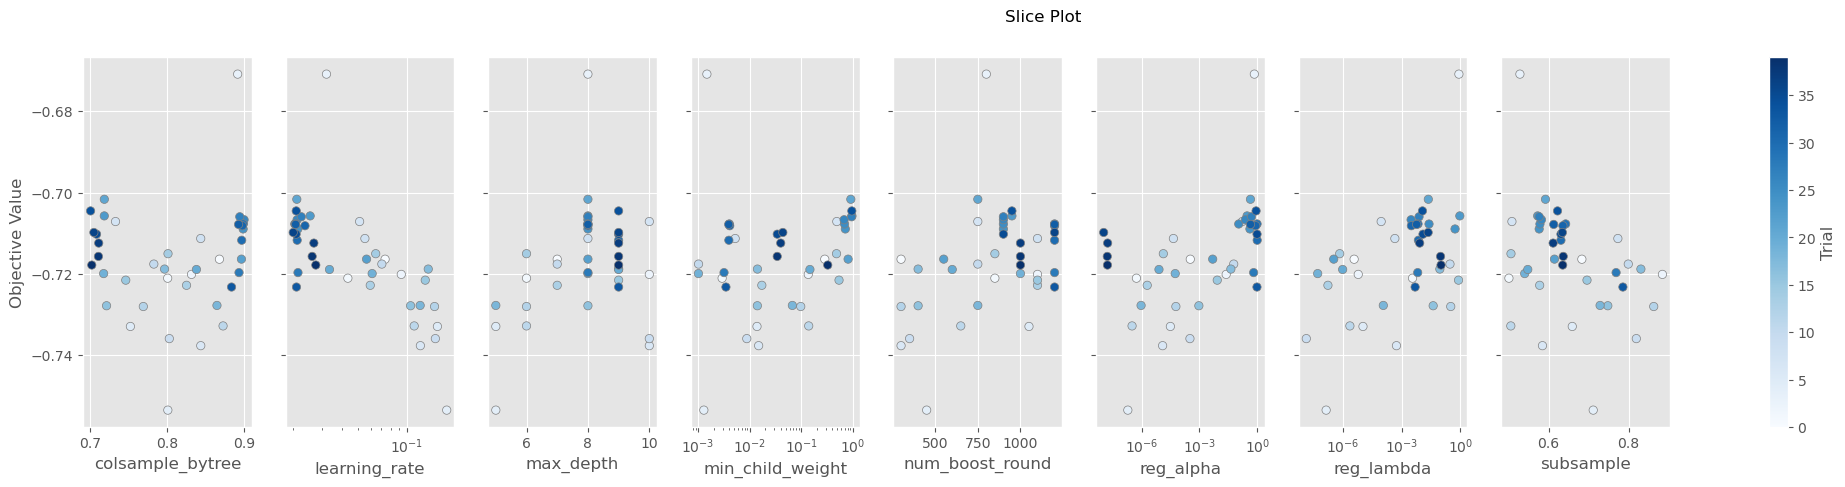

In [26]:
from optuna.visualization.matplotlib import plot_slice
import matplotlib.pyplot as plt

ax  = plot_slice(best_study)
plt.show()

In [ ]:
dall   = xgb.DMatrix(X, label=y)
best_booster = xgb.train(best_params, dall,
                         num_boost_round=best_params["num_boost_round"])
best_booster.save_model(RUN_DIR / "model" / "runtime_xgb_full.json")

In [29]:
class BoosterWrapper:
    def __init__(self, booster): self.booster = booster
    def predict(self, X): return self.booster.predict(xgb.DMatrix(X))

best_model = BoosterWrapper(best_booster)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import xgboost as xgb


def plot_runtime_scatter_xgb(best_param_dict,
                             X, y_log10,
                             n_folds=10,
                             lower=1e-4,  # seconds
                             upper=1e4,
                             figsize=(6, 6), random_state=1234):
    """
    Train‑/test splits an X matrix and log10‑runtime vector, predicts
    cross‑validated runtimes with the supplied XGBoost hyper‑parameters,
    and produces a scatter plot in **seconds** (log–log).

    Parameters
    ----------
    best_param_dict : dict
        Final XGBoost parameters *including* "num_boost_round".
    X, y_log10      : pandas DataFrame / Series or NumPy arrays.
    """

    # ------------------------------------------------------------
    # 1. cross‑validated predictions (in log space)
    # ------------------------------------------------------------
    kf          = KFold(n_splits=n_folds, shuffle=True,
                        random_state=random_state)
    y_pred_log  = np.empty_like(y_log10, dtype=float)

    params      = best_param_dict.copy()           # don't mutate caller
    num_round   = params.pop("num_boost_round")    # keep separate

    X_np  = np.asarray(X)
    y_np  = np.asarray(y_log10)

    for train_idx, test_idx in kf.split(X_np):
        dtrain = xgb.DMatrix(X_np[train_idx], label=y_np[train_idx])
        booster = xgb.train(params, dtrain,
                            num_boost_round=num_round,
                            verbose_eval=False)

        dtest = xgb.DMatrix(X_np[test_idx])
        y_pred_log[test_idx] = booster.predict(dtest)

    # ------------------------------------------------------------
    # 2. convert to seconds
    # ------------------------------------------------------------
    y_true_sec = 10 ** y_np
    y_pred_sec = 10 ** y_pred_log

    # ------------------------------------------------------------
    # 3. in‑range vs. clipped points
    # ------------------------------------------------------------
    inside  = (y_pred_sec >= lower) & (y_pred_sec <= upper)
    outside = ~inside

    # ------------------------------------------------------------
    # 4. plot
    # ------------------------------------------------------------

    fig, ax = plt.subplots(figsize=figsize, dpi=150)
    ax.set_prop_cycle(None)        # resets to beginning of current cycle
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(y_true_sec[inside],  y_pred_sec[inside],
               s=18, alpha=0.6, edgecolor="k")
    ax.scatter(y_true_sec[outside],
               np.clip(y_pred_sec[outside], lower, upper),
               s=18, alpha=0.6, edgecolor="k", marker="x", color="tab:blue")

    # diagonal
    ax.plot([lower, upper], [lower, upper],
            linestyle="--", linewidth=1.0, color="red")

    # axes limits, ticks, labels
    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    tick_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    tick_lbls = [fr"$10^{{{int(np.log10(t))}}}$" for t in tick_vals]
    ax.set_xticks(tick_vals, tick_lbls)
    ax.set_yticks(tick_vals, tick_lbls)

    ax.set_xlabel("true runtime (s)")
    ax.set_ylabel("predicted runtime (s)")
    ax.set_title(f"XGBoost (Hyp. Opt)")
    ax.grid(which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    return fig, ax


/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_35625/3910090193.py:70: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(y_true_sec[outside],


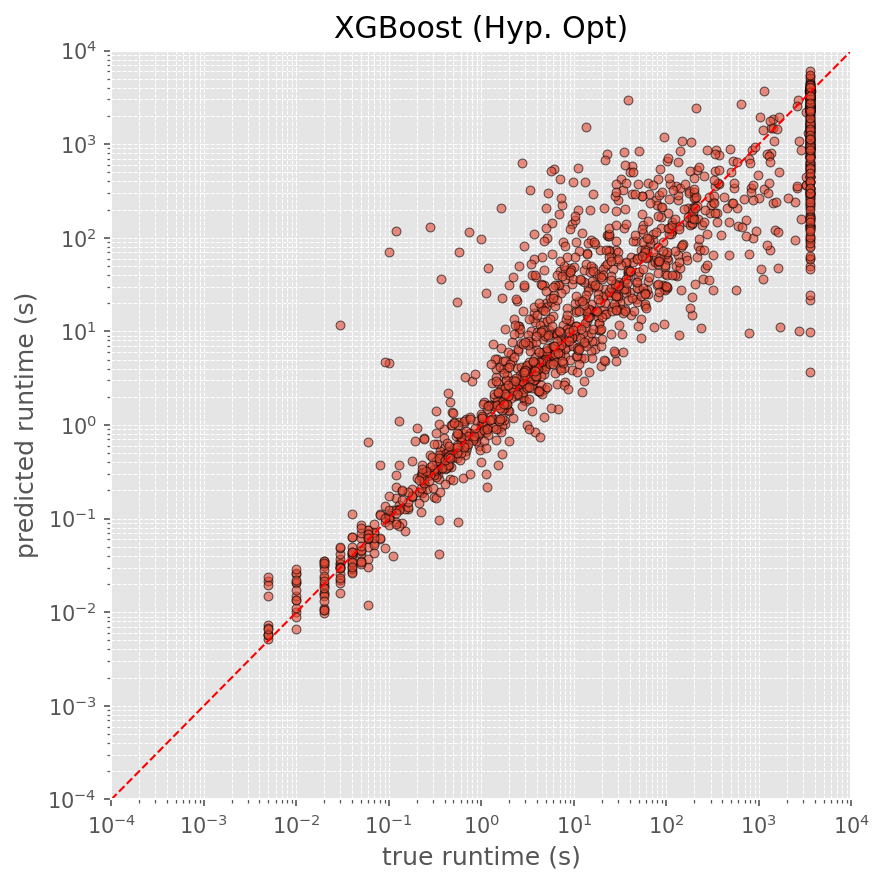

In [39]:
fig, ax = plot_runtime_scatter_xgb(best_params, X, y, n_folds=10)
plt.show()

In [ ]:
metrics_payload = {
    "rmse_outer_mean": float(np.mean(rmse_outer)) if len(rmse_outer) else None,
    "rmse_outer_std":  float(np.std(rmse_outer))  if len(rmse_outer) else None,
    "cc_outer_mean":   float(np.mean(ccs_outer))  if len(ccs_outer)  else None,
    "cc_outer_std":    float(np.std(ccs_outer))   if len(ccs_outer)  else None,
    "rmse_outer":      [float(v) for v in rmse_outer],
    "ccs_outer":       [float(v) for v in ccs_outer],
    "best_fold_idx":   int(best_fold_idx) if best_fold_idx is not None else None,
    "best_overall_rmse": float(best_overall_rmse) if np.isfinite(best_overall_rmse) else None,
}
save_metrics("nested_cv_summary", metrics_payload)

if best_study is not None:
    save_optuna(best_study)
else:
    print("No Optuna study found in scope — skipped saving Optuna artifacts.")

if best_params is None:
    raise RuntimeError("best_params is None — cannot train final model. "
                       "Make sure the nested CV loop ran successfully.")

params_final = best_params.copy()
num_round    = int(params_final.pop("num_boost_round"))

feature_names = list(X.columns) if hasattr(X, "columns") else None
dall = xgb.DMatrix(X, label=y, feature_names=feature_names)

final_booster = xgb.train(
    params=params_final,
    dtrain=dall,
    num_boost_round=num_round,
    verbose_eval=False,
)

save_model(final_booster, name="xgb-runtime-optimized-final")